In [1]:
from functions_for_all_nutrients import *
from iron_hemoglobin_functions import *

# Impact

In [2]:
def pull_dalys(cause_ids, nonfatal_cause_ids, location_ids, ages, sexes, index_cols):
    """
    This function pulls dalys for specified cause IDs from GBD
    -----
    INPUT (all in List() format):
    - cause
    ids for YLL models
    - nonfatal_cause_ids for YLD models
    - location_ids for which to pull dalys
    - ages (age_group_ids) for which to pull dalys
    - sexes (sex_ids) for which to pull dalys
    - index_cols with which to format output
    -----
    @returns a drawspace dataframe of DALYS attributable to each fatal or nonfatal cause_id:
        - columns = draws
        - index = multiindex(loc_id, sex_id, age_group_id, cause_id)
    """
    if len(cause_ids) + len(nonfatal_cause_ids) == 0:
        raise Exception("Must select at least one fatal or nonfatal cause_id")
        
    #init empty dfs
    ylds, ylls = pd.DataFrame(), pd.DataFrame()
    
    if len(nonfatal_cause_ids)>0:
        ylds = get_draws(
            gbd_id_type='cause_id',
            gbd_id=cause_ids,
            source='como',
            measure_id=3,
            metric_id=3,  # only available as rate
            location_id=location_ids,
            year_id=2019,
            age_group_id=ages,
            sex_id=sexes,
            gbd_round_id=6,
            status='best',
            decomp_step='step5',
        ).set_index(index_cols + ['cause_id'])
        ylds = ylds.drop(columns=[c for c in ylds.columns if 'draw' not in c])

        #convert rate to count
        pop = get_population(
            location_id=location_ids,
            year_id=2019,
            age_group_id=ages,
            sex_id=sexes,
            gbd_round_id=6,
            decomp_step='step4').set_index(index_cols)
        for i in list(range(0, 1000)):
            ylds[f'draw_{i}'] = ylds[f'draw_{i}'] * pop['population']
    else:
        print("No nonfatal ids selected; returning ylls only")
    
    if len(cause_ids)>0:
        ylls = get_draws(
            gbd_id_type='cause_id',
            gbd_id=cause_ids,
            source='codcorrect',
            measure_id=4,
            metric_id=1,
            location_id=location_ids,
            year_id=2019,
            age_group_id=ages,
            sex_id=sexes,
            gbd_round_id=6,
            status='latest',
            decomp_step='step5',
        ).set_index(index_cols + ['cause_id']).replace(np.nan, 0)
        ylls = ylls.drop(columns=[c for c in ylls.columns if 'draw' not in c])
    else:
        print("No fatal ids selected; returning ylds only")
    
    return ylls + ylds

In [3]:
username = !whoami
coverage_confidence_data_dir = f'/ihme/homes/{username[0]}/notebooks/vivarium_research_lsff/data_prep/outputs/data_richness_score.csv'
confidence = pd.read_csv(coverage_confidence_data_dir).replace('vitamin a','vitamin A').drop_duplicates()
confidence = confidence.loc[confidence.nutrient!='na']
confidence.head()

location_name      vehicle    nutrient  score
0      Ethiopia  maize flour  folic acid    0.0
1        Angola  wheat flour        iron    0.0
2        Angola  wheat flour   vitamin A    0.0
3        Angola  wheat flour        zinc    0.0
4         China          oil   vitamin A    0.0

In [4]:
folic_acid = pd.read_csv('/ihme/homes/alibow/notebooks/vivarium_research_lsff/multiplication_models/folic_acid/tier1_2_3_4_5_wheat_flour_dalys_averted_folic_acid_04_01_2021.csv')
folic_acid.head()

location_id  year_id  coverage_level       draw_0       draw_1  \
0            6     2022             0.2      0.00000     0.000000   
1            6     2022             0.5      0.00000     0.000000   
2            6     2022             0.8      0.00000     0.000000   
3            6     2023             0.2   4879.32766  3035.510744   
4            6     2023             0.5  12198.31915  7588.776860   

        draw_2       draw_3       draw_4       draw_5       draw_6  ...  \
0     0.000000     0.000000     0.000000     0.000000     0.000000  ...   
1     0.000000     0.000000     0.000000     0.000000     0.000000  ...   
2     0.000000     0.000000     0.000000     0.000000     0.000000  ...   
3  2252.742205  2546.845811  1896.625035  3654.603422  1975.993315  ...   
4  5631.855512  6367.114528  4741.562589  9136.508555  4939.983287  ...   

       draw_990     draw_991      draw_992     draw_993     draw_994  \
0      0.000000     0.000000      0.000000     0.000000     0.000000   
1      0.000000     0.000000      0.000000     0.000000     0.000000   
2      0.000000     0.000000      0.000000     0.000000     0.000000   
3   4019.502611  2828.992302   5185.396570  3358.699625  1899.236014   
4  10048.756527  7072.480756  12963.491425  8396.749063  4748.090036   

      draw_995     draw_996     draw_997     draw_998     draw_999  
0     0.000000     0.000000     0.000000     0.000000     0.000000  
1     0.000000     0.000000     0.000000     0.000000     0.000000  
2     0.000000     0.000000     0.000000     0.000000     0.000000  
3  2758.678275  1869.282878  1716.324395  2740.560893  3361.752202  
4  6896.695686  4673.207194  4290.810987  6851.402232  8404.380506  

[5 rows x 1003 columns]

In [5]:
folic_acid_dalys = pd.DataFrame()
for vehicle in ['maize_flour','wheat_flour']:
    folic_acid_sub = pd.read_csv(f'/ihme/homes/alibow/notebooks/vivarium_research_lsff/multiplication_models/folic_acid/tier1_2_3_4_5_{vehicle}_dalys_averted_folic_acid_04_01_2021.csv')
    folic_acid_sub['vehicle'] = vehicle.replace('_',' ')
    folic_acid_sub['nutrient'] = 'folic acid'
    folic_acid_sub['measure'] = 'counts_averted'
    folic_acid_dalys = pd.concat([folic_acid_dalys, folic_acid_sub], ignore_index=True)
folic_acid_dalys.head()

location_id  year_id  coverage_level       draw_0       draw_1  \
0          141     2022             0.2     0.000000     0.000000   
1          141     2022             0.5     0.000000     0.000000   
2          141     2022             0.8     0.000000     0.000000   
3          141     2023             0.2   462.764918   792.327297   
4          141     2023             0.5  1156.912294  1980.818242   

        draw_2       draw_3      draw_4       draw_5       draw_6  ...  \
0     0.000000     0.000000    0.000000     0.000000     0.000000  ...   
1     0.000000     0.000000    0.000000     0.000000     0.000000  ...   
2     0.000000     0.000000    0.000000     0.000000     0.000000  ...   
3   956.344450   417.713646  277.849344   470.809533   653.625431  ...   
4  2390.861124  1044.284115  694.623361  1177.023832  1634.063579  ...   

      draw_993     draw_994     draw_995     draw_996     draw_997  \
0     0.000000     0.000000     0.000000     0.000000     0.000000   
1     0.000000     0.000000     0.000000     0.000000     0.000000   
2     0.000000     0.000000     0.000000     0.000000     0.000000   
3  1329.389691   583.621365   749.925585   790.465046   715.173987   
4  3323.474227  1459.053414  1874.813963  1976.162615  1787.934967   

      draw_998     draw_999      vehicle    nutrient         measure  
0     0.000000     0.000000  maize flour  folic acid  counts_averted  
1     0.000000     0.000000  maize flour  folic acid  counts_averted  
2     0.000000     0.000000  maize flour  folic acid  counts_averted  
3  1221.131607   972.358414  maize flour  folic acid  counts_averted  
4  3052.829017  2430.896036  maize flour  folic acid  counts_averted  

[5 rows x 1006 columns]

In [6]:
pop = (get_population(location_id=list(folic_acid_dalys.location_id.unique()),
                     year_id=2019,
                     sex_id=[1,2],
                     age_group_id=[2,3,4,5],
                     gbd_round_id=6,
                     decomp_step='step4')
       .groupby('location_id', as_index=False)
       .sum()
       .filter(['location_id','population']))
folic_acid_daly_rate = folic_acid_dalys.merge(pop, on='location_id')
for i in list(range(0,1000)):
    folic_acid_daly_rate[f'draw_{i}'] = (folic_acid_daly_rate[f'draw_{i}'] 
     / folic_acid_daly_rate['population']
     * 100_000)
folic_acid_daly_rate['measure'] = 'rates_averted'
folic_acid_daly_rate.head()

location_id  year_id  coverage_level     draw_0     draw_1     draw_2  \
0          141     2022             0.2   0.000000   0.000000   0.000000   
1          141     2022             0.5   0.000000   0.000000   0.000000   
2          141     2022             0.8   0.000000   0.000000   0.000000   
3          141     2023             0.2   4.274888   7.319290   8.834432   
4          141     2023             0.5  10.687220  18.298224  22.086081   

     draw_3    draw_4     draw_5     draw_6  ...   draw_994   draw_995  \
0  0.000000  0.000000   0.000000   0.000000  ...   0.000000   0.000000   
1  0.000000  0.000000   0.000000   0.000000  ...   0.000000   0.000000   
2  0.000000  0.000000   0.000000   0.000000  ...   0.000000   0.000000   
3  3.858717  2.566692   4.349202   6.038002  ...   5.391325   6.927595   
4  9.646793  6.416729  10.873004  15.095005  ...  13.478312  17.318987   

    draw_996   draw_997   draw_998   draw_999      vehicle    nutrient  \
0   0.000000   0.000000   0.000000   0.000000  maize flour  folic acid   
1   0.000000   0.000000   0.000000   0.000000  maize flour  folic acid   
2   0.000000   0.000000   0.000000   0.000000  maize flour  folic acid   
3   7.302087   6.606570  11.280459   8.982365  maize flour  folic acid   
4  18.255216  16.516424  28.201148  22.455912  maize flour  folic acid   

         measure    population  
0  rates_averted  1.082519e+07  
1  rates_averted  1.082519e+07  
2  rates_averted  1.082519e+07  
3  rates_averted  1.082519e+07  
4  rates_averted  1.082519e+07  

[5 rows x 1007 columns]

In [7]:
folic_acid_total_dalys = pull_dalys([642], [642], list(folic_acid_dalys.location_id.unique()),
                                                       [2,3,4,5], [1,2], ['location_id','age_group_id','sex_id'])
folic_acid_total_dalys.head()

draw_0        draw_1  \
location_id age_group_id sex_id cause_id                               
6           2            1      642       10322.763878   9471.983857   
                         2      642       10878.008120  10382.724118   
            3            1      642       10793.369985  10263.918859   
                         2      642        5420.411589   6031.876738   
            4            1      642       25336.608266  21714.315391   

                                               draw_10      draw_100  \
location_id age_group_id sex_id cause_id                               
6           2            1      642        9326.322863  10395.966085   
                         2      642       10116.728296   9244.719719   
            3            1      642        9382.185956   9968.037842   
                         2      642        5550.473866   5195.318715   
            4            1      642       20047.215818  23050.370131   

                                              draw_101      draw_102  \
location_id age_group_id sex_id cause_id                               
6           2            1      642       13510.893438  10190.255967   
                         2      642       12568.191988   8388.912625   
            3            1      642       11416.271719   9862.964908   
                         2      642        4654.615975   4102.396269   
            4            1      642       28084.480363  21569.777665   

                                              draw_103      draw_104  \
location_id age_group_id sex_id cause_id                               
6           2            1      642        9542.422309  11721.644281   
                         2      642        9137.537798  10220.456155   
            3            1      642       11121.482312  11598.592613   
                         2      642        4836.188153   5770.740071   
            4            1      642       22029.386753  26934.517383   

                                              draw_105      draw_106  ...  \
location_id age_group_id sex_id cause_id                              ...   
6           2            1      642        8732.405622   9642.032379  ...   
                         2      642        7906.165243   8515.270704  ...   
            3            1      642        9764.893270  10017.196952  ...   
                         2      642        4018.672643   4719.525137  ...   
            4            1      642       23360.799193  20067.716892  ...   

                                              draw_990      draw_991  \
location_id age_group_id sex_id cause_id                               
6           2            1      642        9922.346260  11560.055241   
                         2      642        6821.211242  11308.953852   
            3            1      642        8034.565573   8990.057434   
                         2      642        4196.673175   5774.423856   
            4            1      642       19383.308185  27212.898218   

                                              draw_992      draw_993  \
location_id age_group_id sex_id cause_id                               
6           2            1      642        9404.223828  10986.001146   
                         2      642        9333.432262  11717.126442   
            3            1      642       11906.901506  11044.259261   
                         2      642        5972.030682   4521.266838   
            4            1      642       31242.177965  27961.219167   

                                              draw_994      draw_995  \
location_id age_group_id sex_id cause_id                               
6           2            1      642       10630.453477  11978.378562   
                         2      642       10577.374858   9341.582233   
            3            1      642        8330.759180  11241.229038   
                         2      642        5691.058571   4578.434187   
            4            1      642       1872

In [8]:
folic_acid_pif = (folic_acid_dalys.set_index(['location_id', 'year_id', 'coverage_level', 'vehicle', 'nutrient', 'measure']) 
                  / folic_acid_total_dalys.groupby('location_id').sum()
                  * 100).reset_index()
folic_acid_pif['measure'] = 'pif'
folic_acid_pif.head()

location_id  year_id  coverage_level      vehicle    nutrient measure  \
0          141     2022             0.2  maize flour  folic acid     pif   
1          141     2022             0.5  maize flour  folic acid     pif   
2          141     2022             0.8  maize flour  folic acid     pif   
3          141     2023             0.2  maize flour  folic acid     pif   
4          141     2023             0.5  maize flour  folic acid     pif   

     draw_0    draw_1   draw_10  draw_100  ...  draw_990  draw_991  draw_992  \
0  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
1  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
2  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
3  1.860846  1.616776  1.686844  1.534060  ...  1.194379  0.867148  1.682160   
4  4.652115  4.041940  4.217109  3.835151  ...  2.985948  2.167871  4.205399   

   draw_993  draw_994  draw_995  draw_996  draw_997  draw_998  draw_999  
0   0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1   0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
2   0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
3   2.08836  1.212198  0.915905  1.876548  1.387257  2.285095  1.825456  
4   5.22090  3.030495  2.289764  4.691371  3.468143  5.712737  4.563641  

[5 rows x 1006 columns]

In [9]:
folic_acid = pd.concat([folic_acid_dalys, folic_acid_daly_rate.drop(columns=['population']), folic_acid_pif], ignore_index=True, sort=True)
folic_acid.head()

coverage_level       draw_0       draw_1      draw_10     draw_100  \
0             0.2     0.000000     0.000000     0.000000     0.000000   
1             0.5     0.000000     0.000000     0.000000     0.000000   
2             0.8     0.000000     0.000000     0.000000     0.000000   
3             0.2   462.764918   792.327297  1385.927866   834.969291   
4             0.5  1156.912294  1980.818242  3464.819665  2087.423228   

     draw_101     draw_102   draw_103     draw_104     draw_105  ...  \
0    0.000000     0.000000    0.00000     0.000000     0.000000  ...   
1    0.000000     0.000000    0.00000     0.000000     0.000000  ...   
2    0.000000     0.000000    0.00000     0.000000     0.000000  ...   
3  385.018803   561.746514  309.26844   417.987375   652.753961  ...   
4  962.547006  1404.366284  773.17110  1044.968437  1631.884901  ...   

      draw_995     draw_996     draw_997     draw_998     draw_999  \
0     0.000000     0.000000     0.000000     0.000000     0.000000   
1     0.000000     0.000000     0.000000     0.000000     0.000000   
2     0.000000     0.000000     0.000000     0.000000     0.000000   
3   749.925585   790.465046   715.173987  1221.131607   972.358414   
4  1874.813963  1976.162615  1787.934967  3052.829017  2430.896036   

   location_id         measure    nutrient      vehicle  year_id  
0          141  counts_averted  folic acid  maize flour     2022  
1          141  counts_averted  folic acid  maize flour     2022  
2          141  counts_averted  folic acid  maize flour     2022  
3          141  counts_averted  folic acid  maize flour     2023  
4          141  counts_averted  folic acid  maize flour     2023  

[5 rows x 1006 columns]

In [10]:
zinc = pd.read_pickle('results_raw/zinc.pkl')
zinc['nutrient'] = 'zinc'
zinc_prev = pd.read_pickle('results_raw/zinc_deficiency_exposure.pkl')
zinc_prev['measure'] = 'deficiency_exposure'

vitamin_a = pd.read_pickle('results_raw/vitamin_a.pkl')
vitamin_a['nutrient'] = 'vitamin a'
vitamin_a_prev = pd.read_pickle('results_raw/vitamin_a_deficiency_exposure.pkl')
vitamin_a_prev['measure'] = 'deficiency_exposure'

iron_u5 = pd.read_pickle('results_raw/iron_u5.pkl')
iron_u5['nutrient'] = 'iron'
iron_u5 = iron_u5.loc[iron_u5.year==2025]
iron_wra = pd.read_pickle('results_raw/iron_wra.pkl')
iron_wra['nutrient'] = 'iron'
iron = (iron_wra.set_index([c for c in iron_wra.columns if 'draw' not in c]) 
        + iron_u5.set_index([c for c in iron_wra.columns if 'draw' not in c])).reset_index()

results = pd.concat([folic_acid.rename(columns={'year_id':'year'}), zinc, vitamin_a, iron, vitamin_a_prev, zinc_prev], ignore_index=True, sort=True)
results['nutrient'] = results.nutrient.str.replace('vitamin a','vitamin A')
results['nutrient_name'] = results.nutrient.str.replace('_',' ').str.capitalize().str.replace('Vitamin a', 'Vitamin A')
l = get_ids('location')[['location_name','location_id']]
results = results.merge(l, on='location_id')
results['label'] = results.nutrient_name + ' in ' + results.vehicle
results = results.loc[results.year==2025]
results.head()

coverage_level       draw_0       draw_1      draw_10     draw_100  \
9              0.2   743.496800  1479.550469  1597.952786  1083.064738   
10             0.5  1858.742000  3698.876173  3994.881966  2707.661845   
11             0.8  2973.987200  5918.201877  6391.811146  4332.258952   
21             0.2  1016.927577  1620.764474  2355.507146  2885.105359   
22             0.5  2542.318942  4051.911185  5888.767865  7212.763397   

       draw_101     draw_102     draw_103     draw_104     draw_105  ...  \
9    488.736716   673.982572   510.457605   647.465561  1212.476363  ...   
10  1221.841789  1684.956430  1276.144012  1618.663902  3031.190907  ...   
11  1954.946863  2695.930288  2041.830419  2589.862243  4849.905452  ...   
21   897.596800  1118.381023   866.496853   757.477571  2210.746638  ...   
22  2243.992000  2795.952558  2166.242132  1893.693927  5526.866595  ...   

       draw_998     draw_999  location_id         measure    nutrient  \
9   1693.312600  1520.486189          141  counts_averted  folic acid   
10  4233.281499  3801.215472          141  counts_averted  folic acid   
11  6773.250399  6081.944755          141  counts_averted  folic acid   
21  2244.898758  1551.782277          141  counts_averted  folic acid   
22  5612.246894  3879.455694          141  counts_averted  folic acid   

        vehicle    year  nutrient_name  location_name  \
9   maize flour  2025.0     Folic acid          Egypt   
10  maize flour  2025.0     Folic acid          Egypt   
11  maize flour  2025.0     Folic acid          Egypt   
21  wheat flour  2025.0     Folic acid          Egypt   
22  wheat flour  2025.0     Folic acid          Egypt   

                        label  
9   Folic acid in maize flour  
10  Folic acid in maize flour  
11  Folic acid in maize flour  
21  Folic acid in wheat flour  
22  Folic acid in wheat flour  

[5 rows x 1009 columns]

In [158]:
def make_dot_plots_by_nutrient_vehicle_pair(data, nutrient, measure, coverage_levels, confidence_data):
    """This function takes a dataframe,
    nutrient (as a string),
    and measure (as a string, either: 'rates', 'counts', or 'pifs').
    """

    f, ax = plt.subplots(figsize=(12, 4), dpi=120)
    colors = ['tab:red', 'tab:orange', 'tab:green']

    location_spacer = 0.15
    coverage_spacer = 0.025
    df = (data.drop(columns='measure', errors='ignore')
          .apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).reset_index())

    order = df.reset_index()
    order = list(
        order.loc[order.coverage_level == 0.8].loc[order.year == 2025].sort_values(by='mean').location_id.values)
    nums = list(range(0, len(order)))
    orders = pd.DataFrame()
    orders['location_id'] = order
    orders['order'] = nums
    df = df.merge(orders, on='location_id').sort_values(by='order', ascending=False)

    for n in list(range(0, len(coverage_levels))):
        rate = (df.loc[df.year == 2025]
            .loc[df.coverage_level == coverage_levels[n]])
        for i in list(range(0, len(rate))):
            plt.plot([location_spacer * i + coverage_spacer * n, location_spacer * i + coverage_spacer * n],
                     [rate['2.5%'].values[i], rate['97.5%'].values[i]], c='black', linewidth=1)
            plt.scatter([location_spacer * i + coverage_spacer * n], rate['2.5%'].values[i], s=10, marker='_',
                        c='black')
            plt.scatter([location_spacer * i + coverage_spacer * n], rate['97.5%'].values[i], s=10, marker='_',
                        c='black')

        x_vals = []
        for x in list(range(0, len(rate))):
            x_vals.append(location_spacer * x + coverage_spacer * n)
        plt.scatter(x_vals, rate['mean'], s=30,
                    label=f'{int(coverage_levels[n] * 100)} percent coverage', color=colors[n])

    plt.hlines(0, 0 - coverage_spacer * 2,
               location_spacer * (len(rate)) - coverage_spacer * 2,
               linestyle='dashed', color='grey', alpha=0.5)

    plt.plot()

    if measure == 'rates_averted':
        plt.title(f'DALYs averted per 100,000 person-years due to\n{nutrient} fortication in {vehicle}\n')
        plt.ylabel('DALYs Averted per 100,000')
    elif measure == 'counts_averted':
        plt.title(f'DALYs averted due to\n{nutrient} fortication in {vehicle}\n')
        plt.ylabel('DALYs')
    elif measure == 'pif':
        plt.title(f'Population impact fraction of {nutrient} fortication in {vehicle}\non DALYs as a proportion of {nutrient} deficiency attributable DALYs\n')
        plt.ylabel('Population Impact Fraction (Percent)')

    plt.legend(bbox_to_anchor=[1.3, 1])
    
    rate = rate.merge(confidence_data.replace('vitamin a','vitamin A'), on=['location_name','nutrient','vehicle'])
    rate['label'] = (np.where(rate.score == 5, '***** ',
                      np.where(rate.score == 4, '**** ',
                               np.where(rate.score == 3, '*** ',
                                        np.where(rate.score == 2, '** ',
                                                 np.where(rate.score == 1, '* ', '')))))
                   + rate.location_name)


    x_ticks = []
    for x in list(range(0, len(rate))):
        x_ticks.append(location_spacer * x + coverage_spacer)
    ax.set_xticks(x_ticks)
    plt.suptitle('(***** Indicates location-specific coverage data confidence score)', y=0.925, fontsize='medium')
    plt.xticks(rotation=90)
    ax.set_xticklabels(rate.label.values)

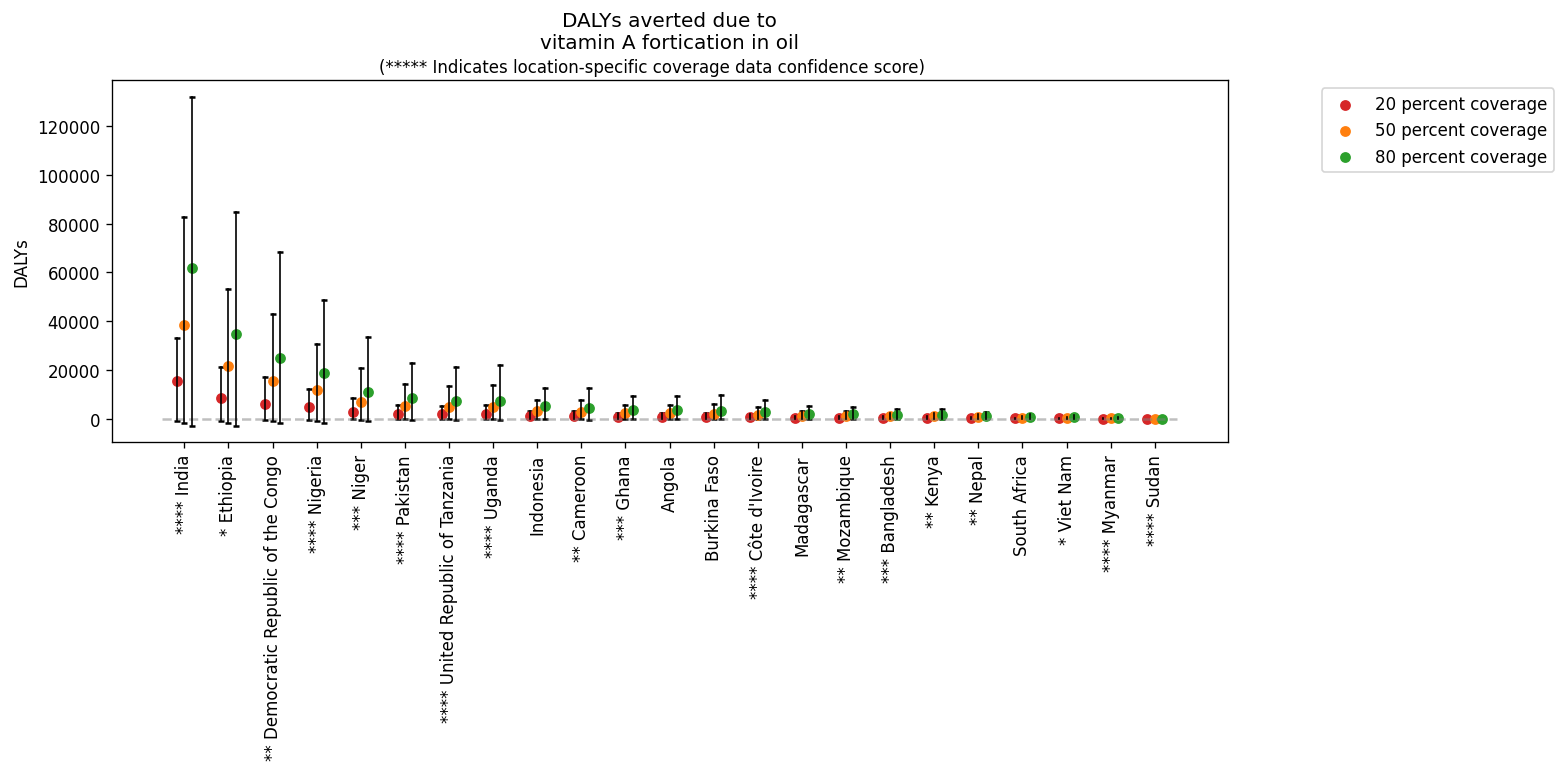

In [159]:
nutrient='vitamin A'
vehicle = 'oil'
measure = 'counts_averted'

plot = (results.loc[results.nutrient == nutrient]
        .loc[results.vehicle == vehicle]
        .loc[results.measure == measure]
        .loc[results.year == 2025]
        .set_index([c for c in results.columns if 'draw' not in c]))
make_dot_plots_by_nutrient_vehicle_pair(plot,
              nutrient,
              measure,
              coverage_levels,
              confidence)

/ihme/code/central_comp/miniconda_svc-ccomp/envs/v108/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


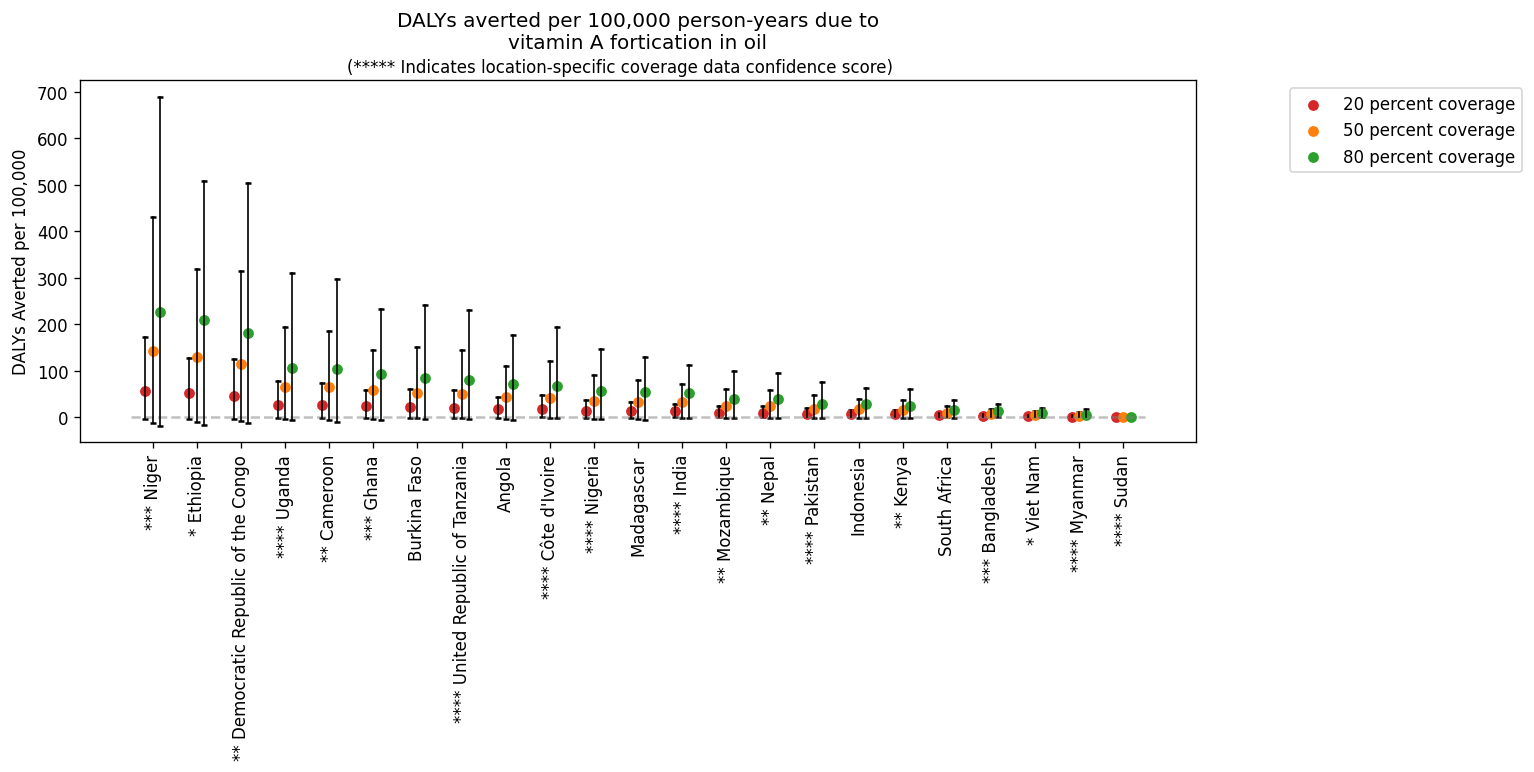

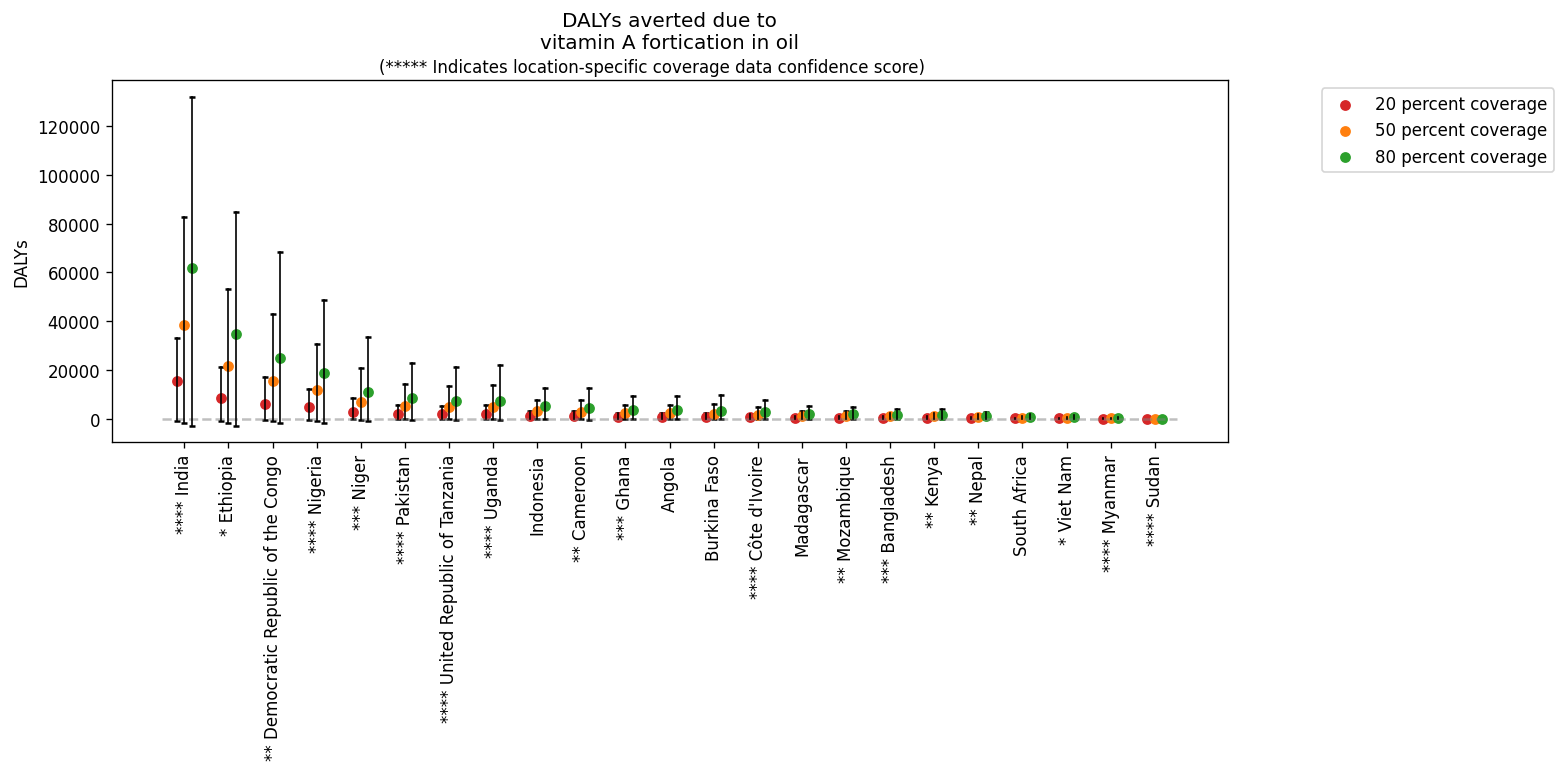

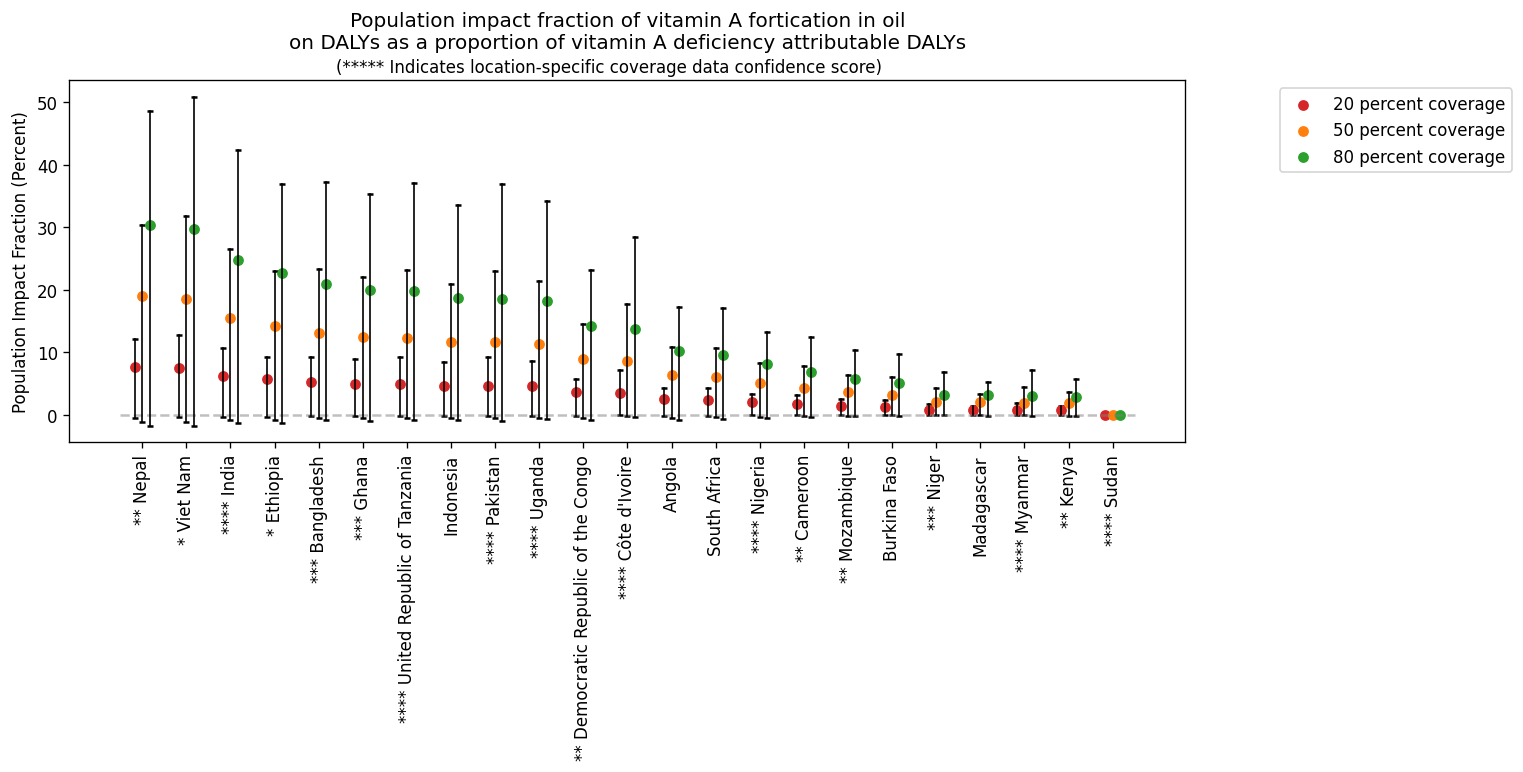

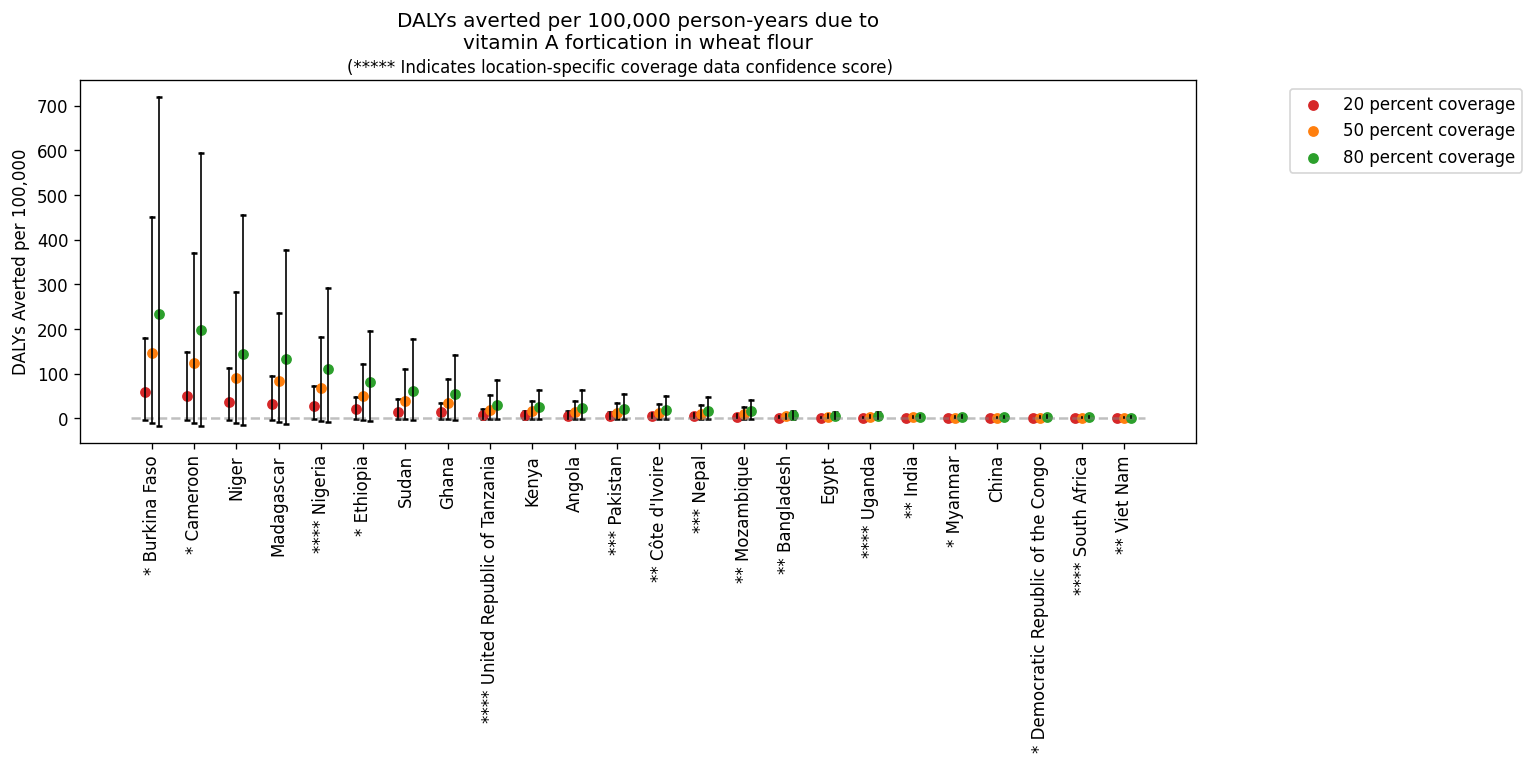

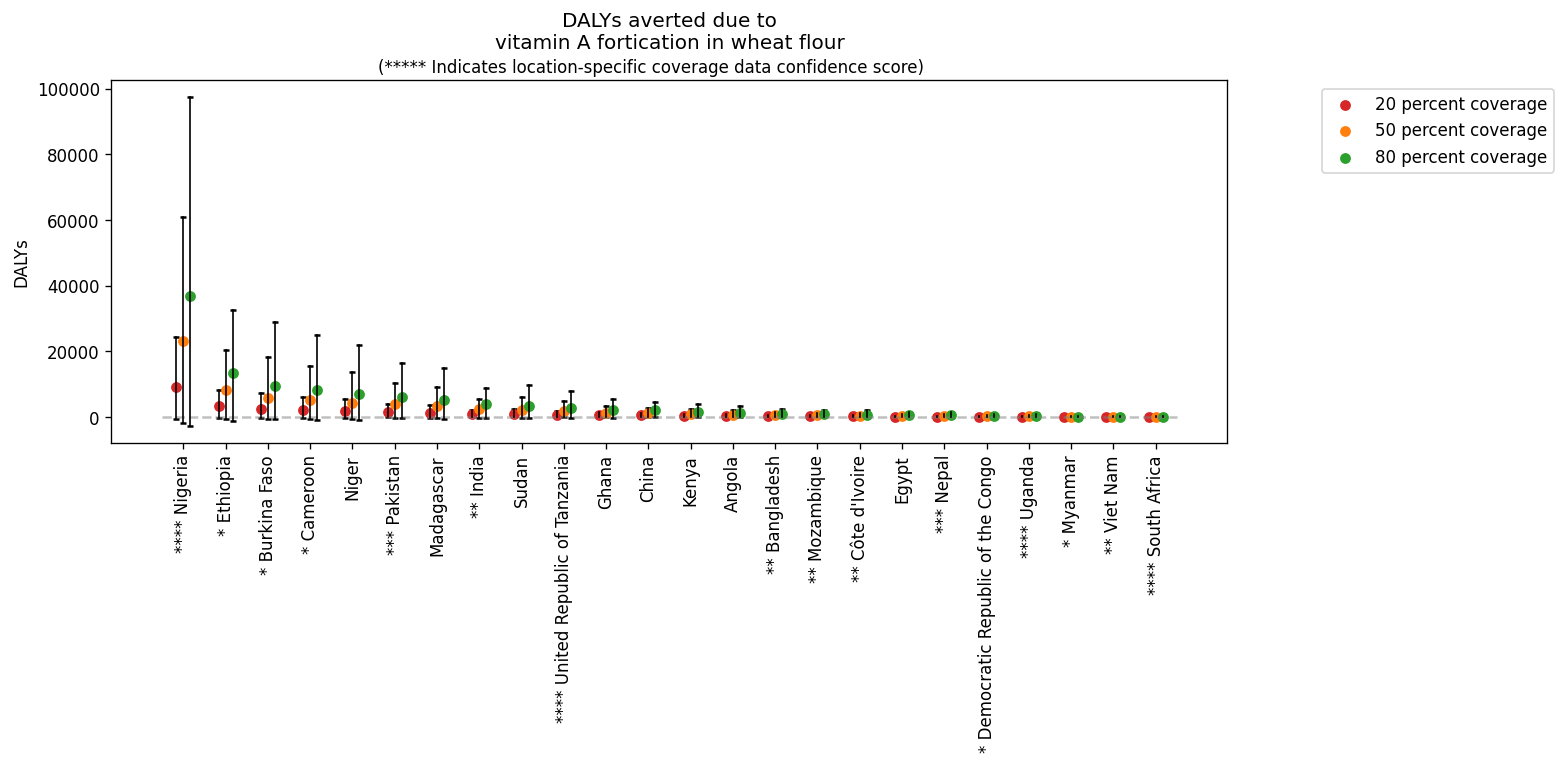

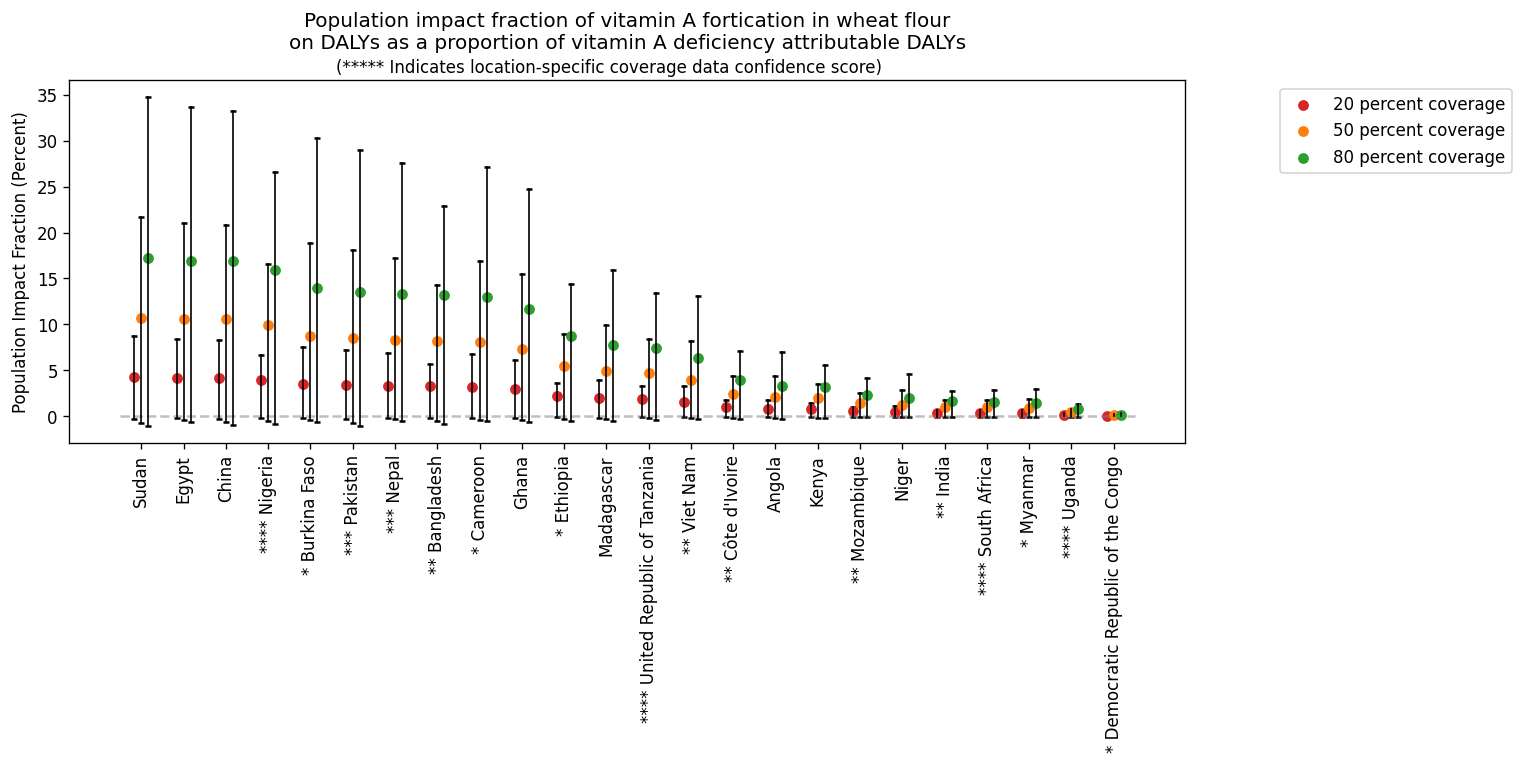

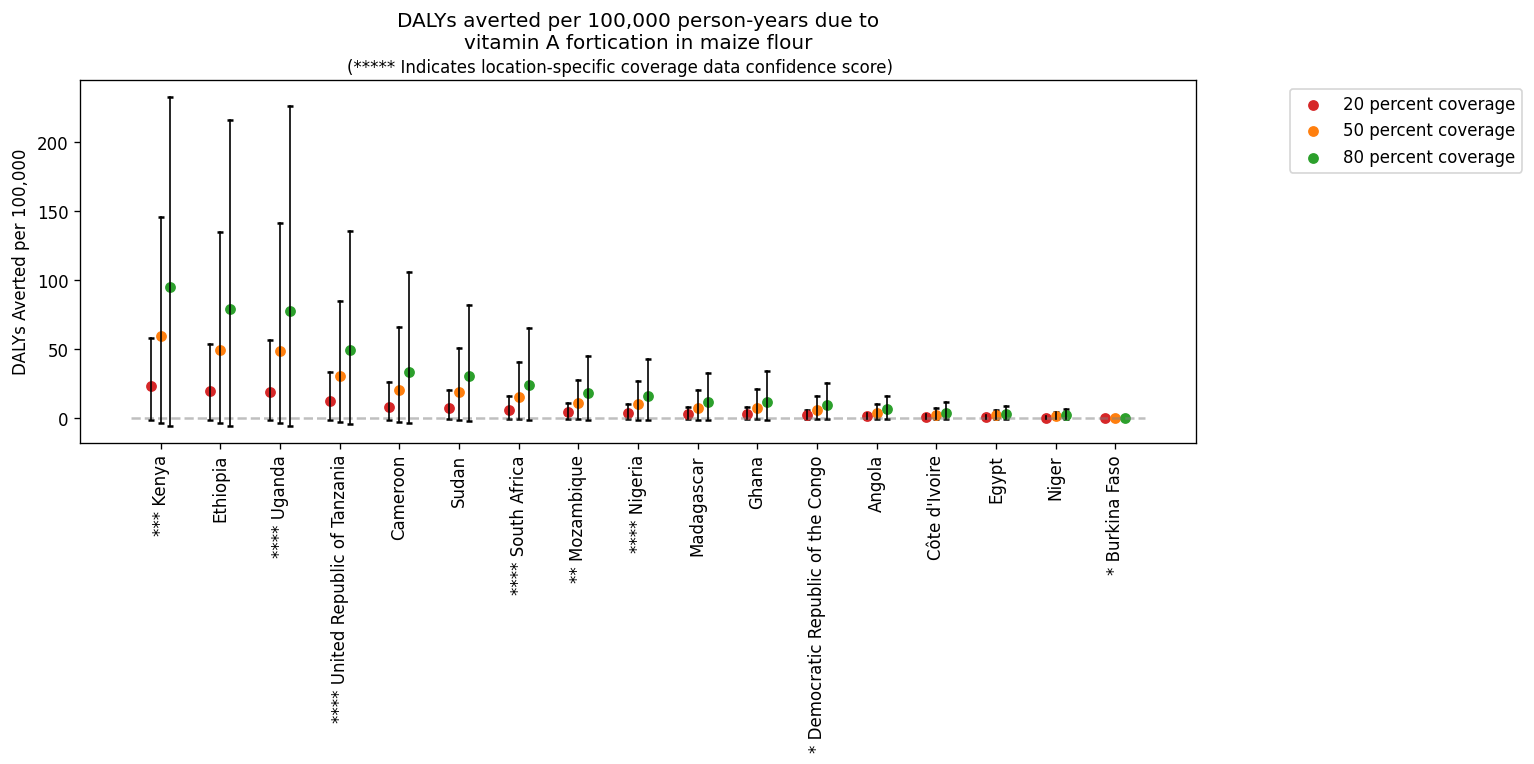

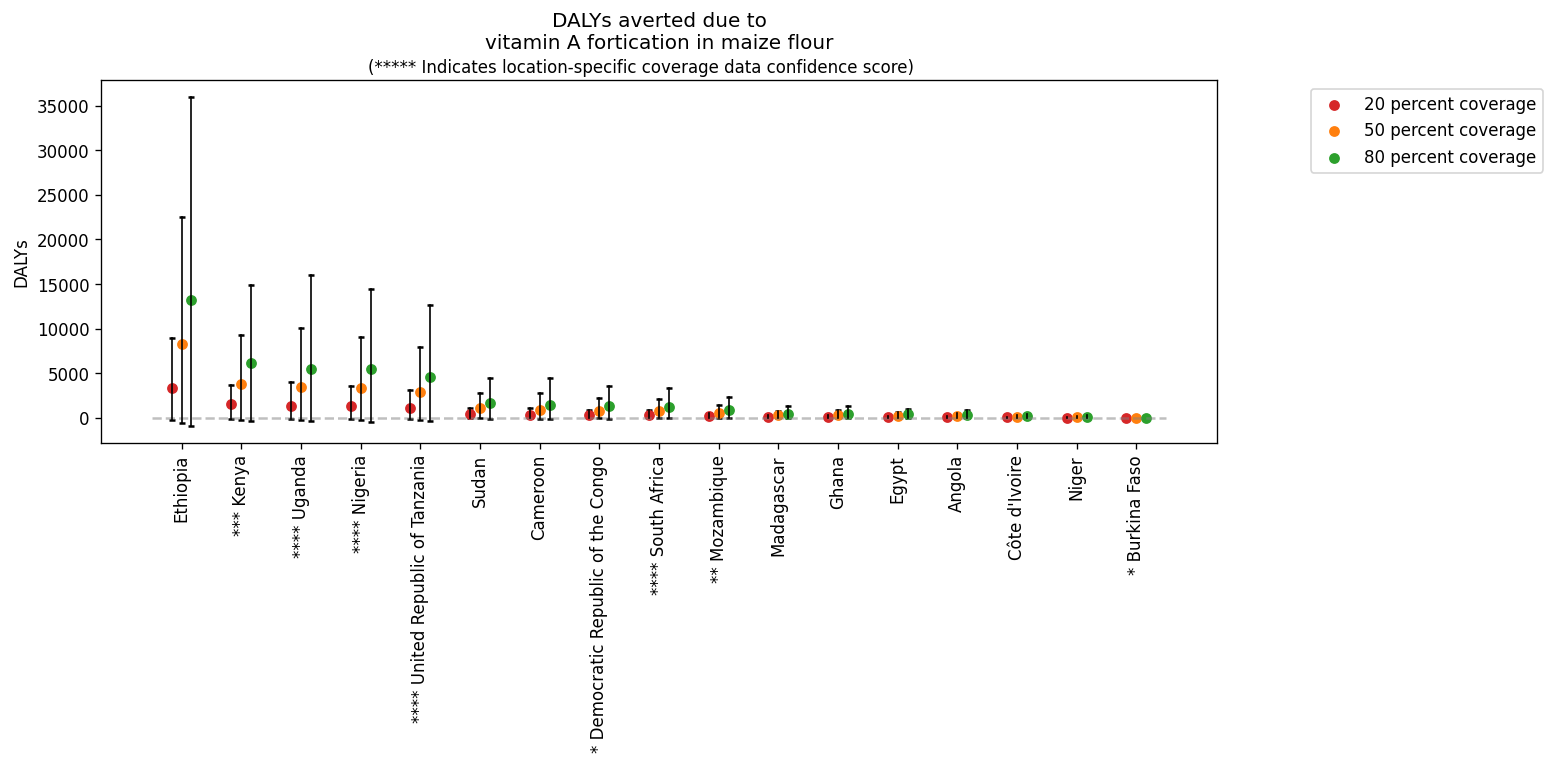

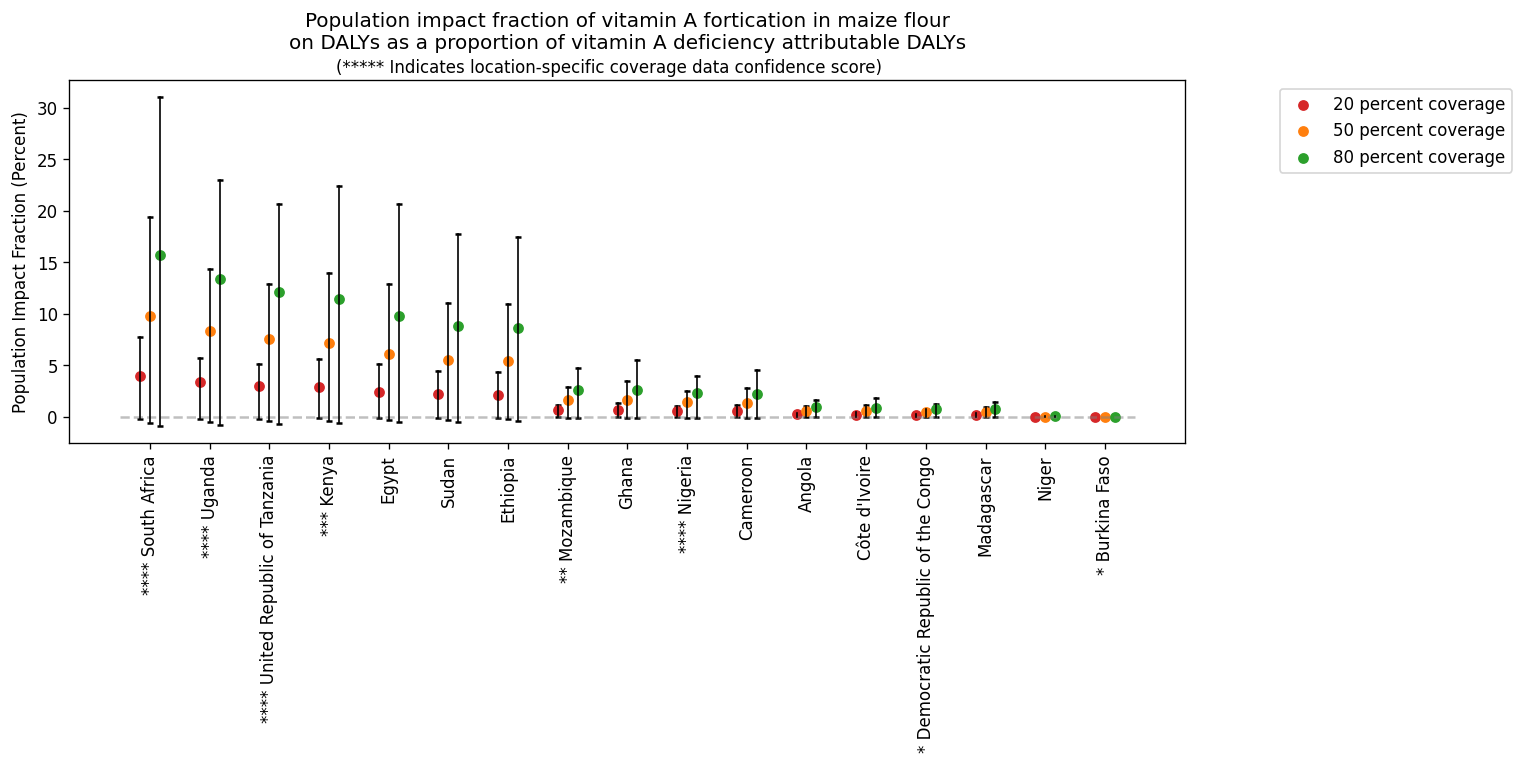

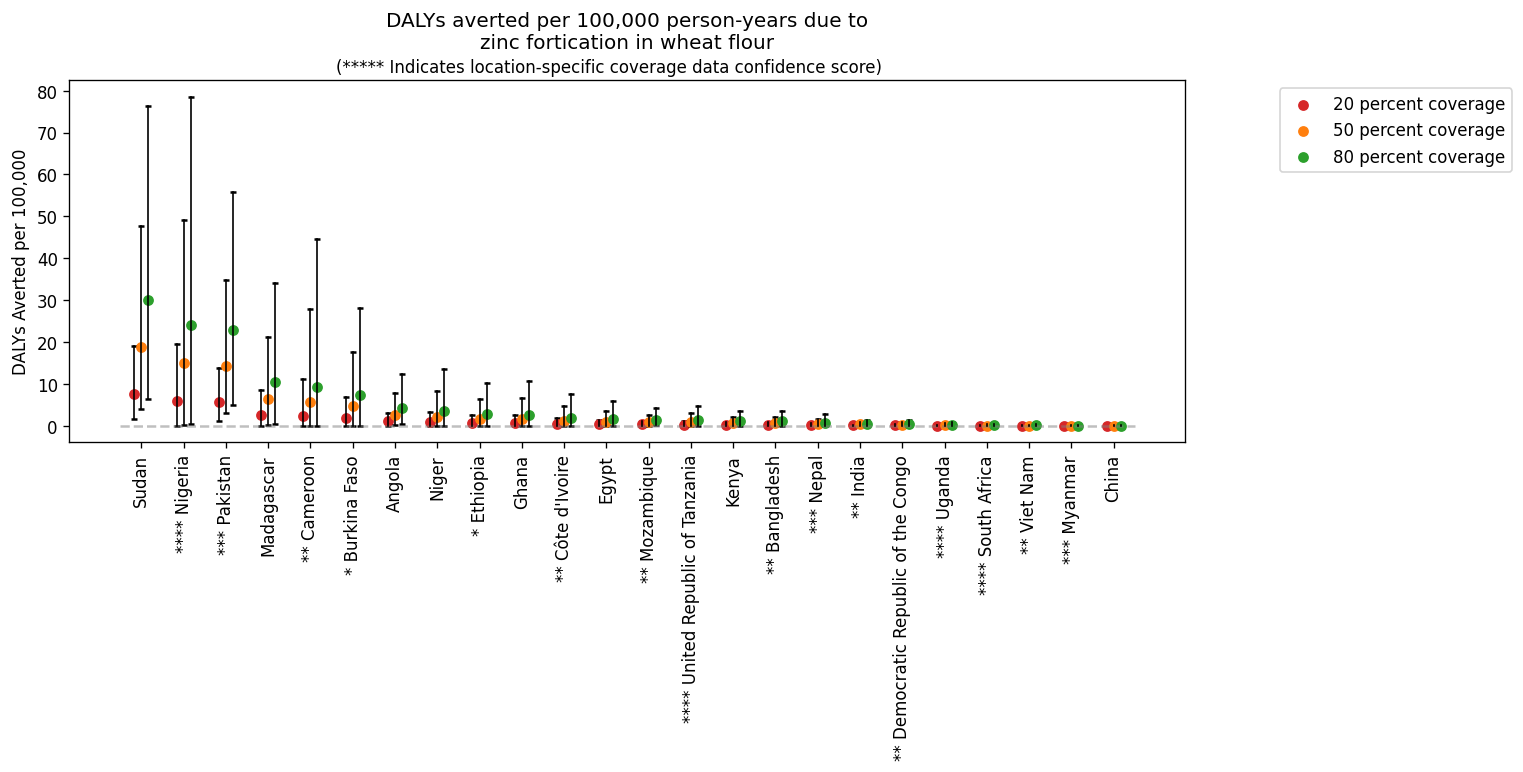

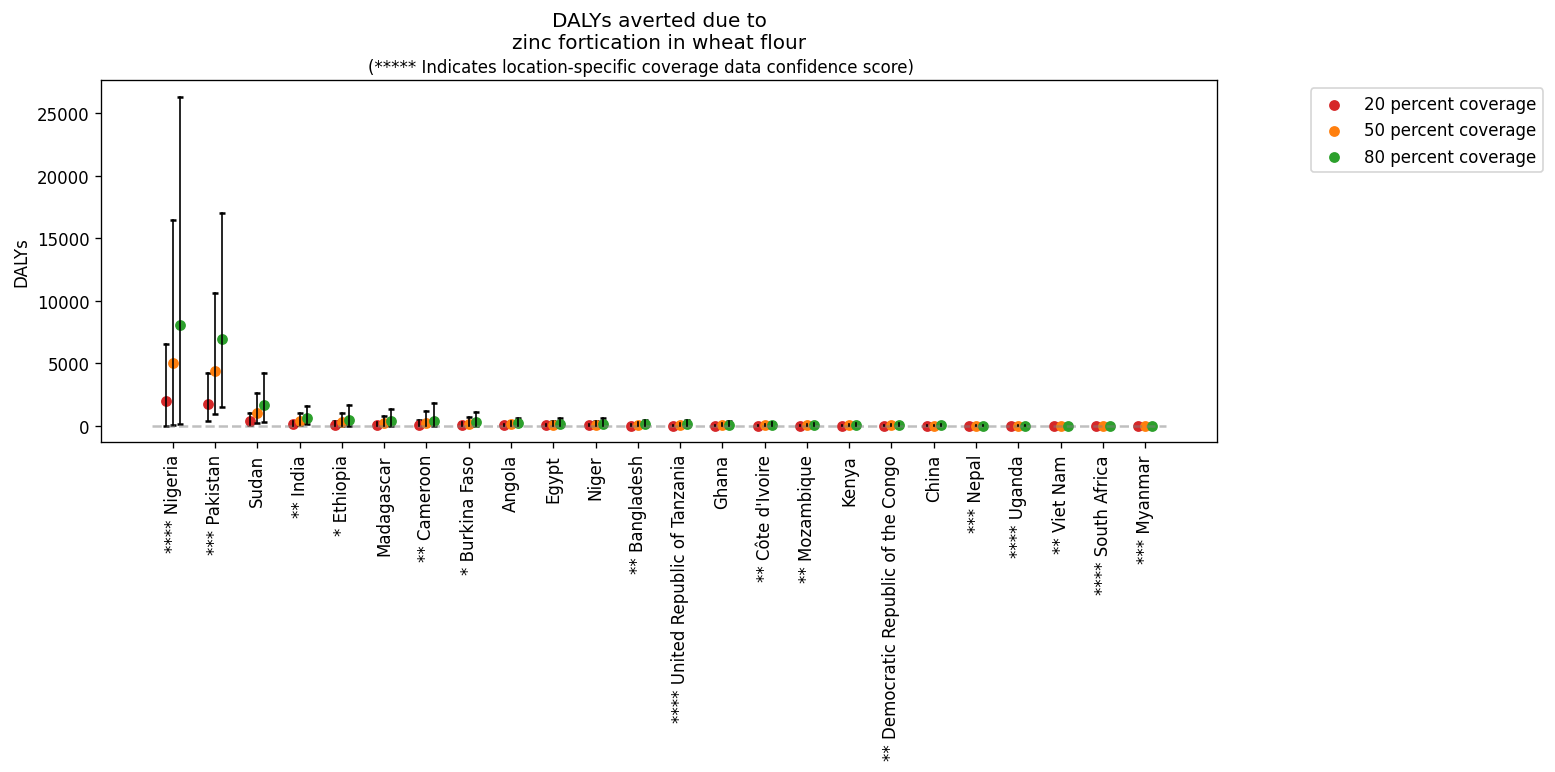

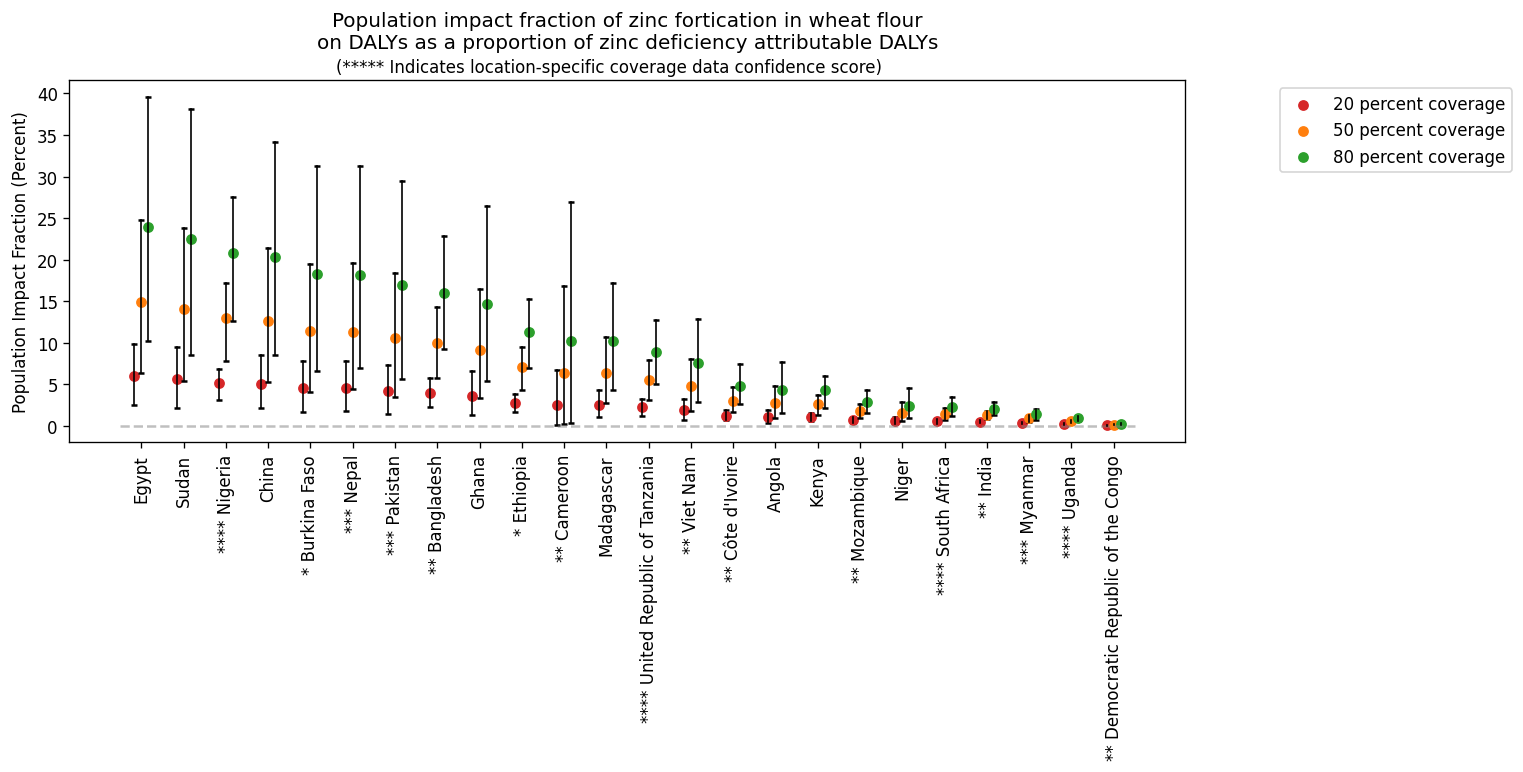

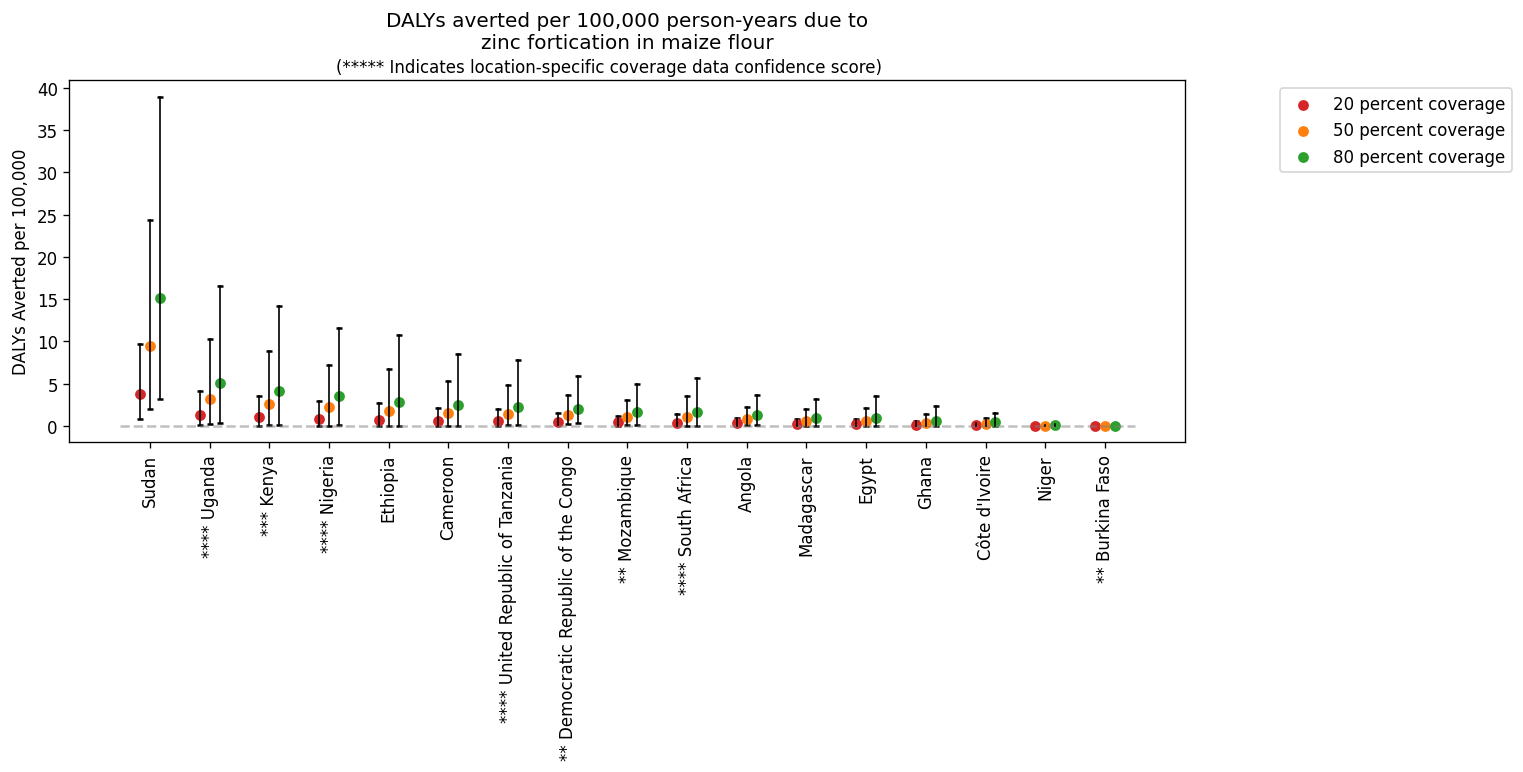

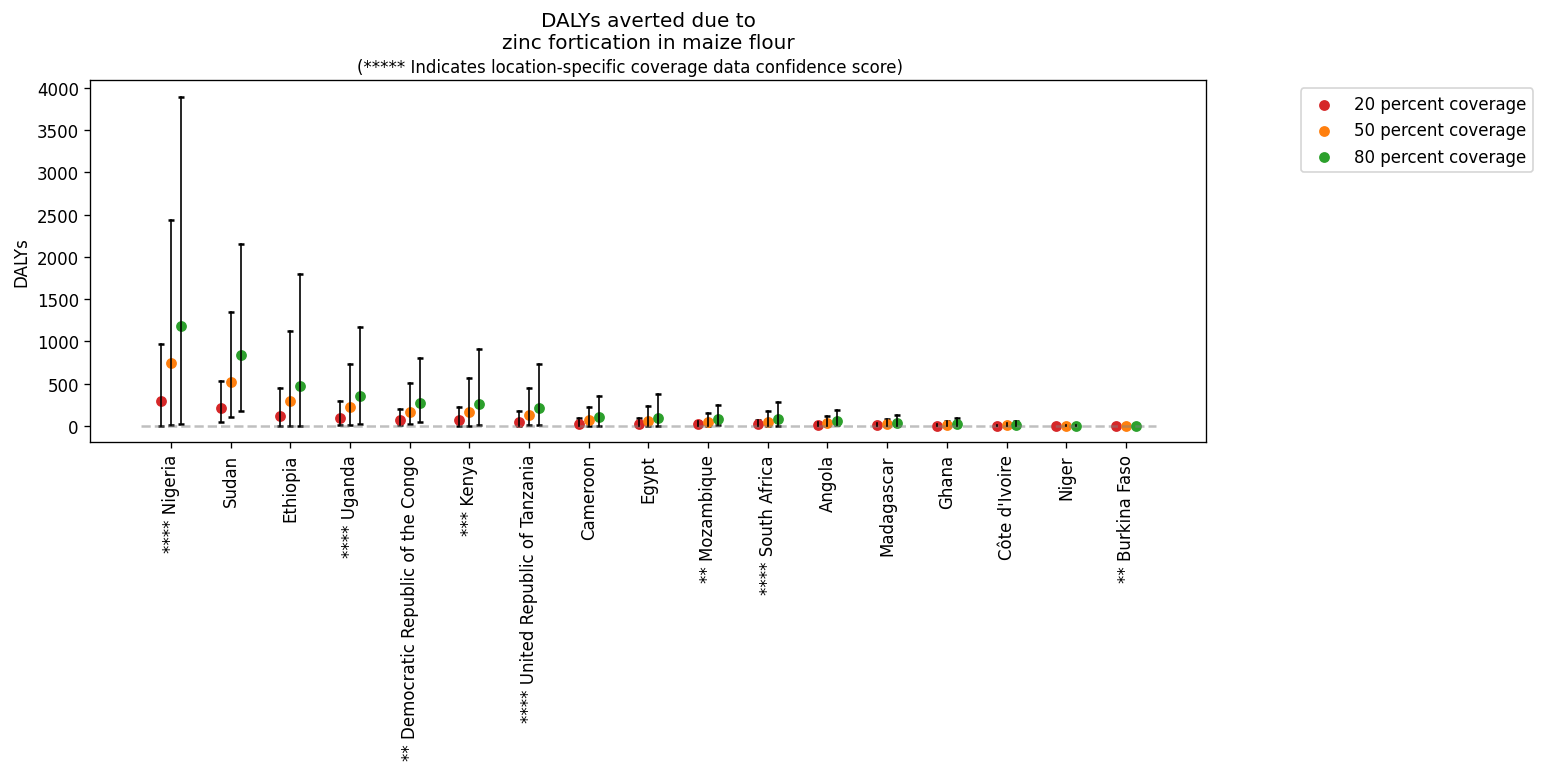

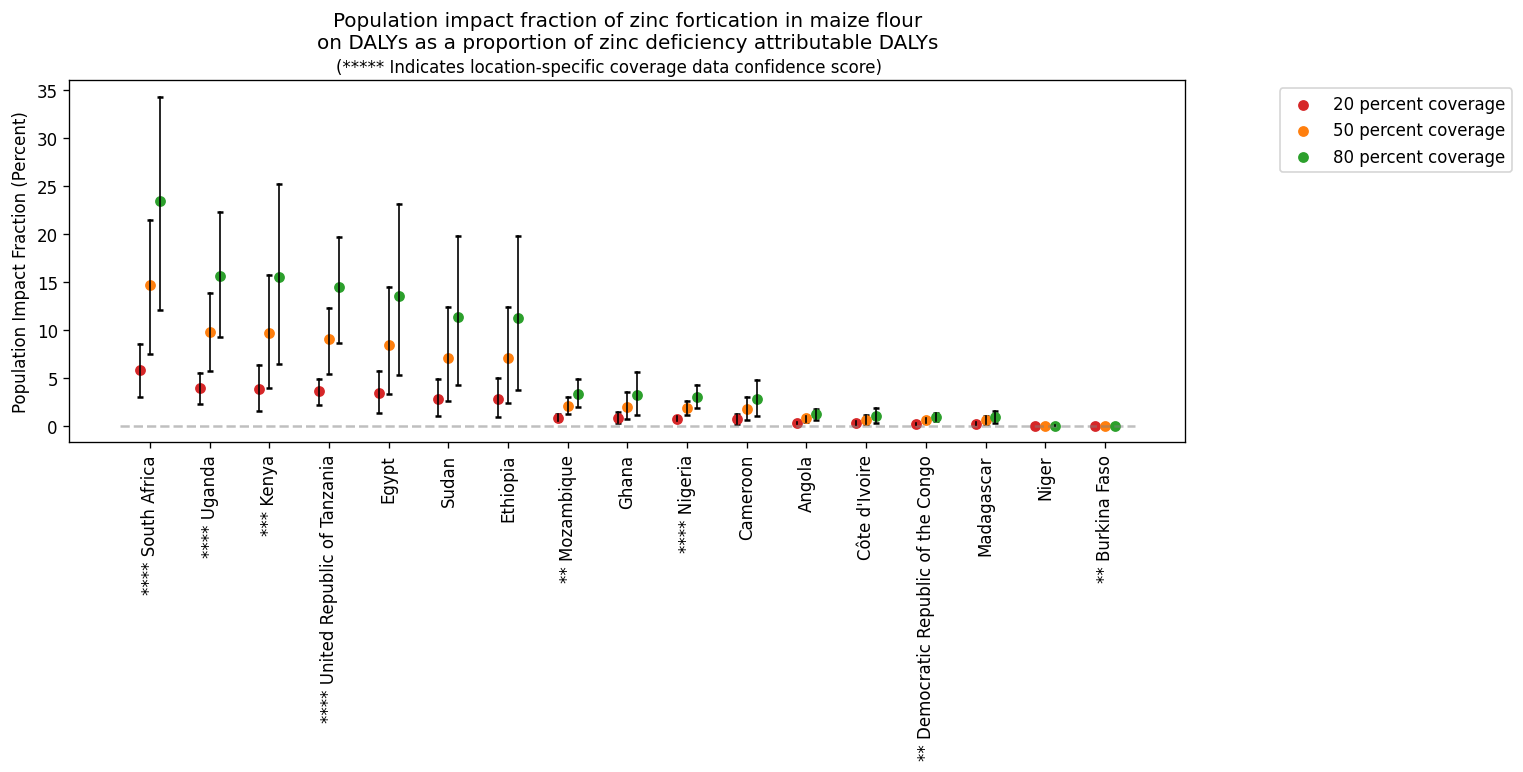

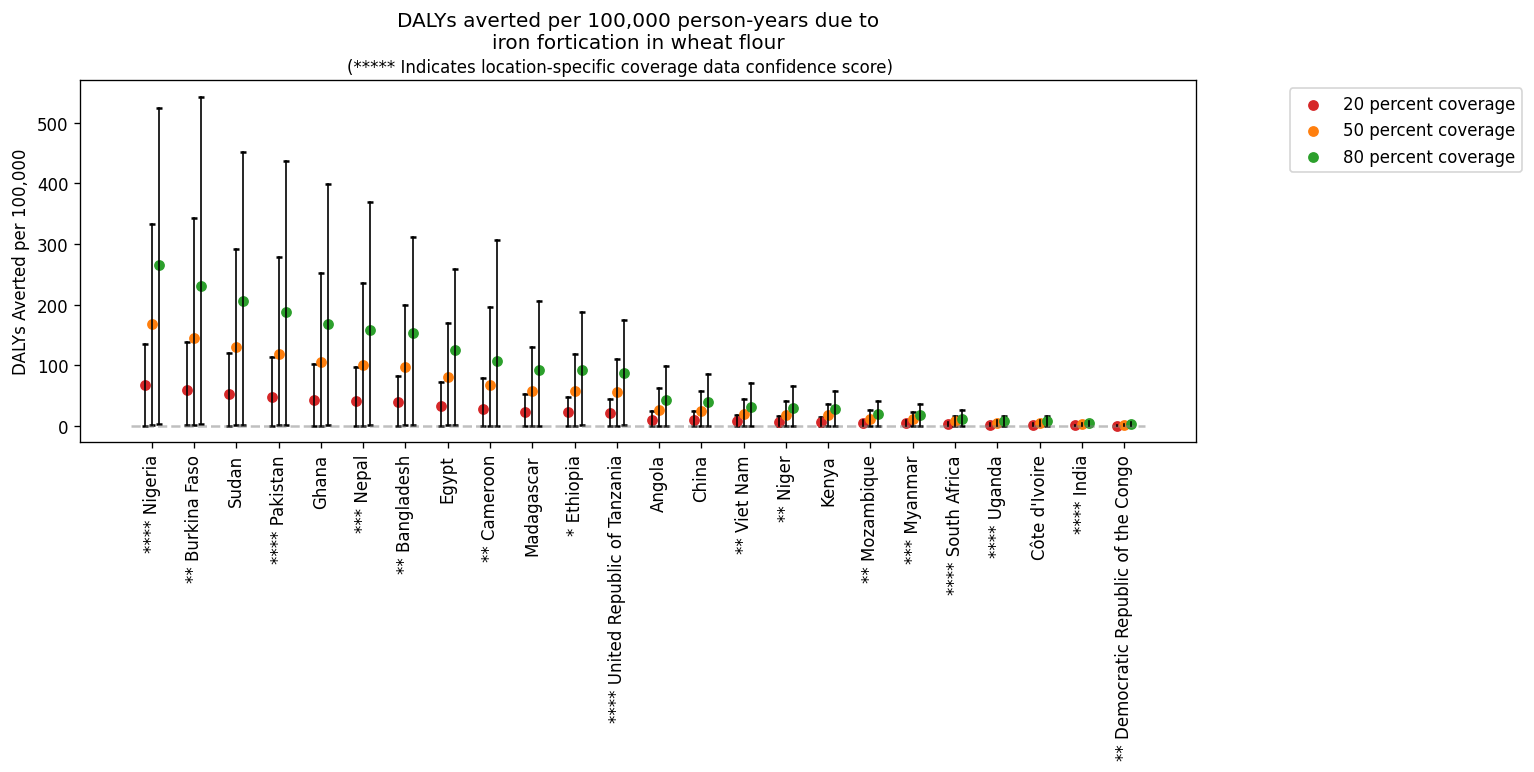

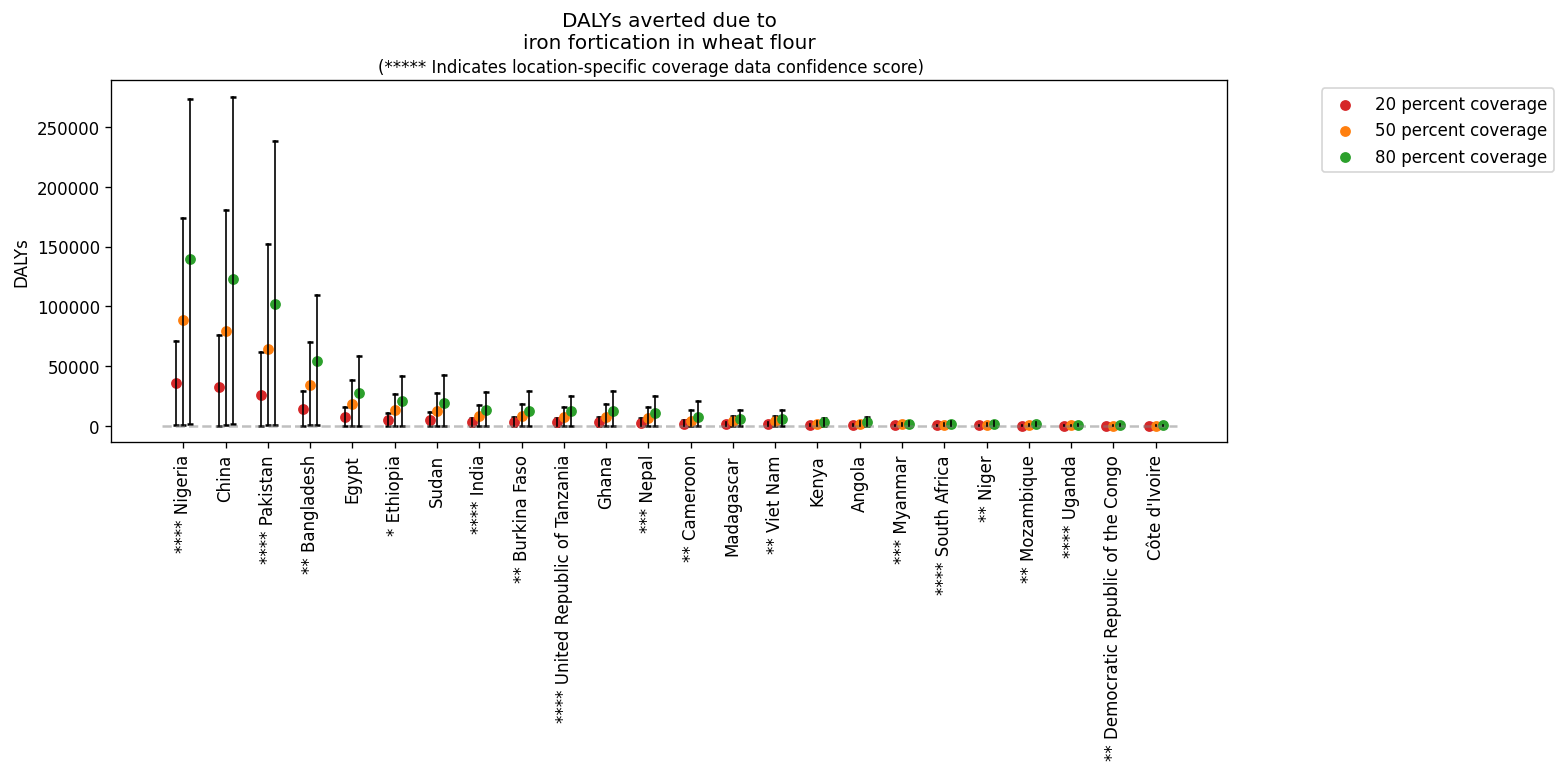

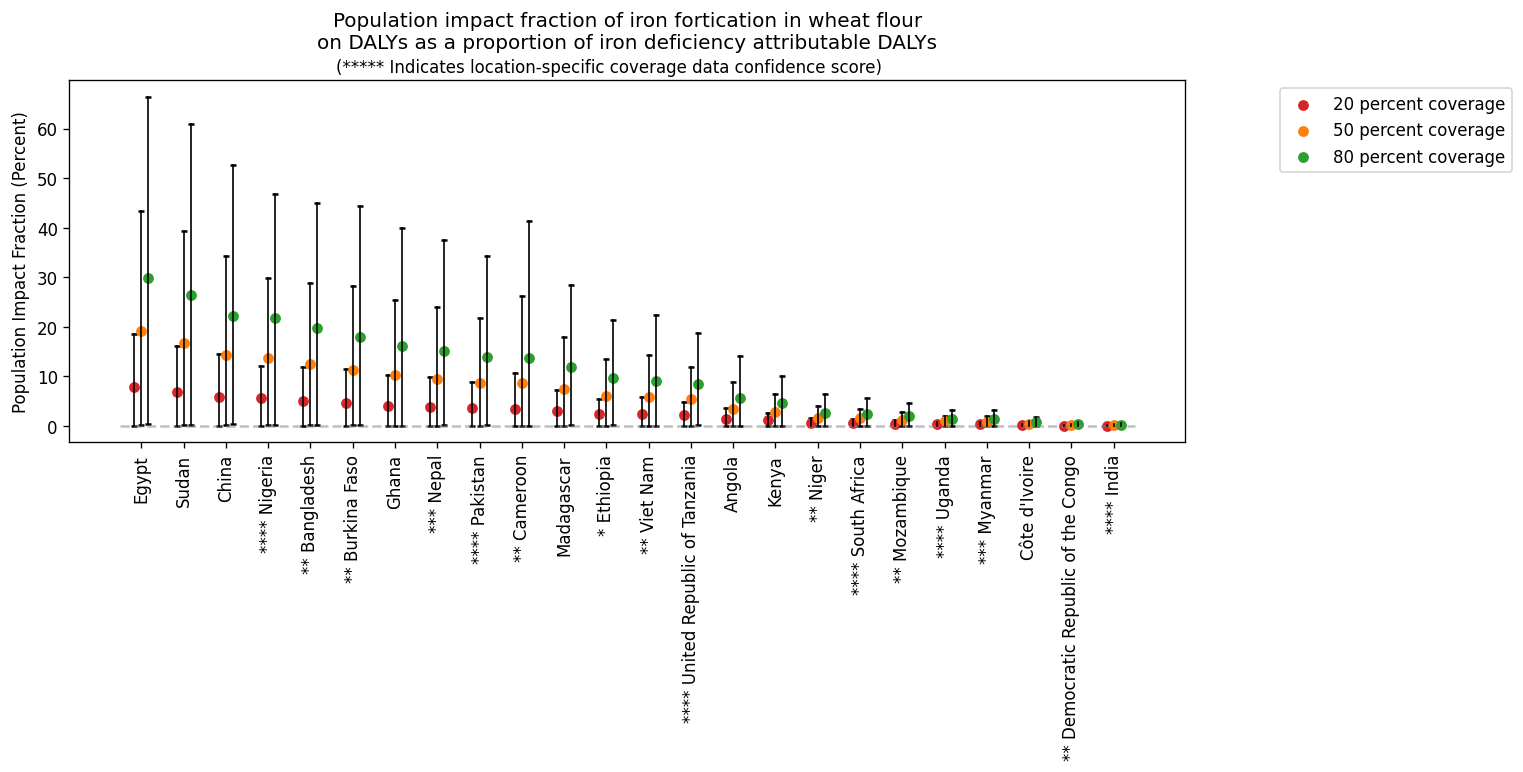

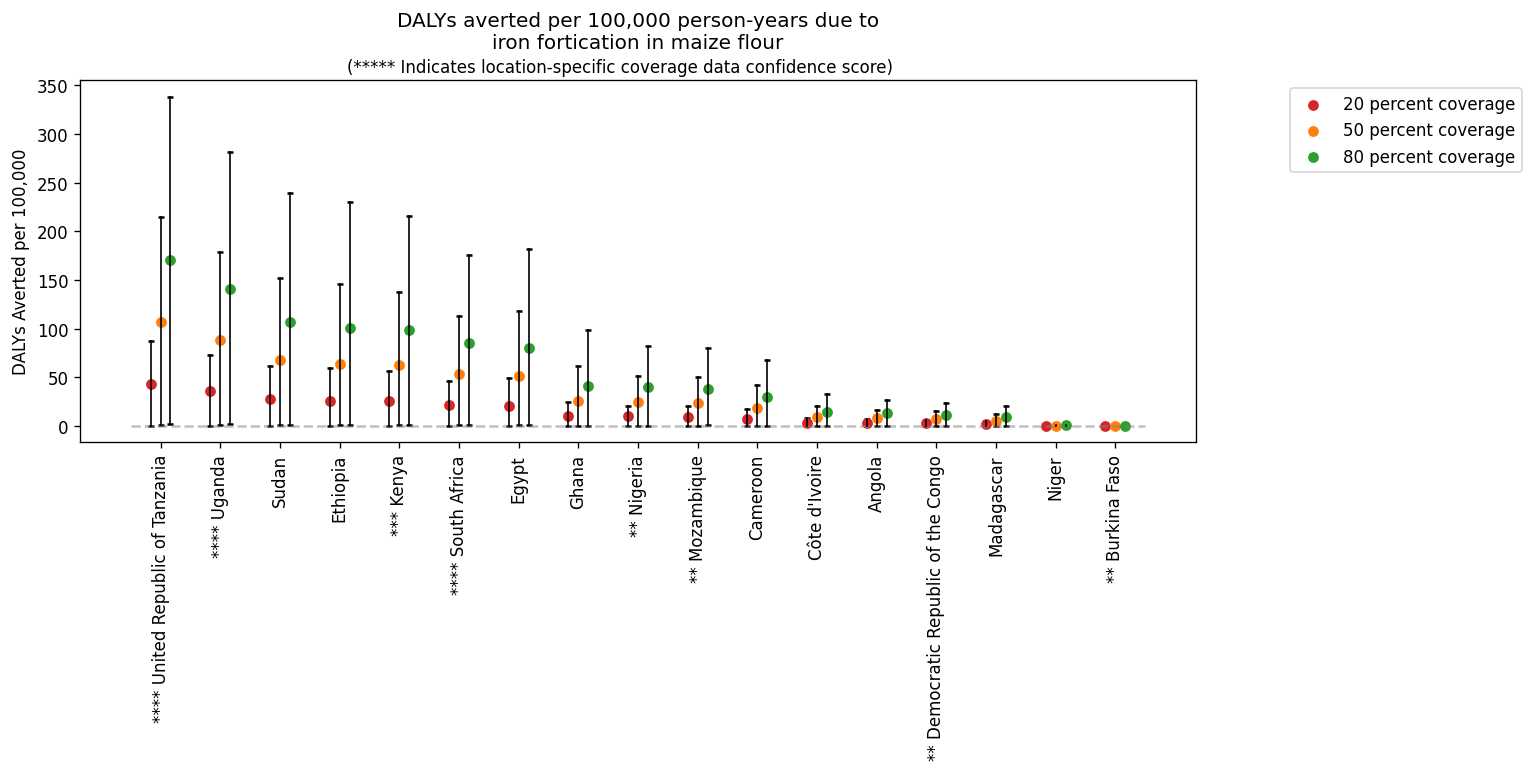

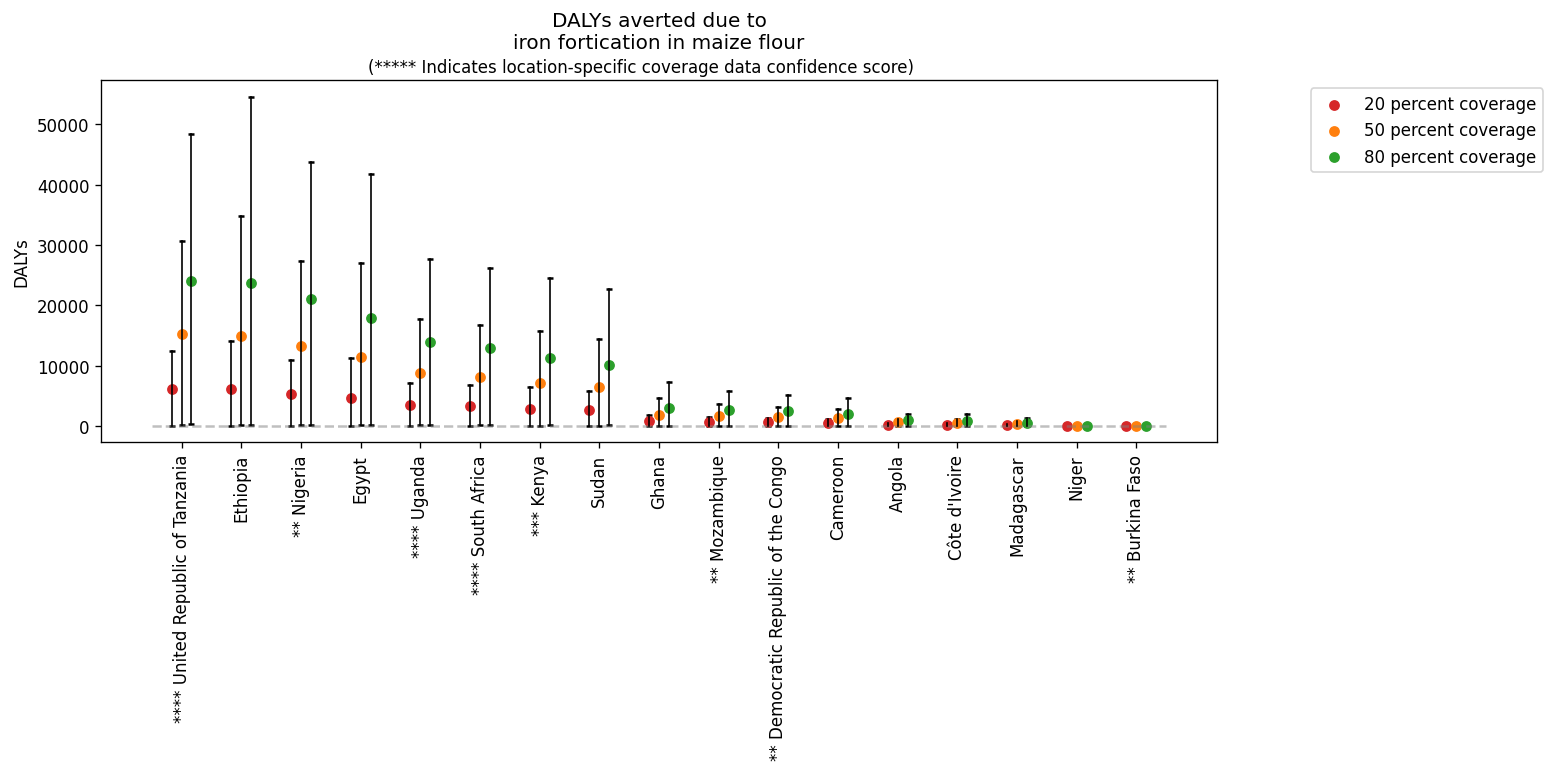

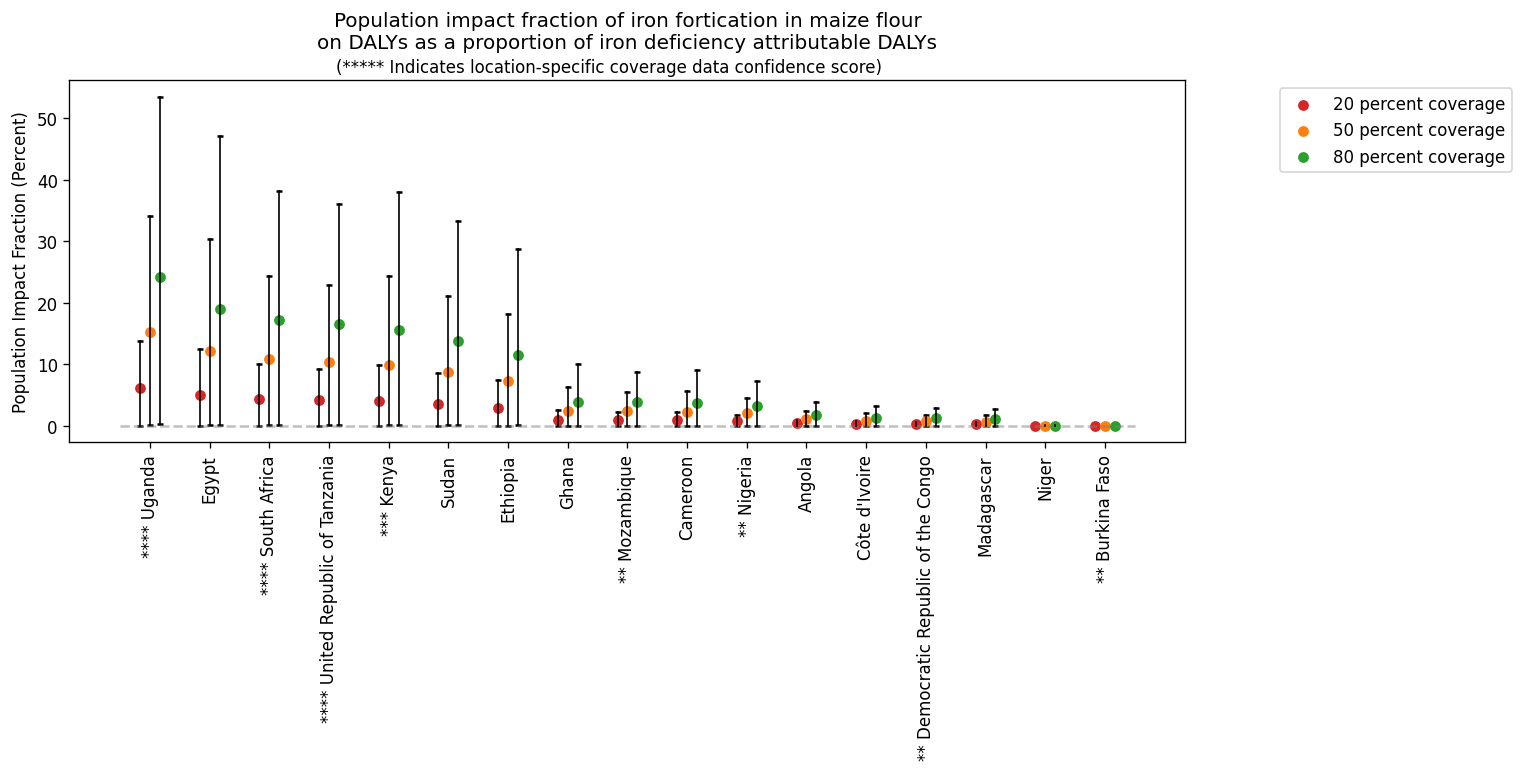

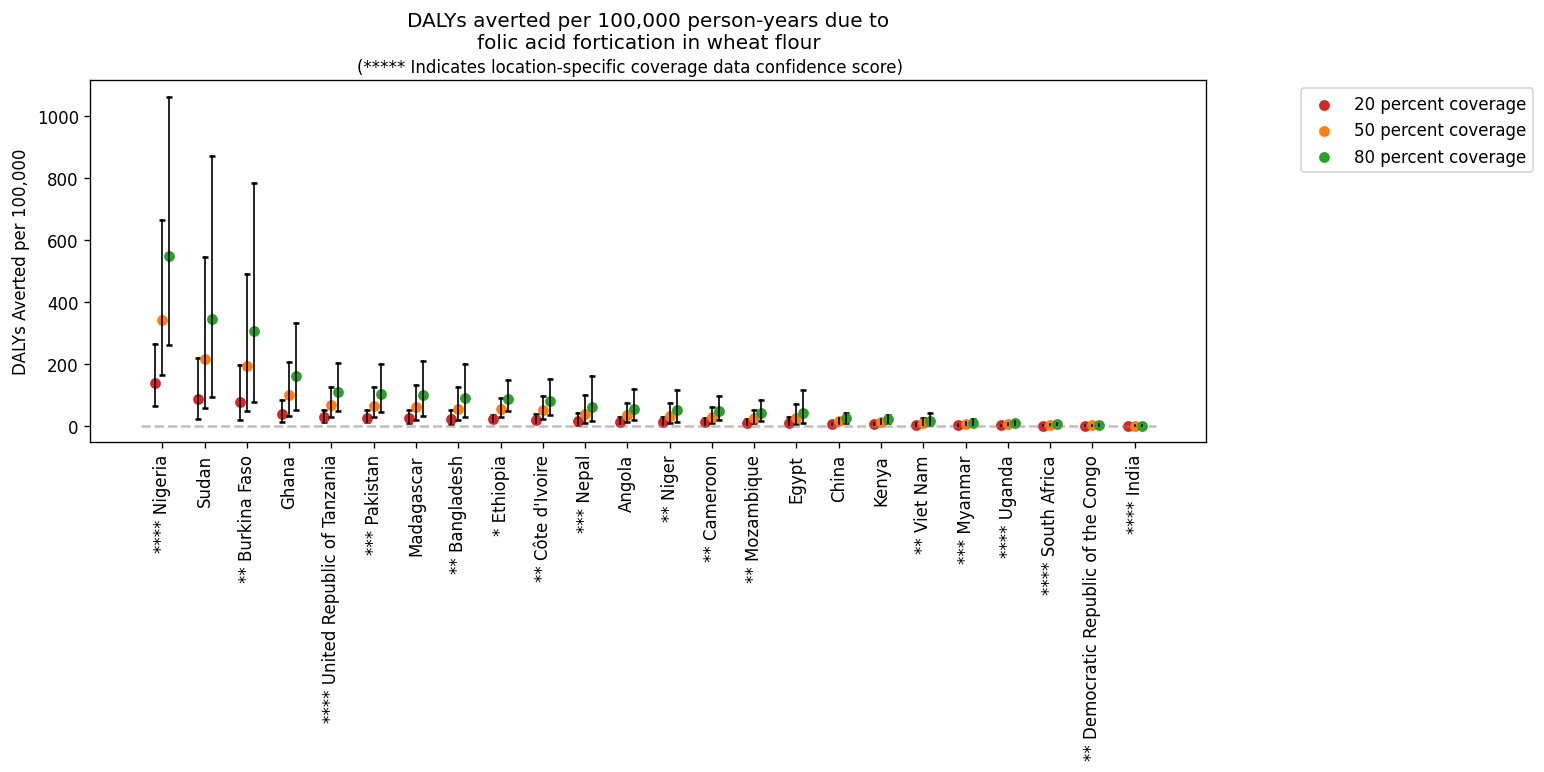

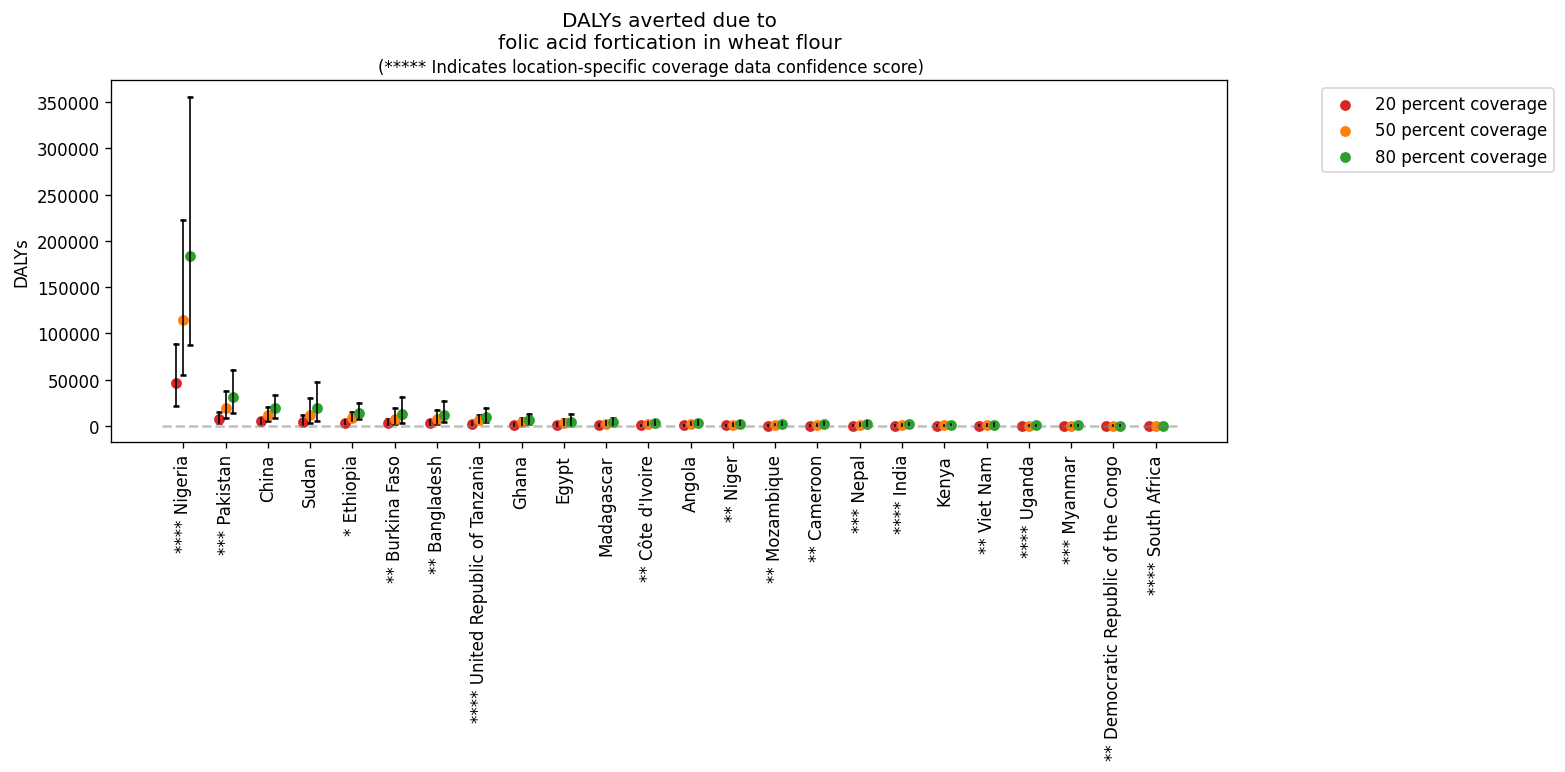

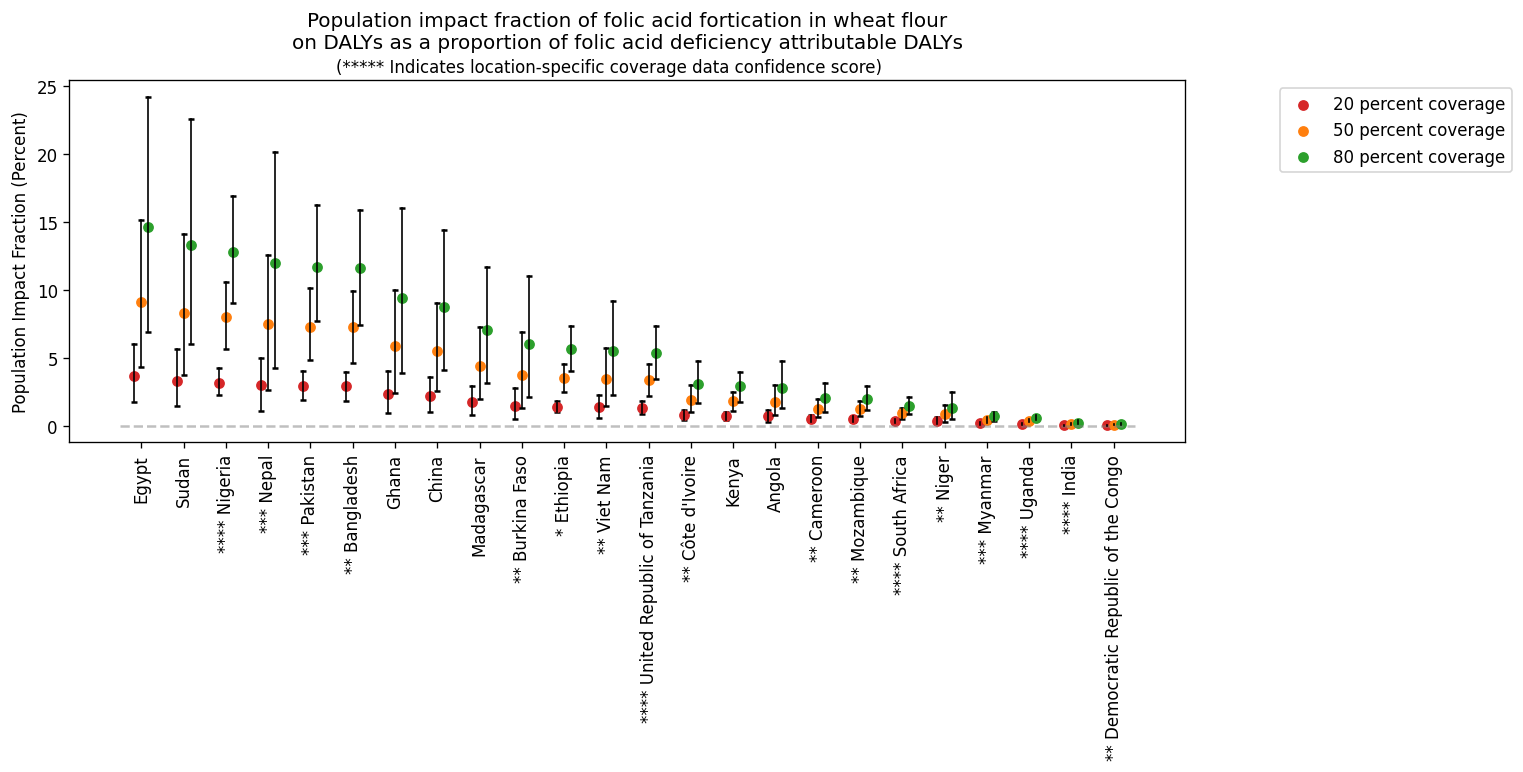

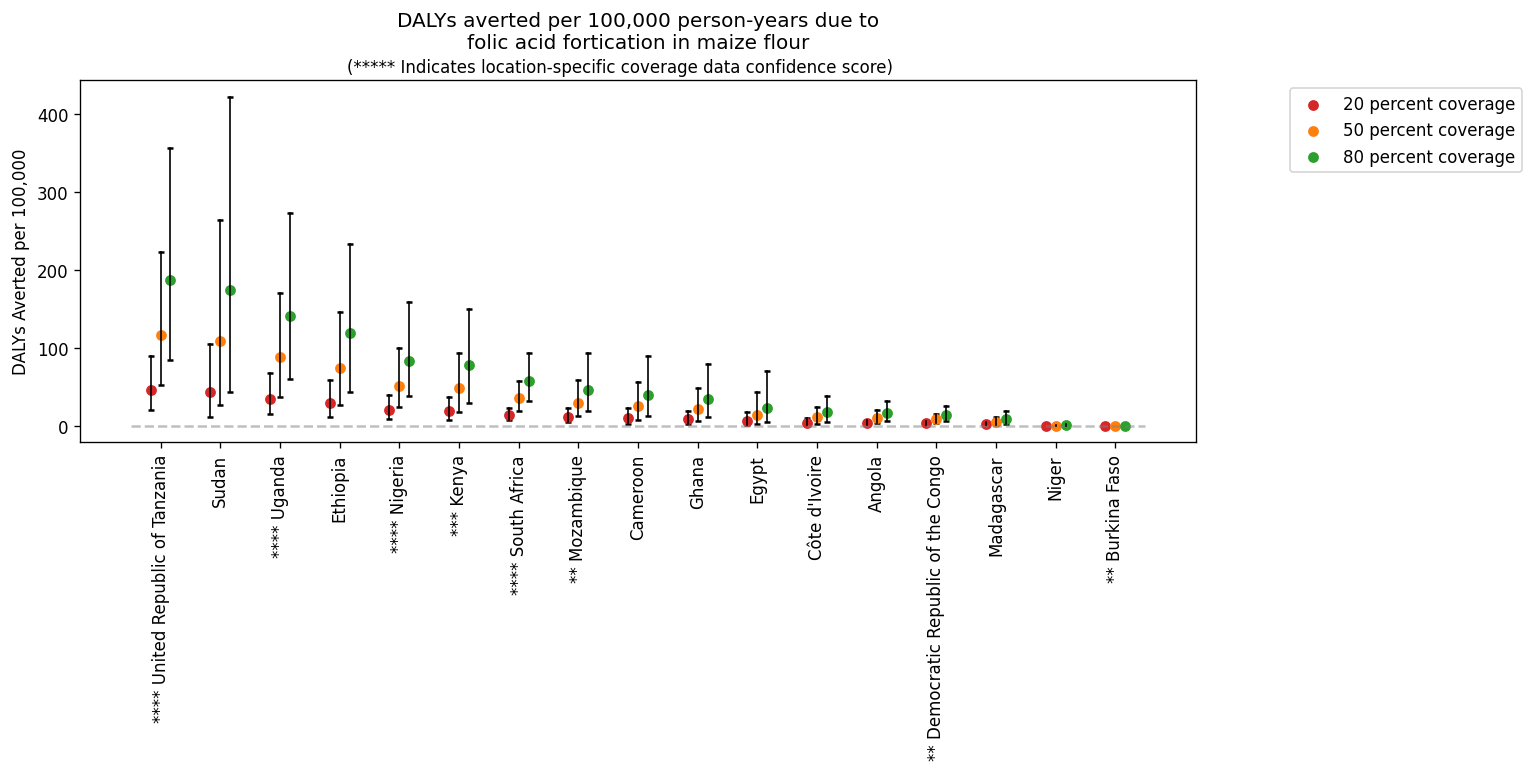

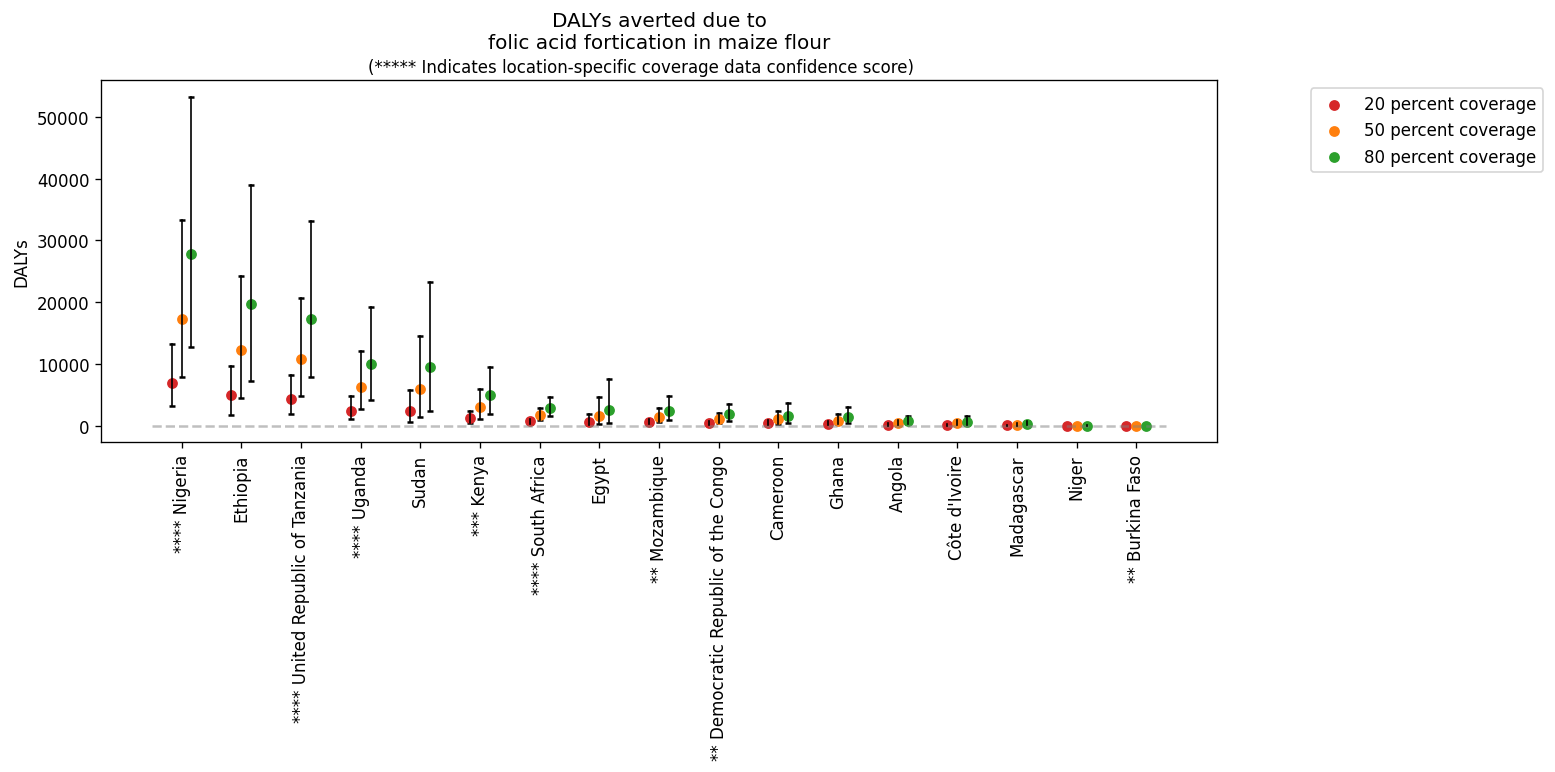

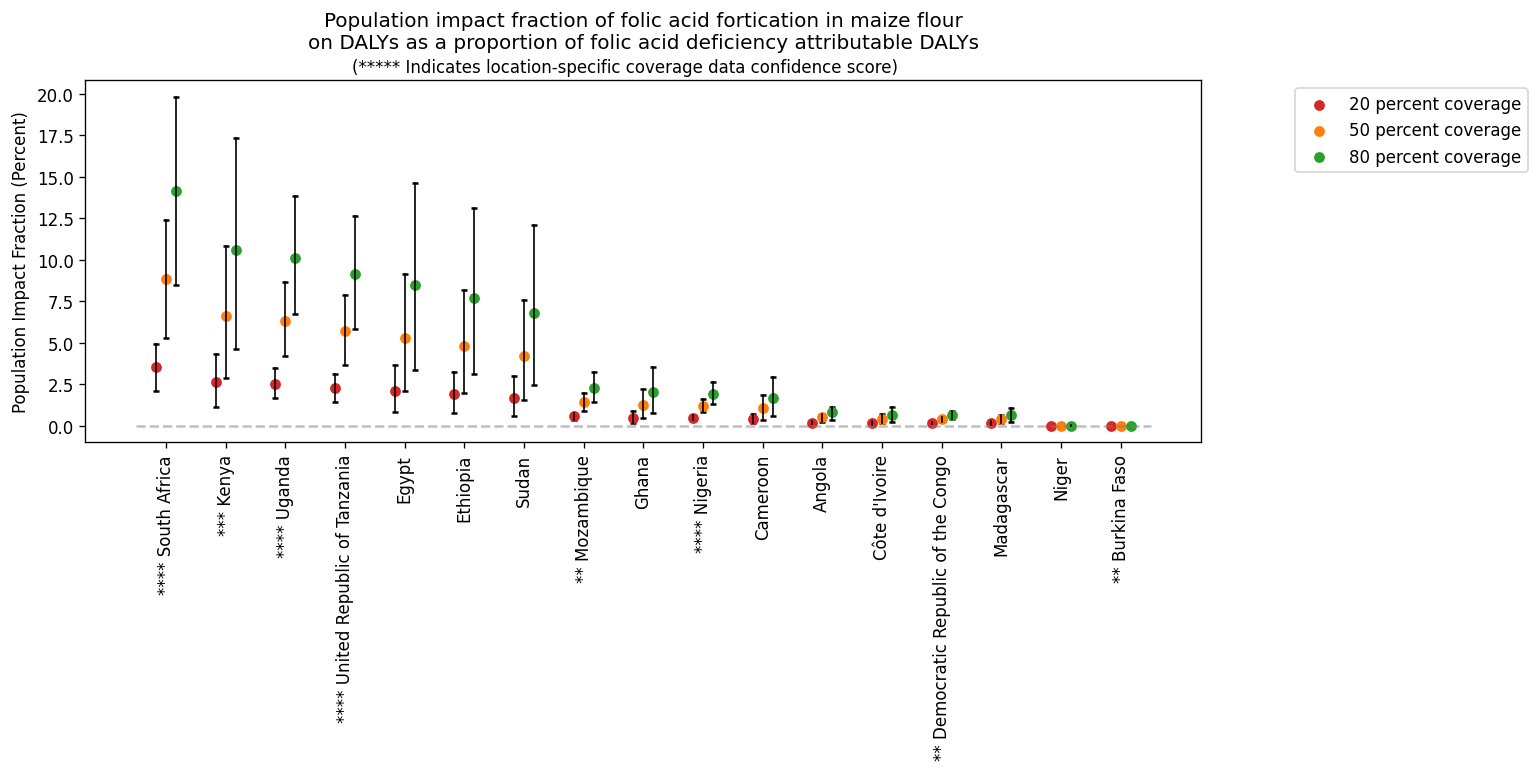

In [160]:
nutrients = ['vitamin A','zinc','iron','folic acid']
measures = ['rates_averted','counts_averted','pif']
coverage_levels = [0.2,0.5,0.8]

with PdfPages('results_plots/impact_by_nutrient_vehicle_pair.pdf') as pdf:
    for nutrient in nutrients:
        if nutrient == 'vitamin A':
            vehicles = ['oil','wheat flour','maize flour']
        else:
            vehicles = ['wheat flour', 'maize flour']
        for vehicle in vehicles:
            for measure in measures:
                plot = (results.loc[results.nutrient == nutrient]
                        .loc[results.vehicle == vehicle]
                        .loc[results.measure == measure]
                        .loc[results.year == 2025]
                        .set_index([c for c in results.columns if 'draw' not in c]))
                make_dot_plots_by_nutrient_vehicle_pair(plot,
                              nutrient,
                              measure,
                              coverage_levels,
                              confidence)
                pdf.savefig(bbox_inches='tight')

In [161]:
coverage_levels = [0.2,0.5,0.8]

def make_location_specific_plots(data, location_id, measure, coverage_levels):
    data_loc = (data
                .loc[data.location_id==location_id]
                .loc[data.year==2025]
                .loc[data.measure == measure]
                .sort_values(by=['nutrient','vehicle']))
    
    f, ax = plt.subplots(figsize=(7, 4), dpi=120)
    colors = ['tab:red', 'tab:orange', 'tab:green']
    nutrient_spacer = 0.15
    coverage_spacer = 0.025
    data_loc = (data_loc.set_index([c for c in data_loc.columns if 'draw' not in c])
                .apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).reset_index())
    
    for n in list(range(0, len(coverage_levels))):
        df = (data_loc.loc[data_loc.coverage_level == coverage_levels[n]])
        for i in list(range(0, len(df))):
            plt.plot([nutrient_spacer * i + coverage_spacer * n, nutrient_spacer * i + coverage_spacer * n],
                     [df['2.5%'].values[i], df['97.5%'].values[i]], c='black', linewidth=1)
            plt.scatter([nutrient_spacer * i + coverage_spacer * n], df['2.5%'].values[i], s=10, marker='_',
                        c='black')
            plt.scatter([nutrient_spacer * i + coverage_spacer * n], df['97.5%'].values[i], s=10, marker='_',
                        c='black')
            
        x_vals = []
        for x in list(range(0, len(df))):
            x_vals.append(nutrient_spacer * x + coverage_spacer * n)
        plt.scatter(x_vals, df['mean'], s=30,
                    label=f'{int(coverage_levels[n] * 100)} percent coverage', color=colors[n])

    plt.hlines(0, 0 - coverage_spacer * 2,
               nutrient_spacer * (len(df)) - coverage_spacer * 2,
               linestyle='dashed', color='grey', alpha=0.5)
    
    plt.plot()
    
    l_name = data_loc.location_name.values[0]

    if measure == 'rates_averted':
        plt.title(f'{l_name}\nDALYs Averted per 100,000 Person-Years by Nutrient')
        plt.ylabel('DALYs Averted per 100,000')
    elif measure == 'counts_averted':
        plt.title(f'{l_name}\nDALYs Averted by Nutrient')
        plt.ylabel('DALYs')
    elif measure == 'pif':
        plt.title(f'{l_name}\nPopulation Impact Fractions by Nutrient\nDALYs Averted as a Fraction of DALYs Attributable to Respective Nutrient Deficiencies')
        plt.ylabel('Population Impact Fraction (Percent)')

    plt.legend(bbox_to_anchor=[1.5, 1])
    
    x_ticks = []
    for x in list(range(0, len(df))):
        x_ticks.append(nutrient_spacer * x + coverage_spacer)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(df.reset_index().label.values)
    plt.xticks(rotation=90)

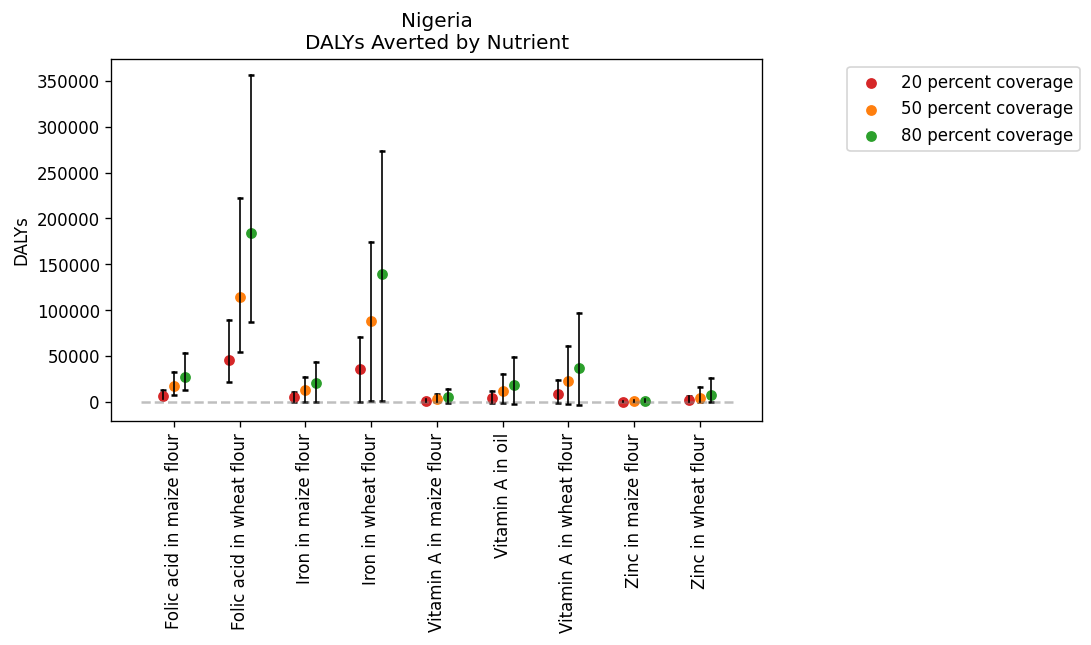

In [162]:
nutrient='vitamin A'
vehicle = 'oil'
measure = 'counts_averted'

plot = (results.loc[results.nutrient == nutrient]
        .loc[results.vehicle == vehicle]
        .loc[results.measure == measure]
        .loc[results.year == 2025]
        .set_index([c for c in results.columns if 'draw' not in c]))
make_location_specific_plots(results, 214, measure, coverage_levels)

/ihme/code/central_comp/miniconda_svc-ccomp/envs/v108/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


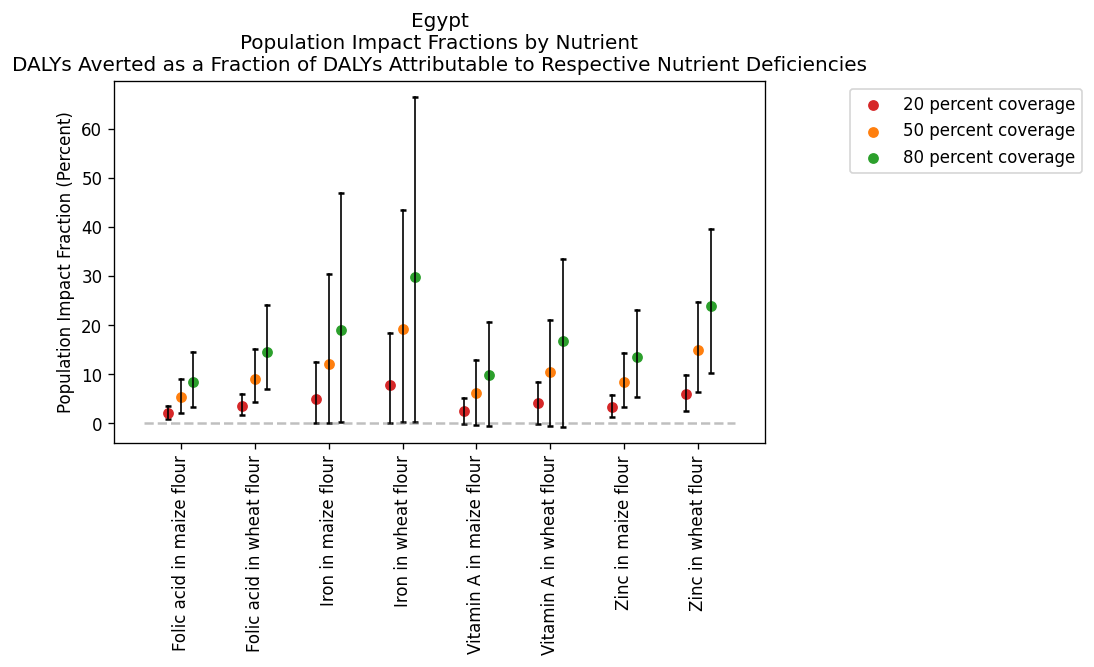

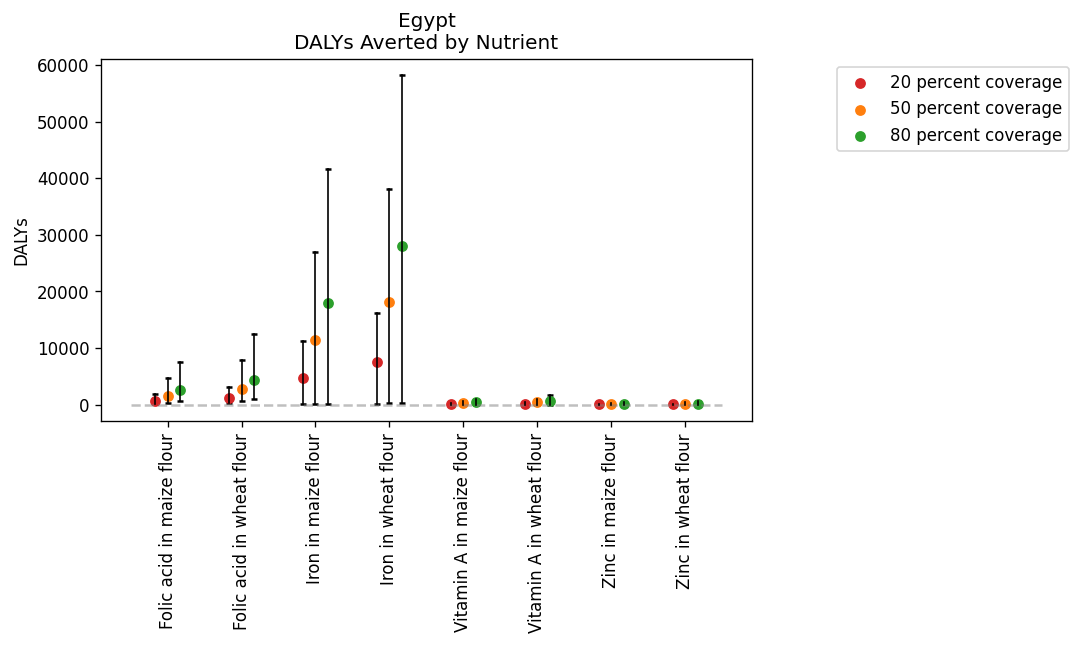

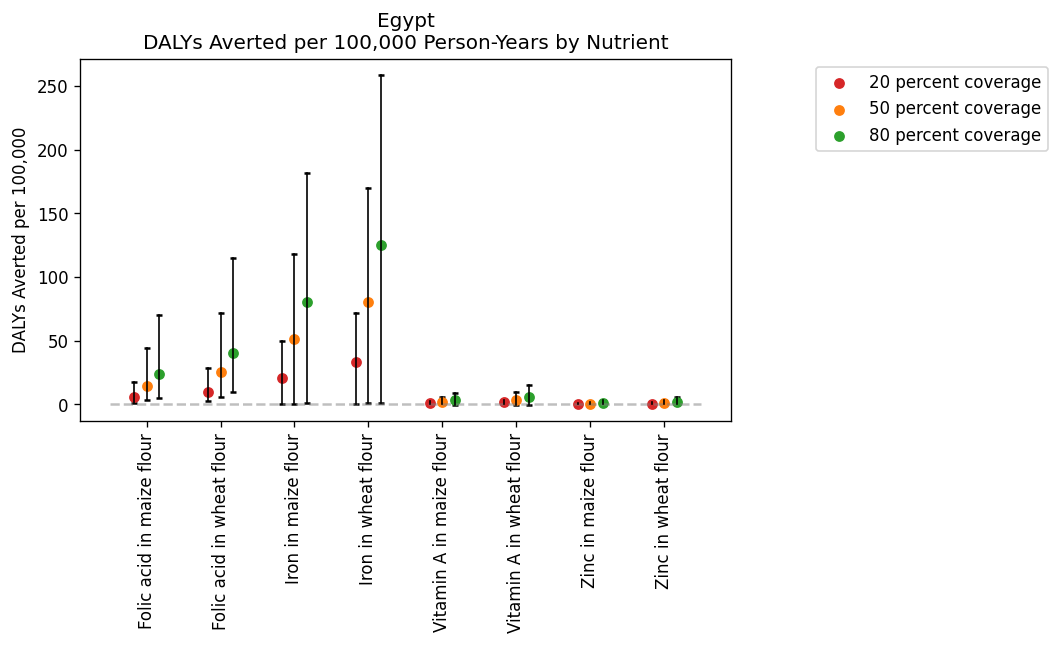

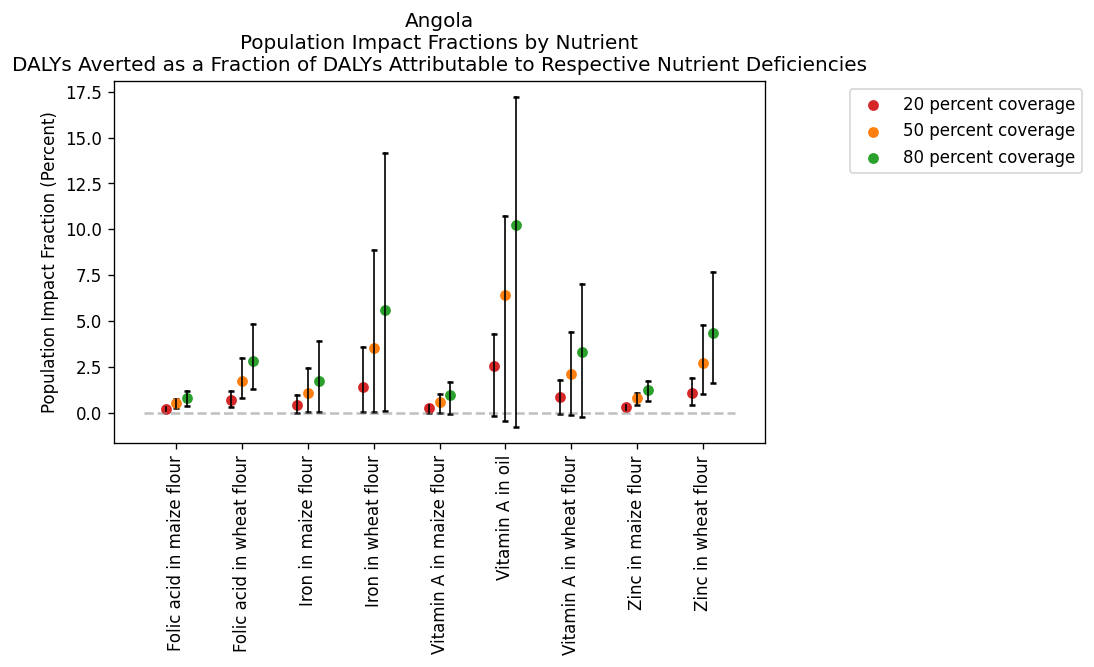

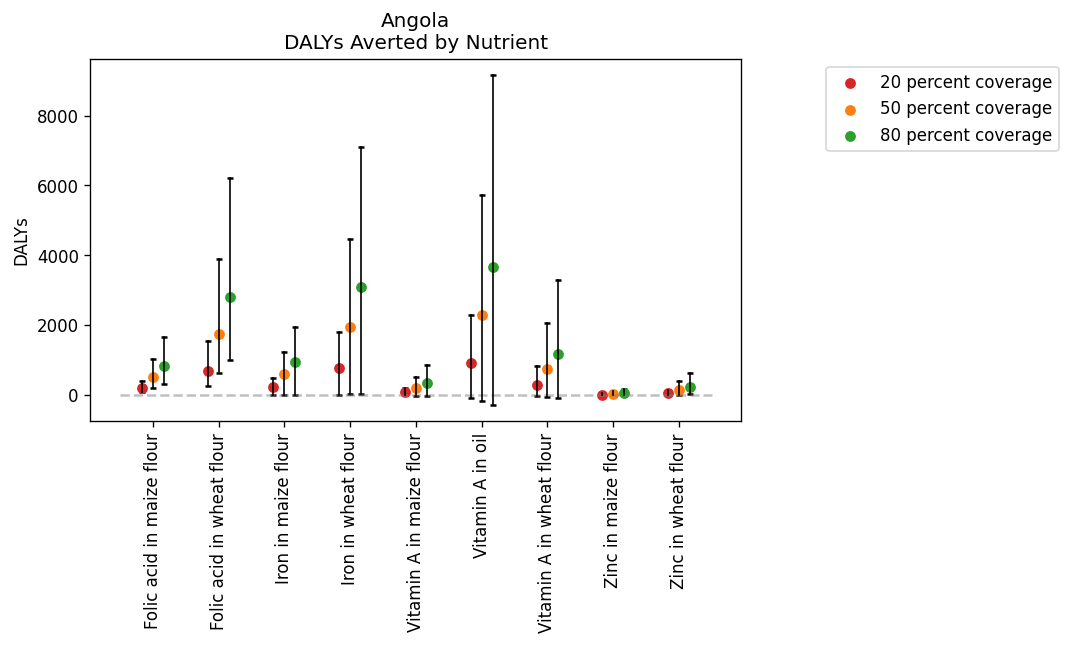

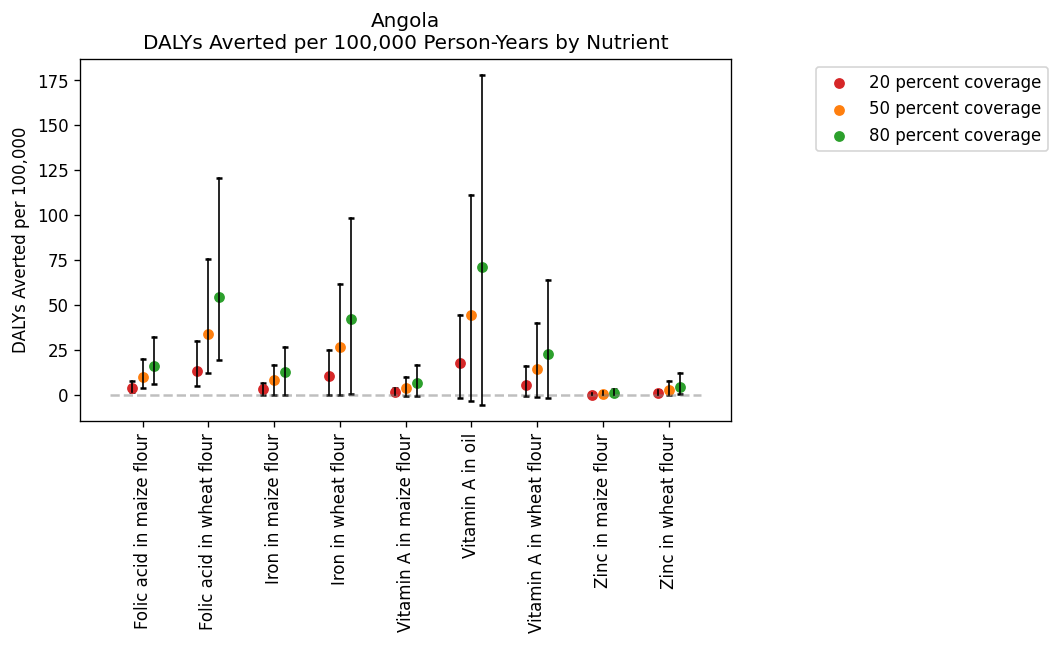

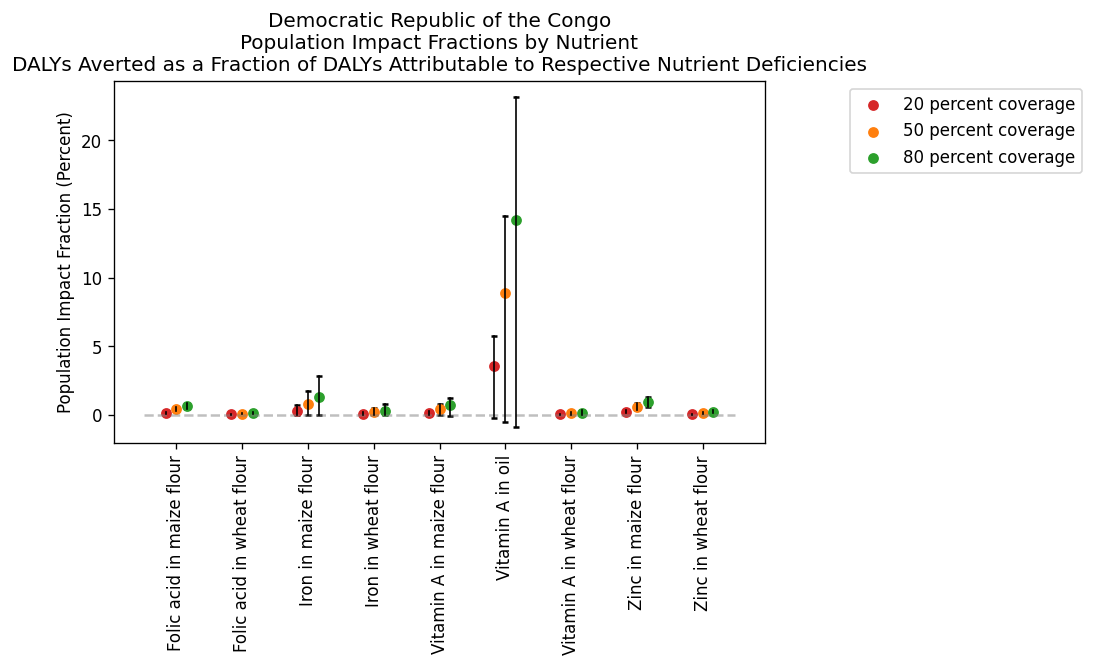

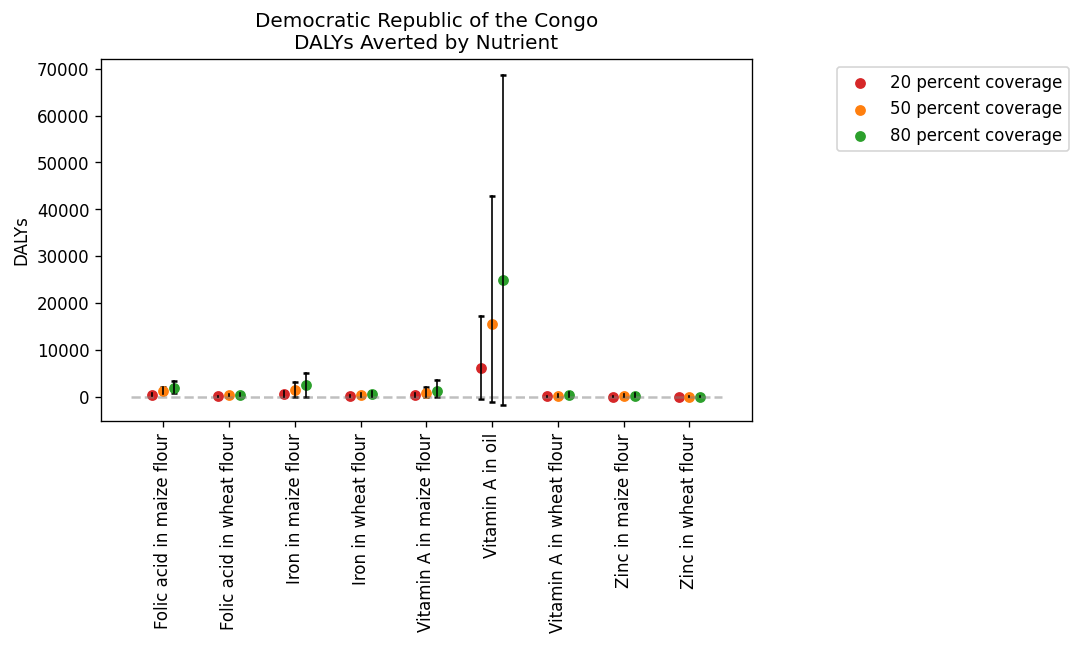

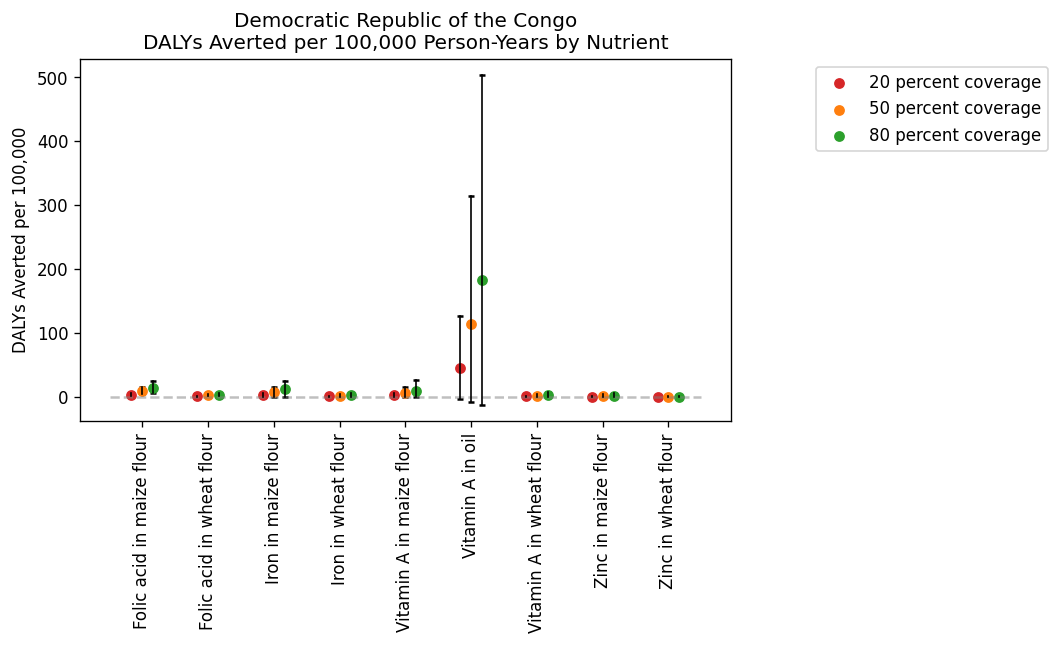

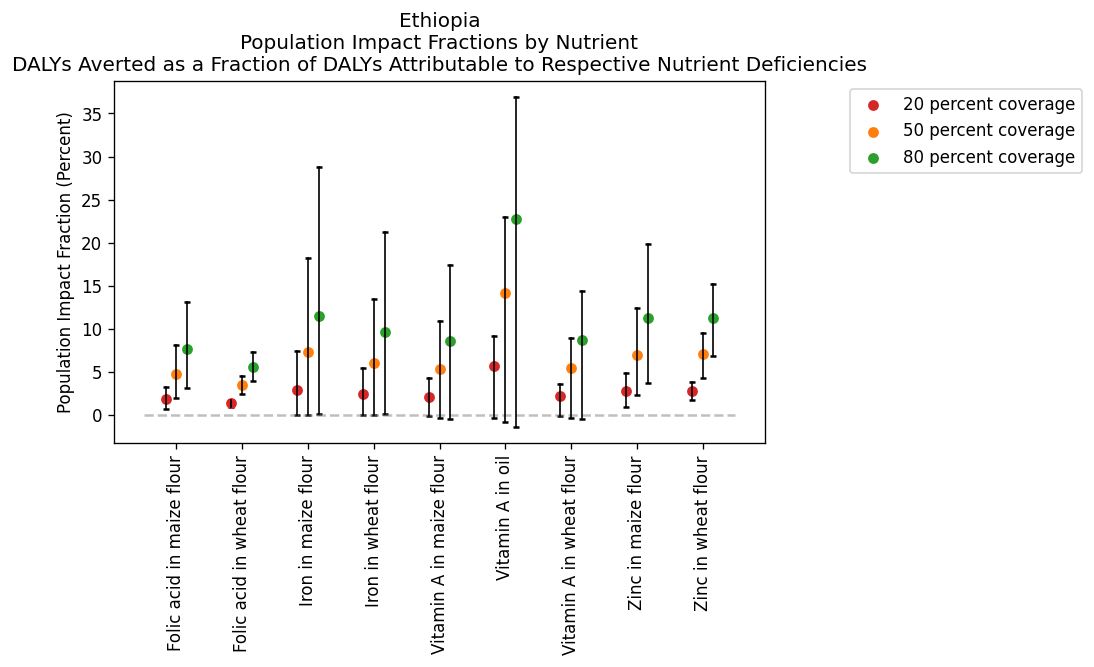

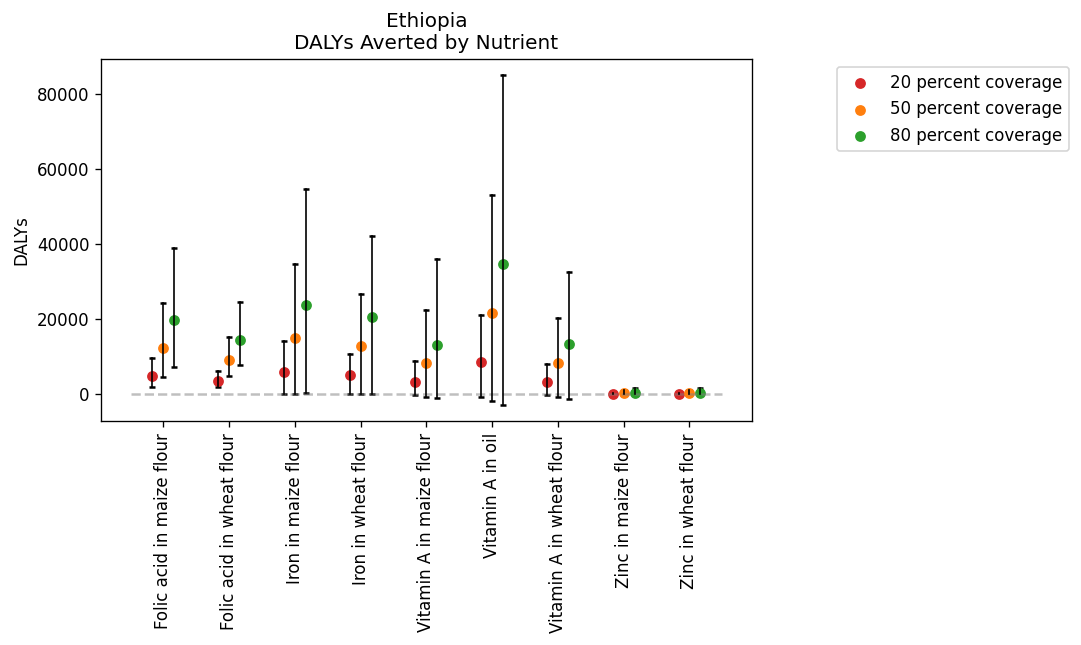

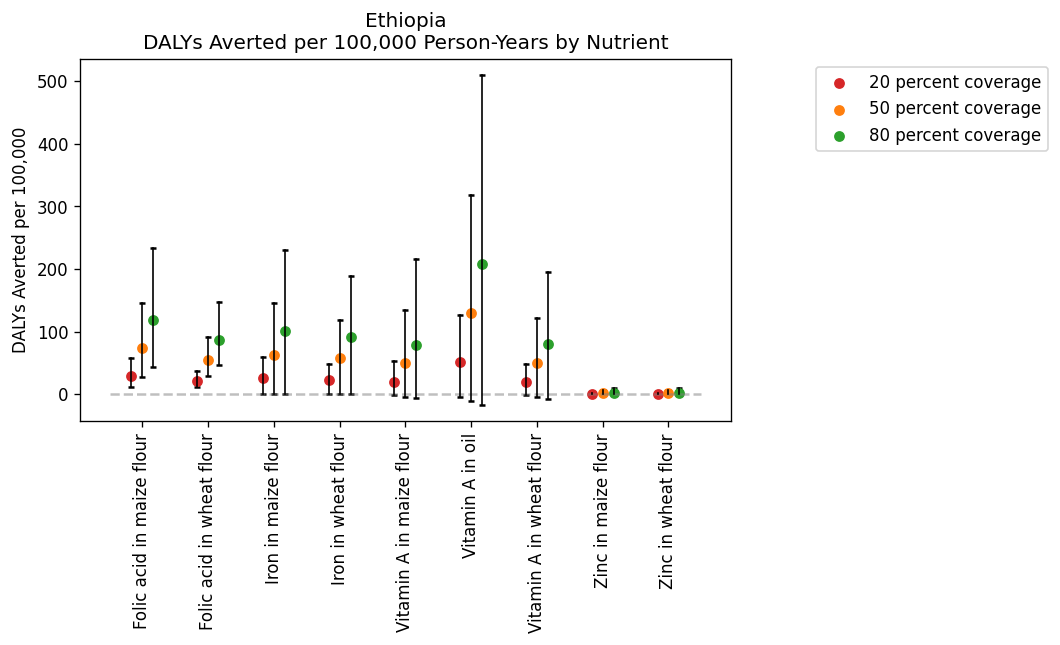

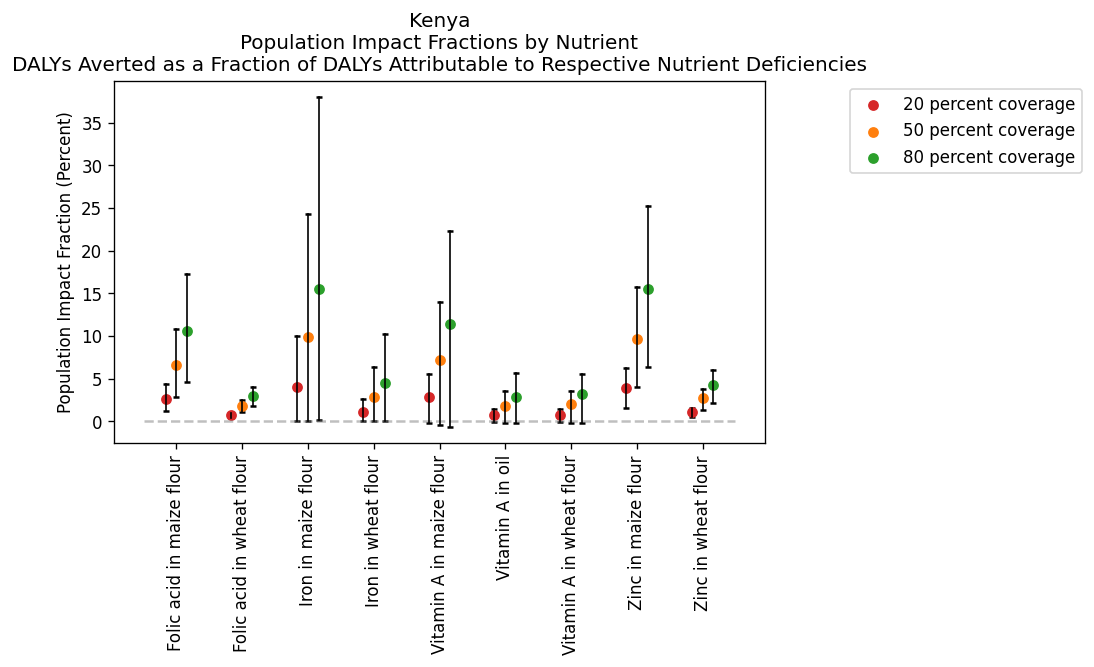

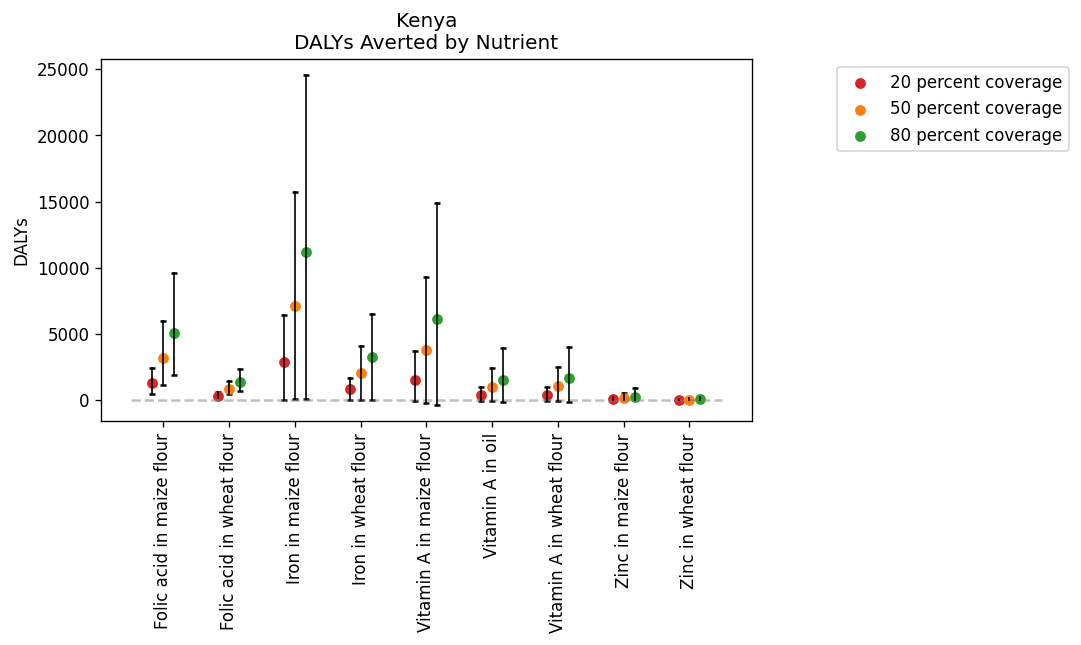

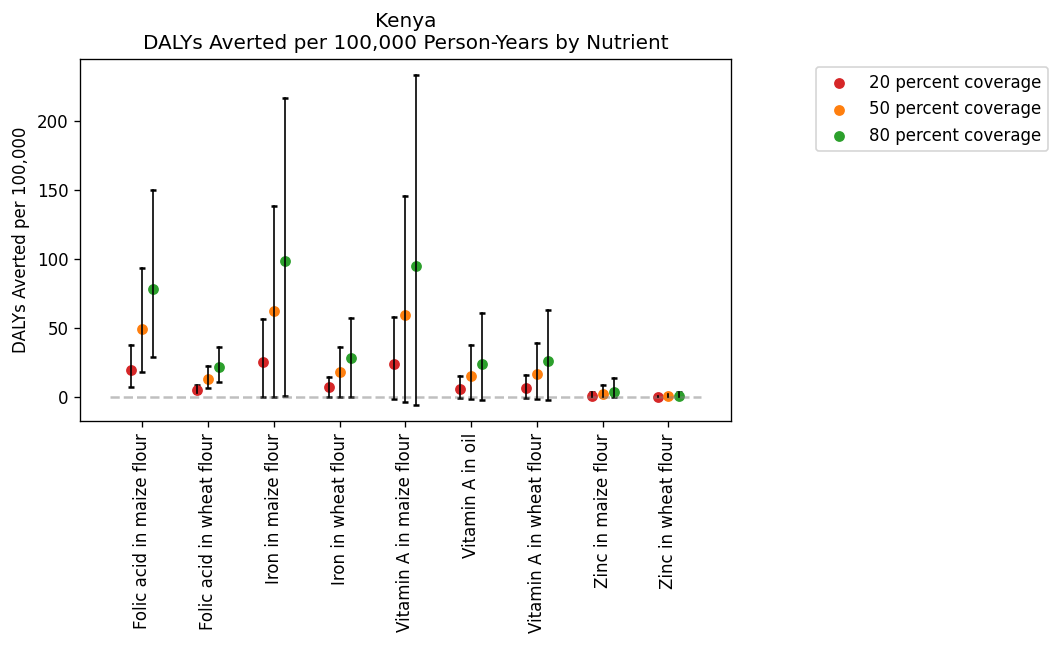

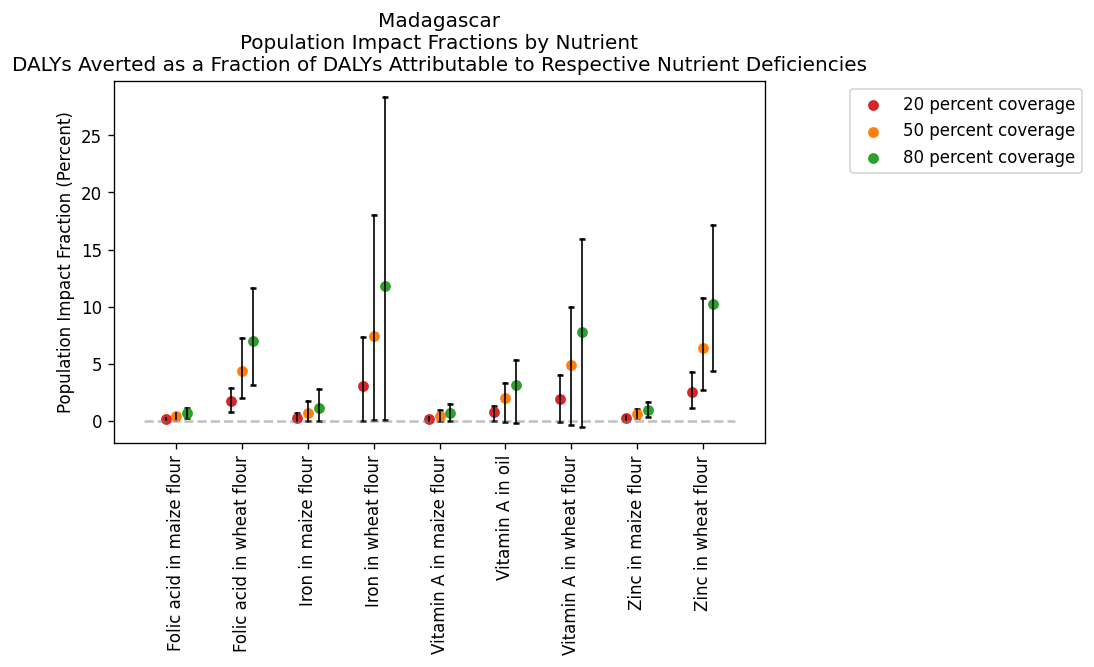

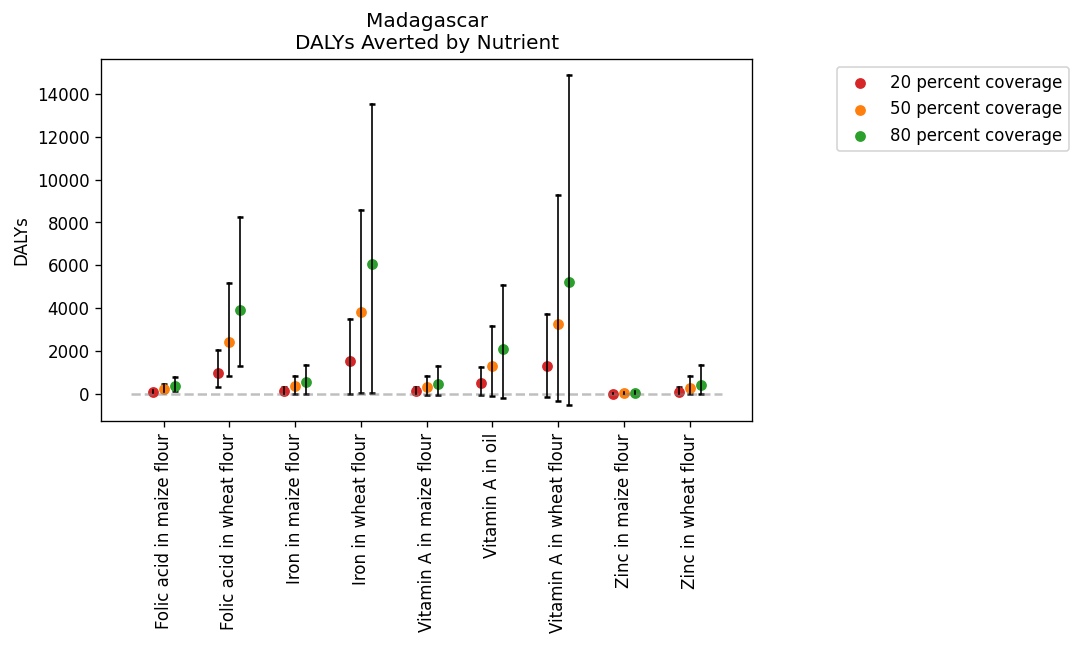

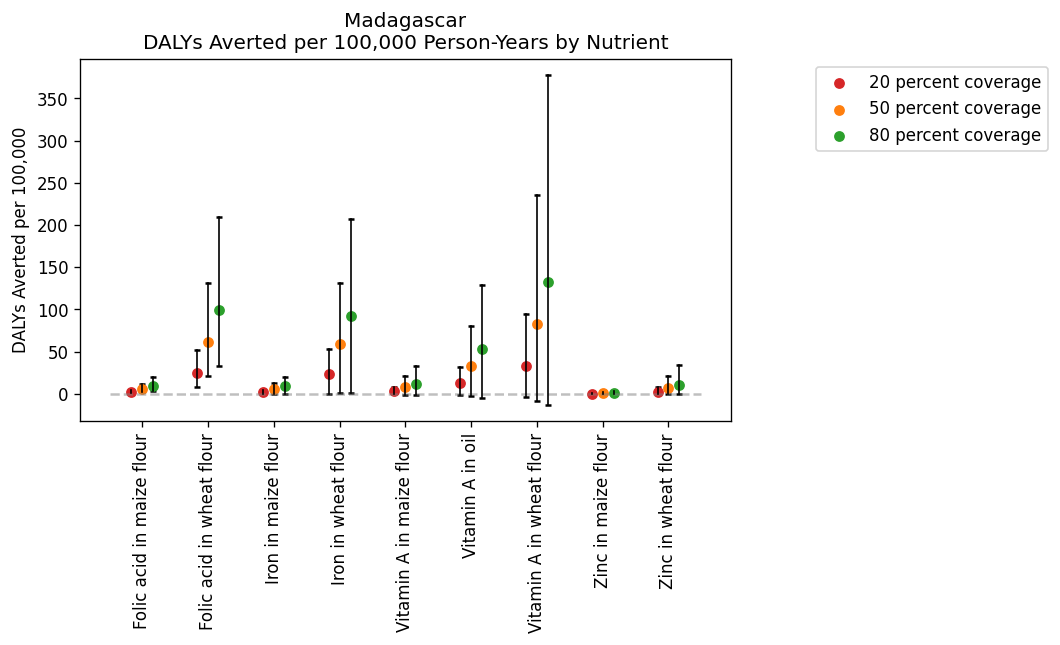

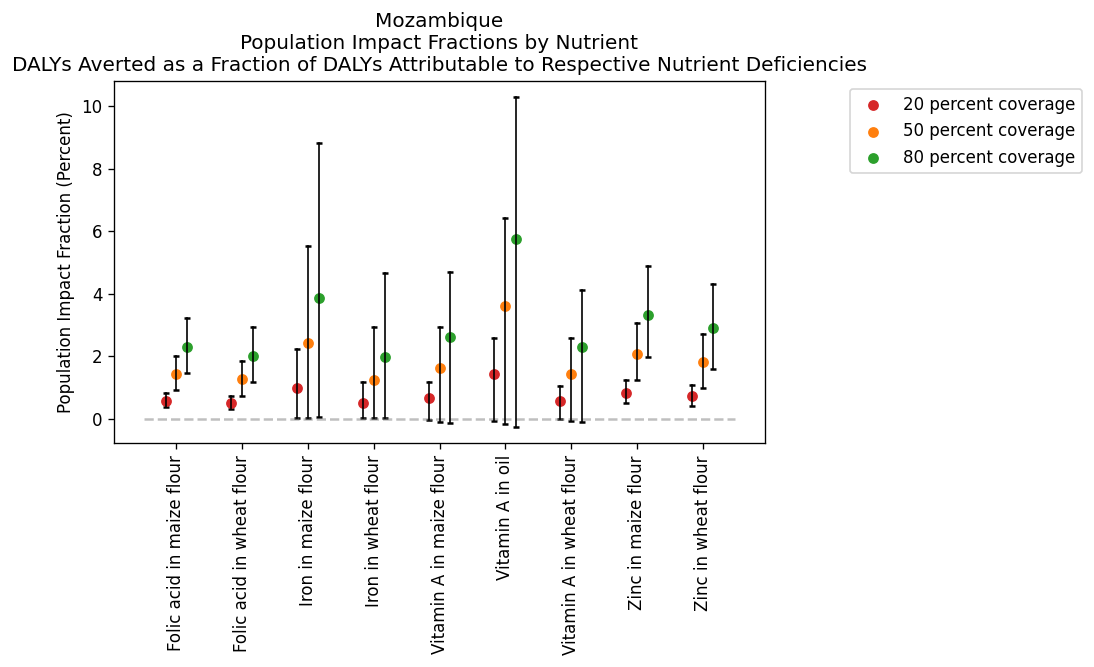

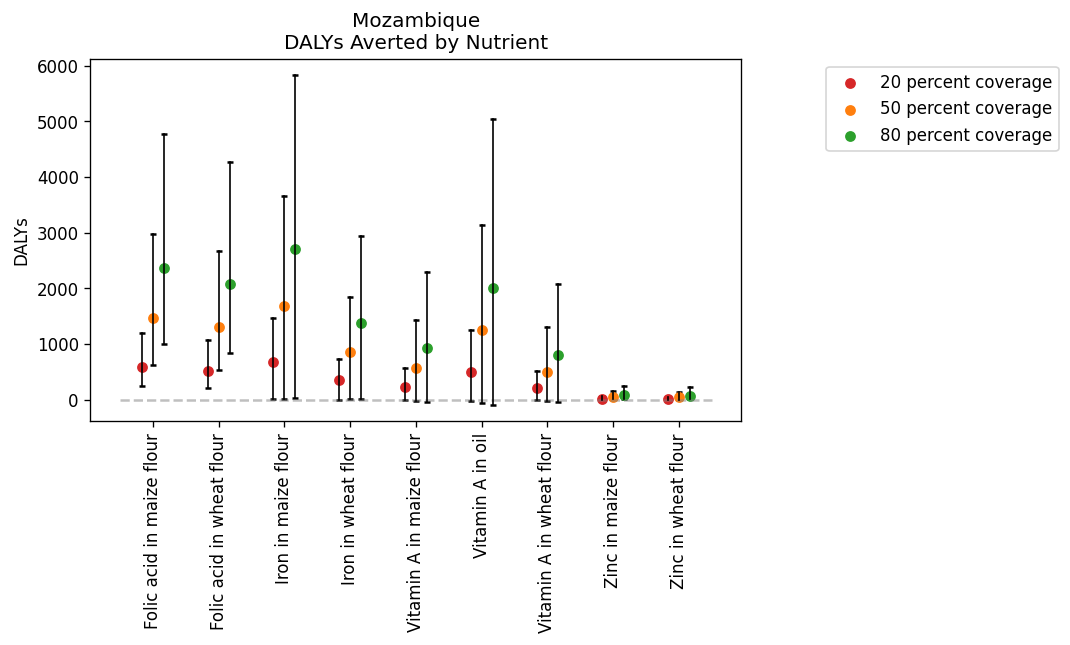

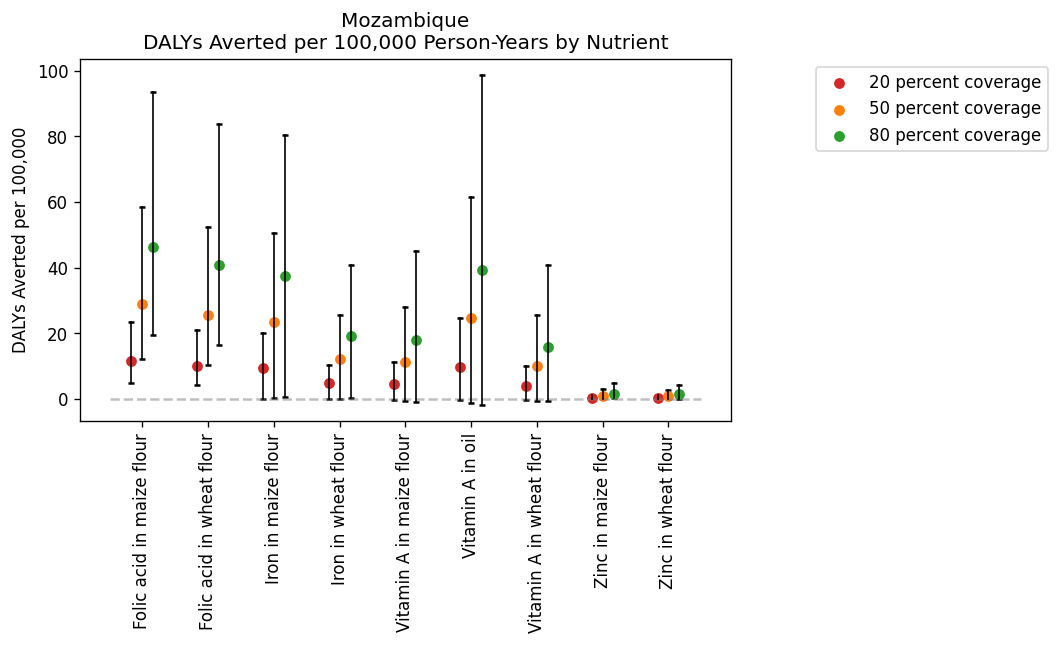

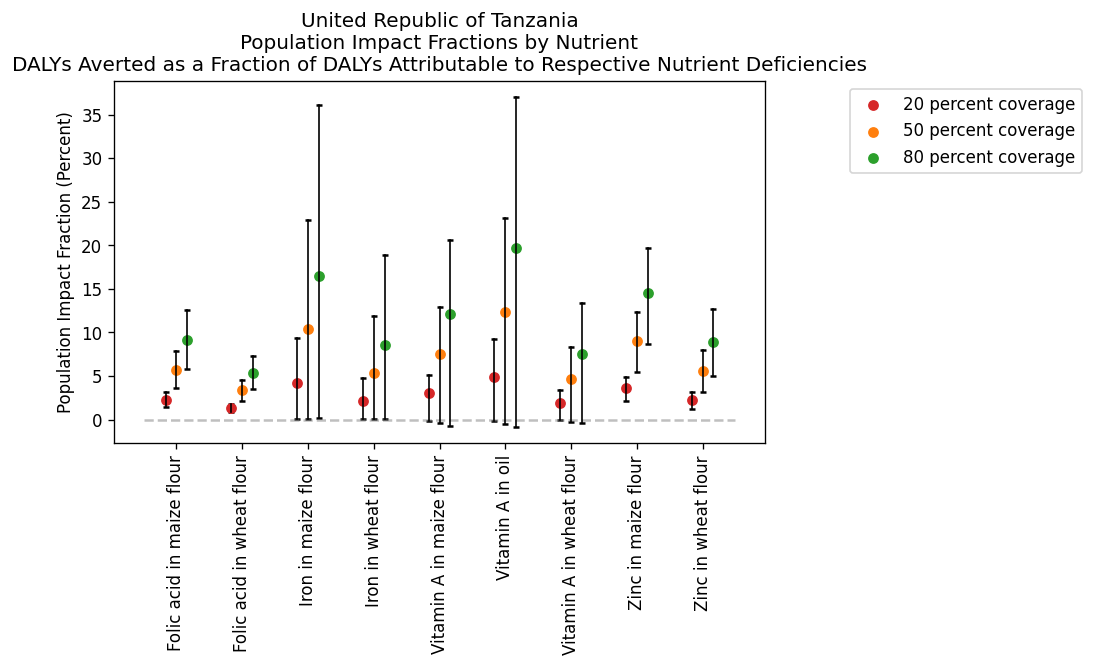

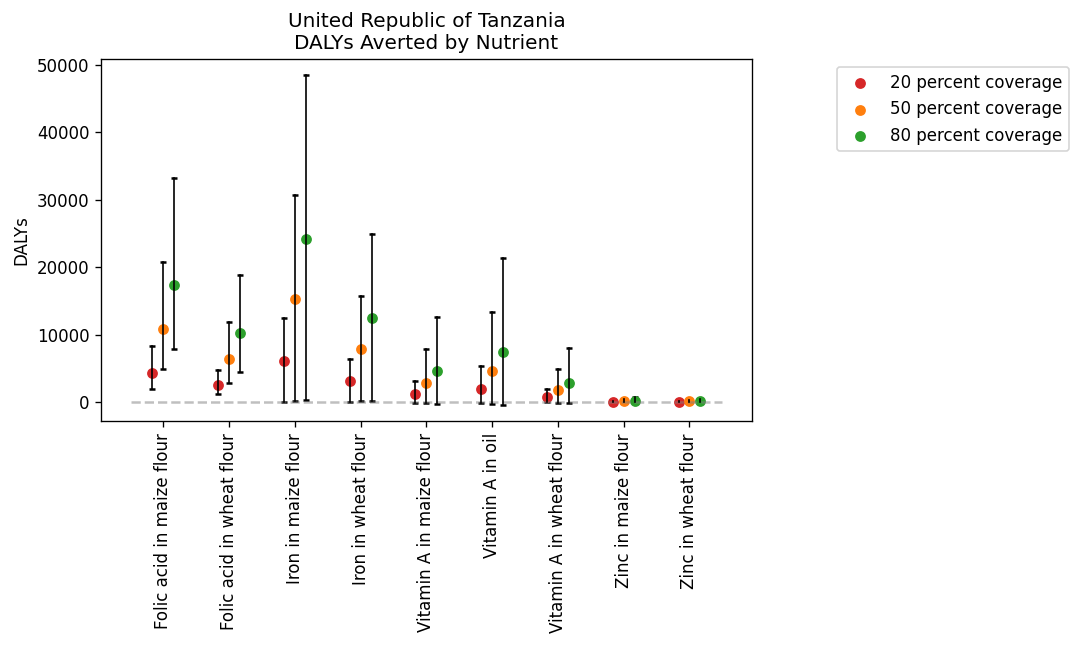

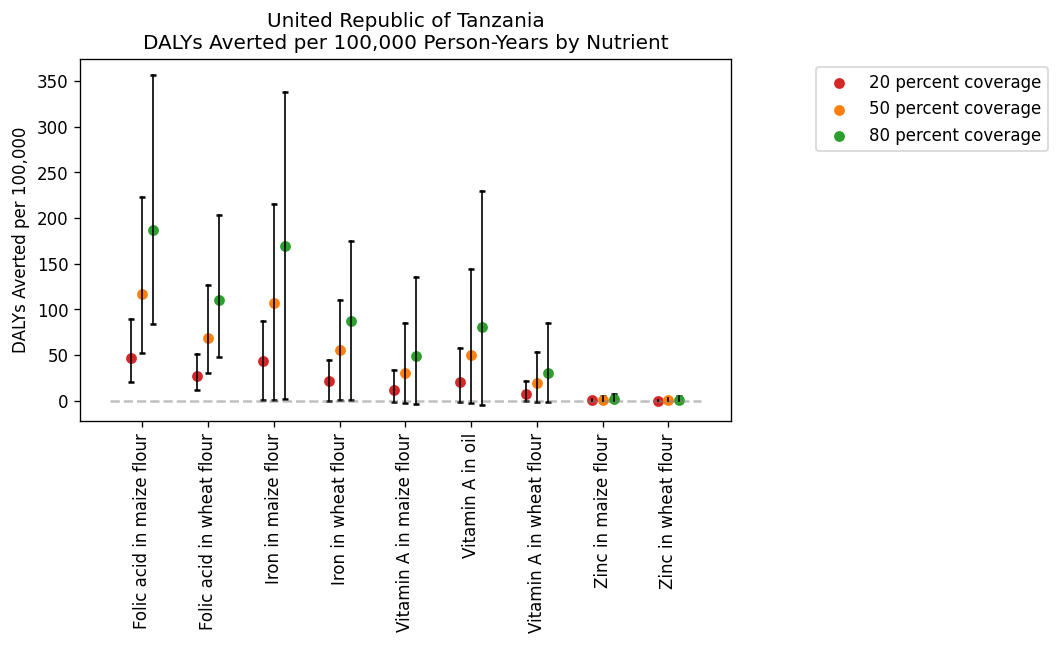

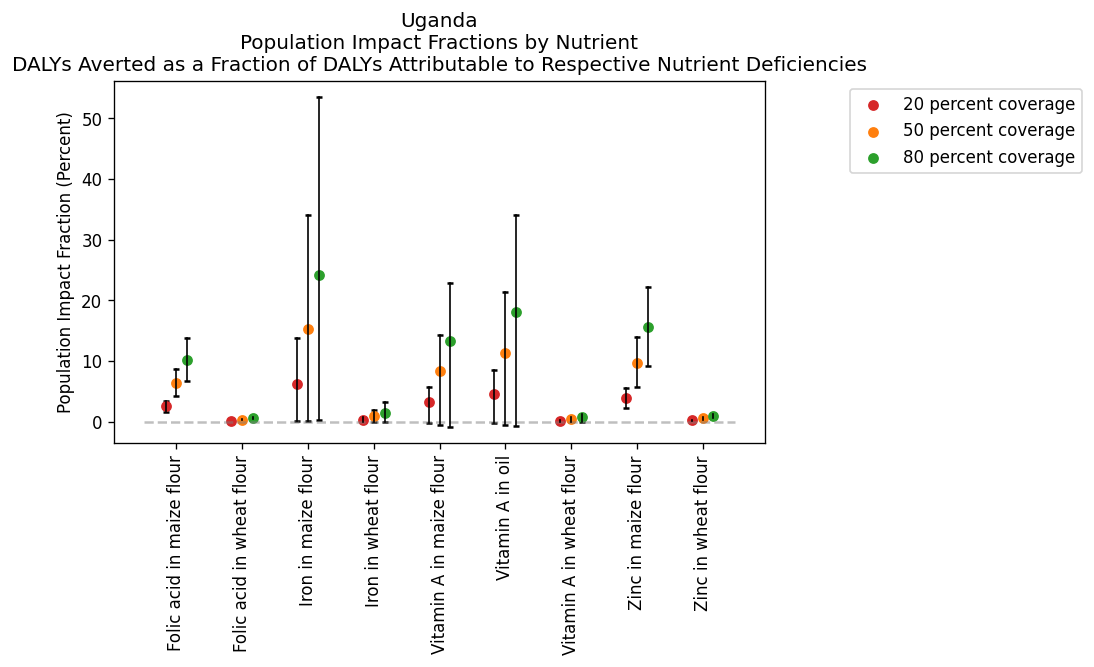

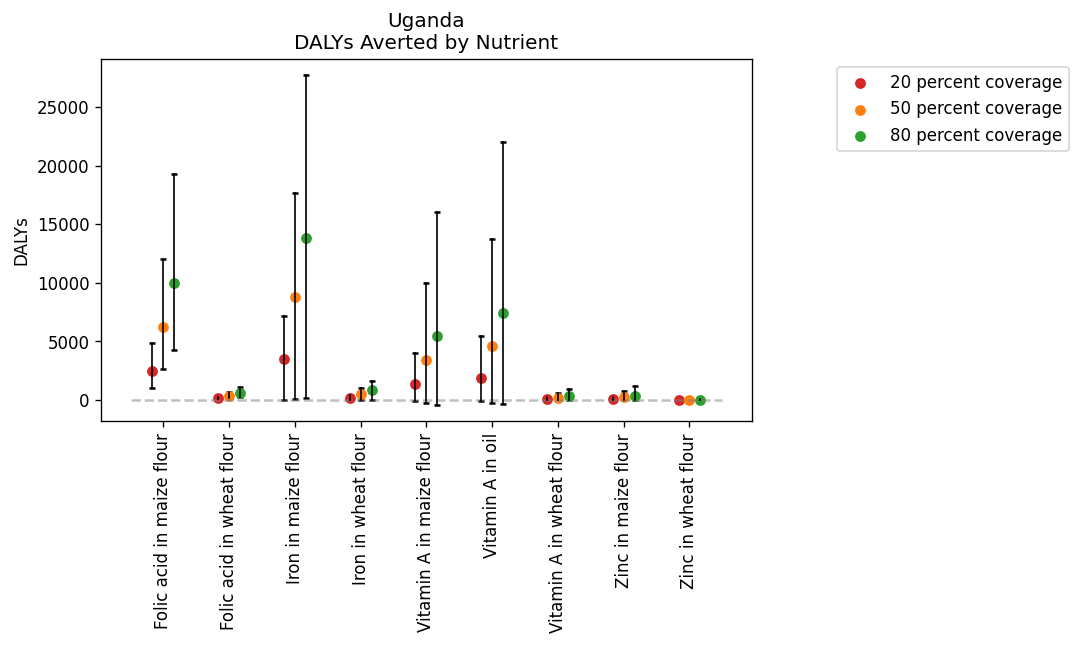

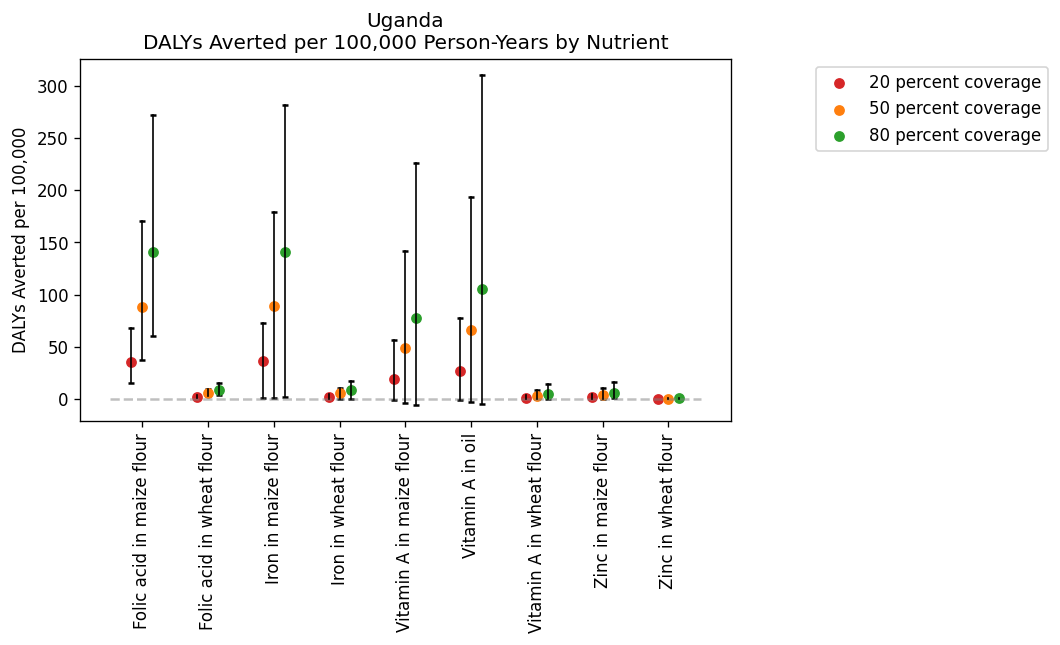

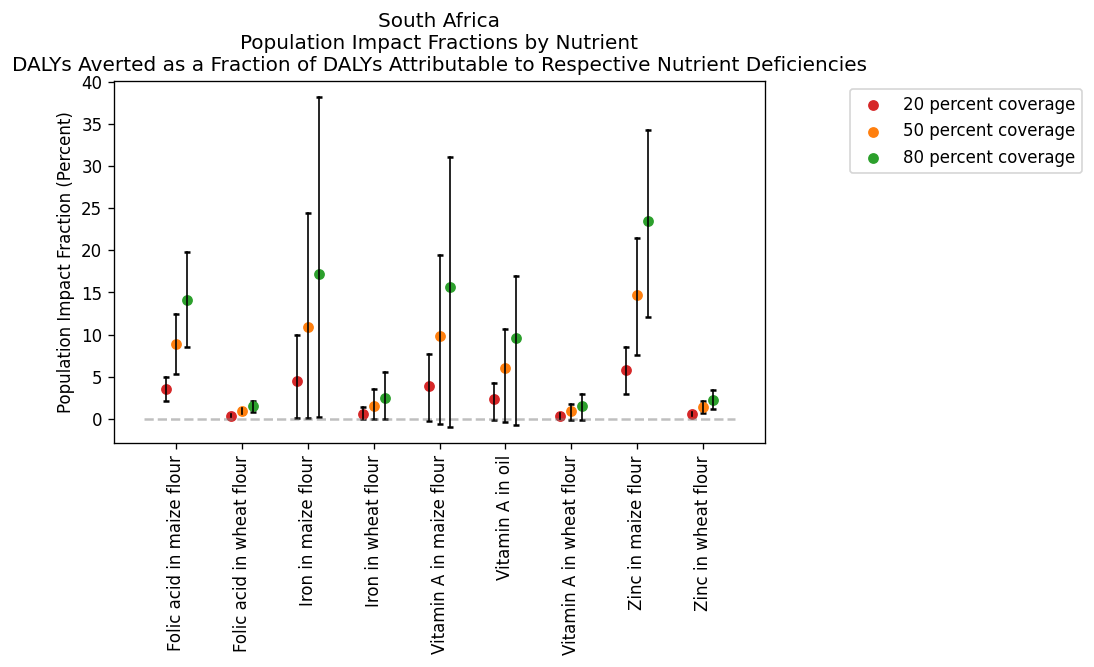

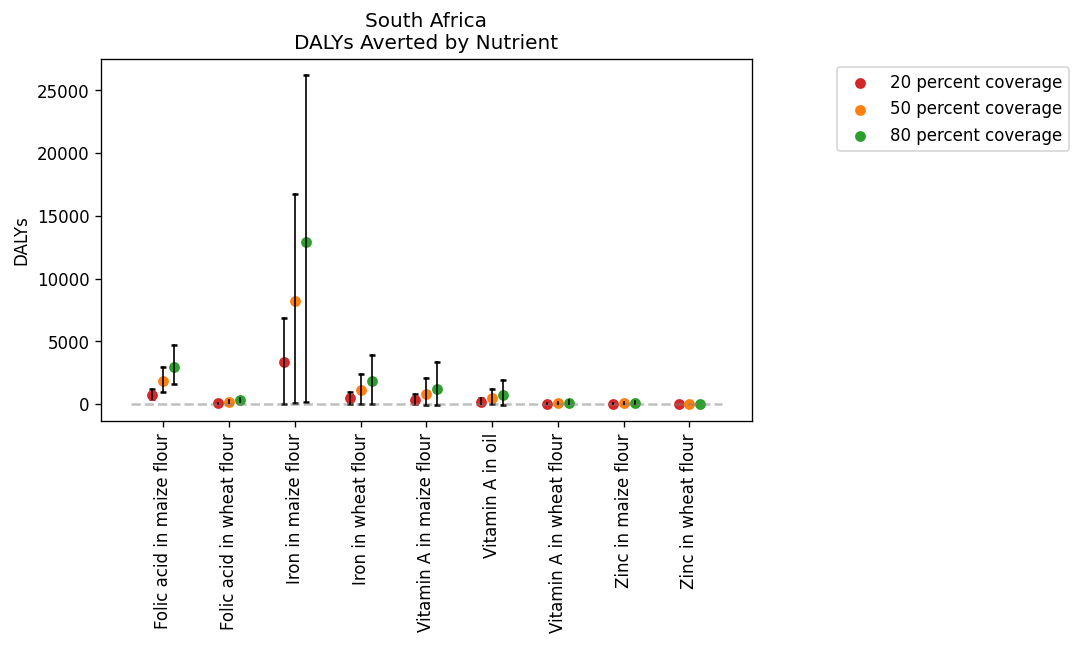

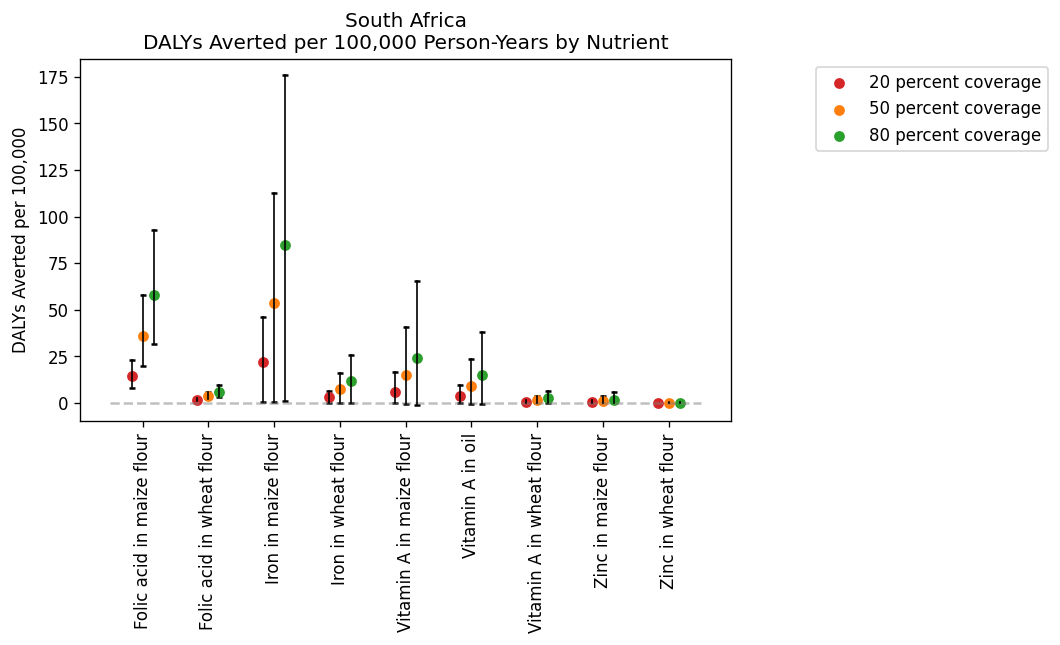

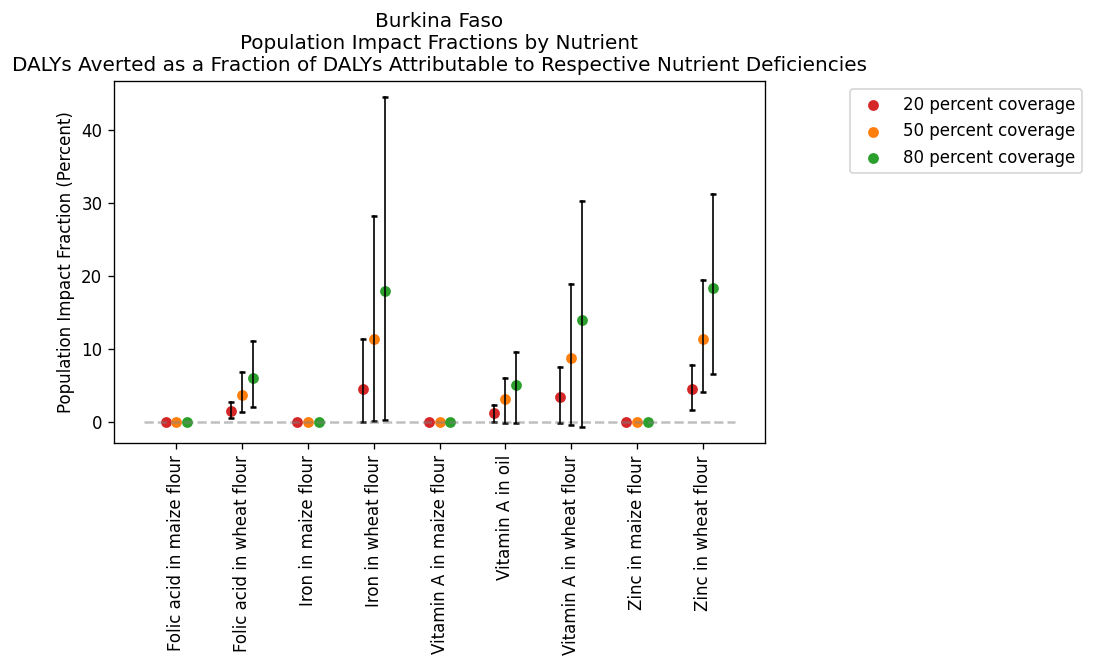

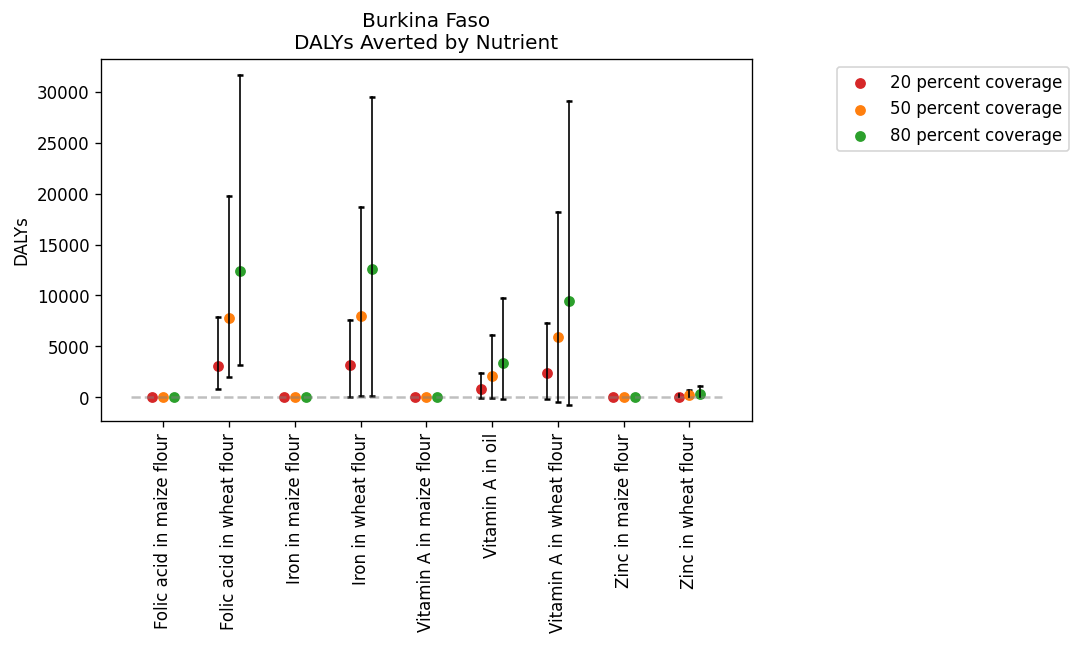

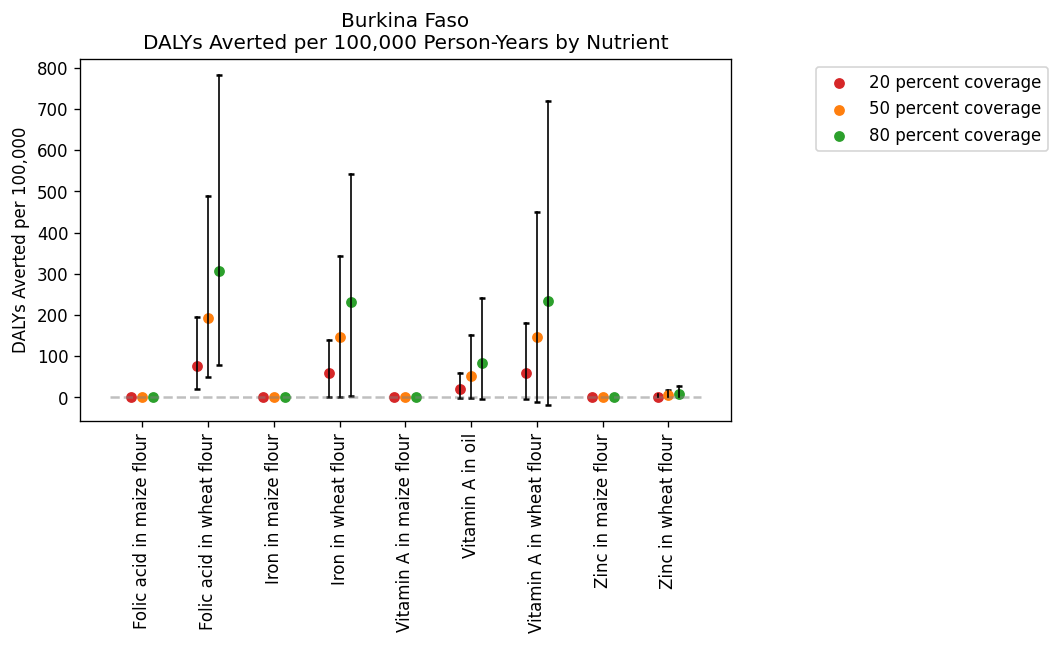

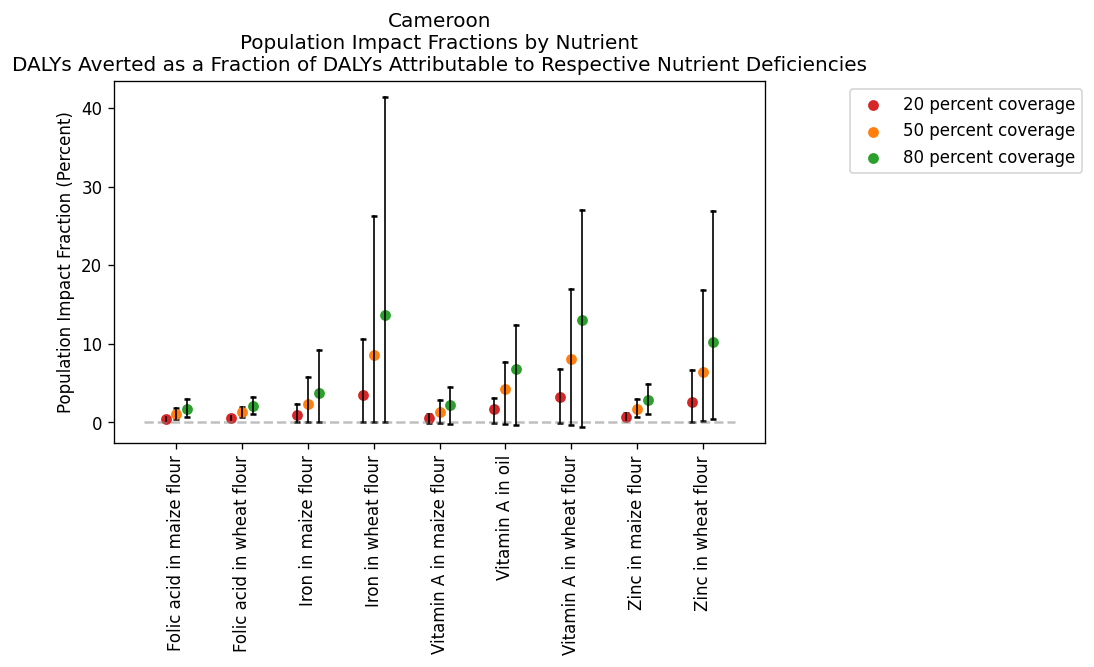

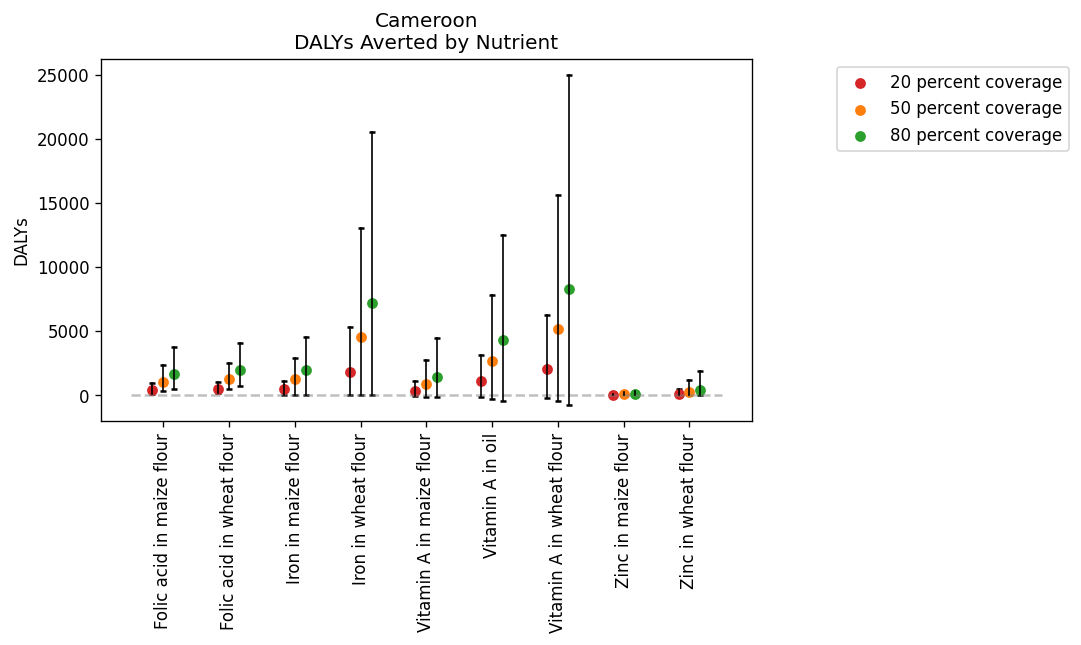

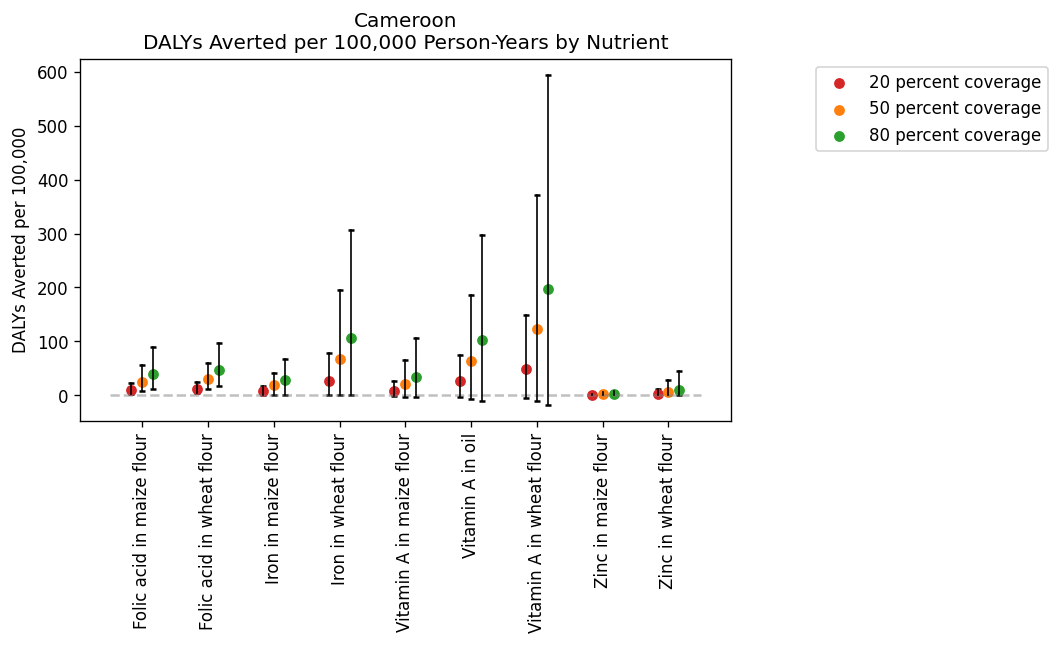

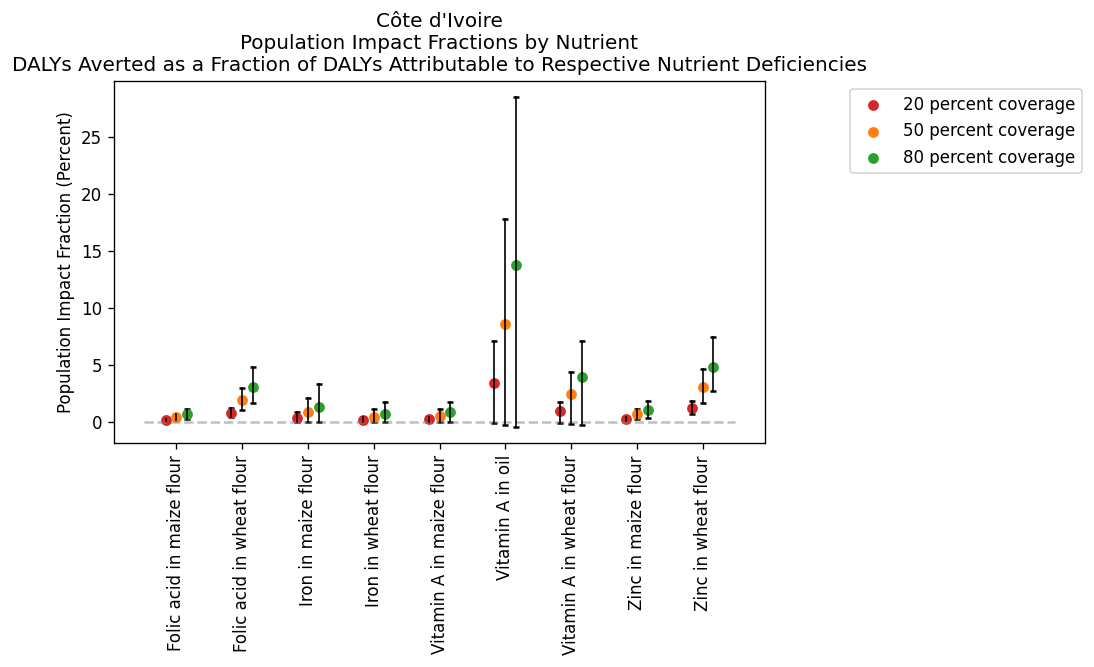

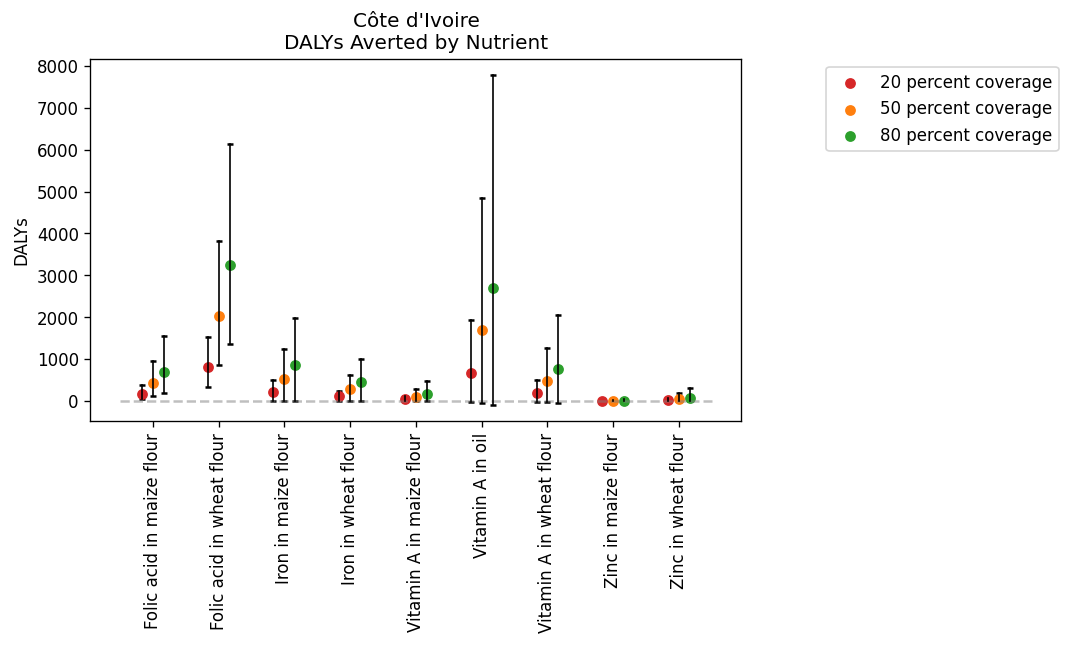

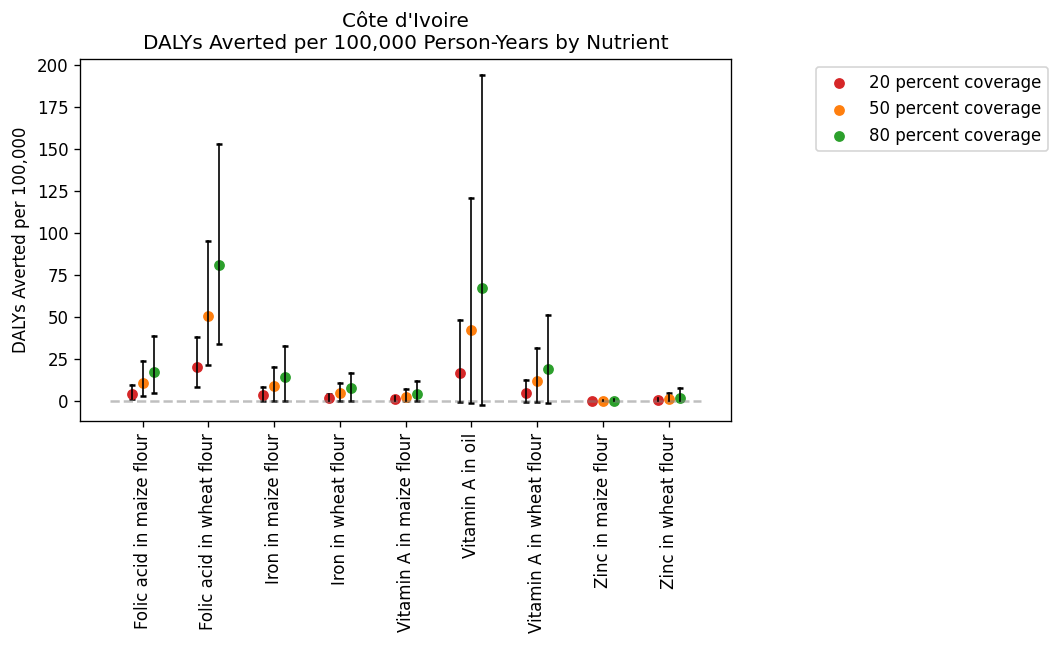

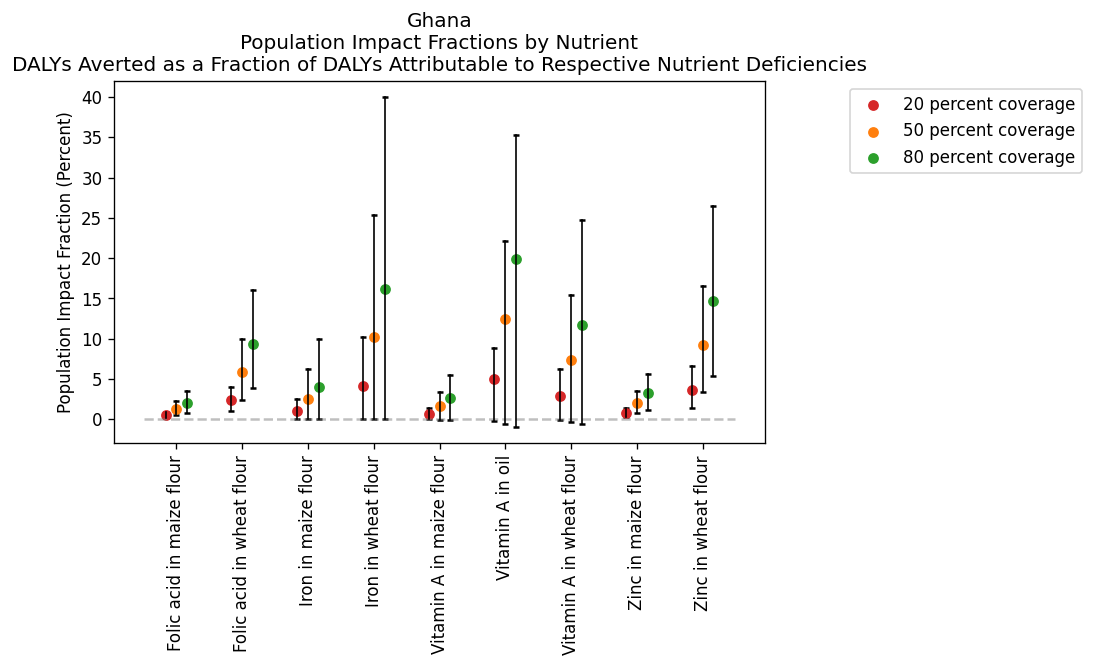

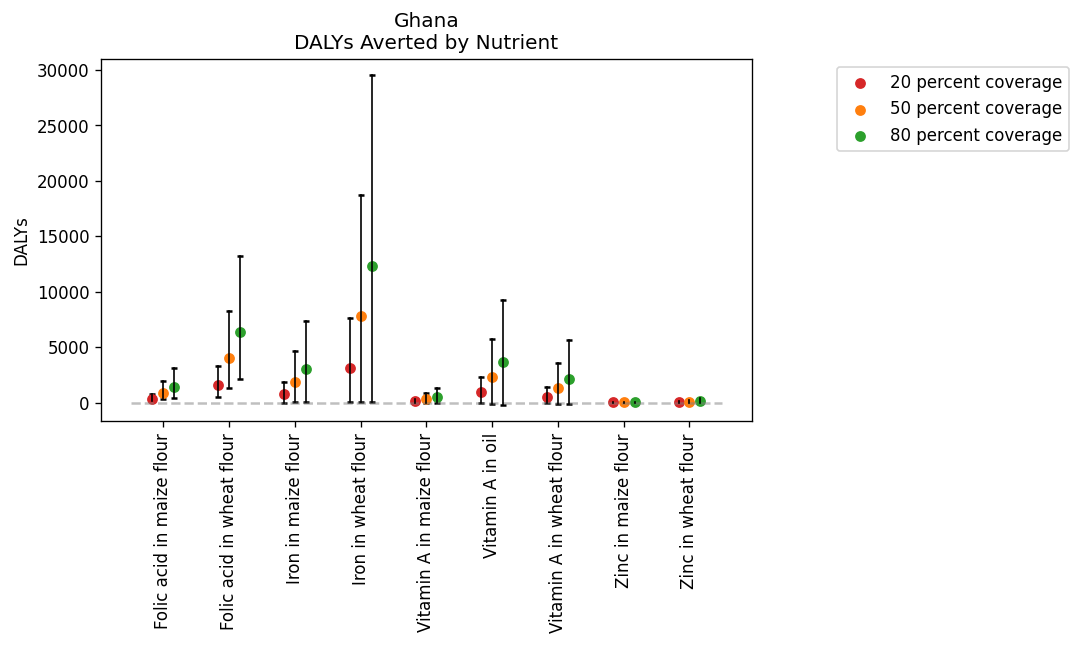

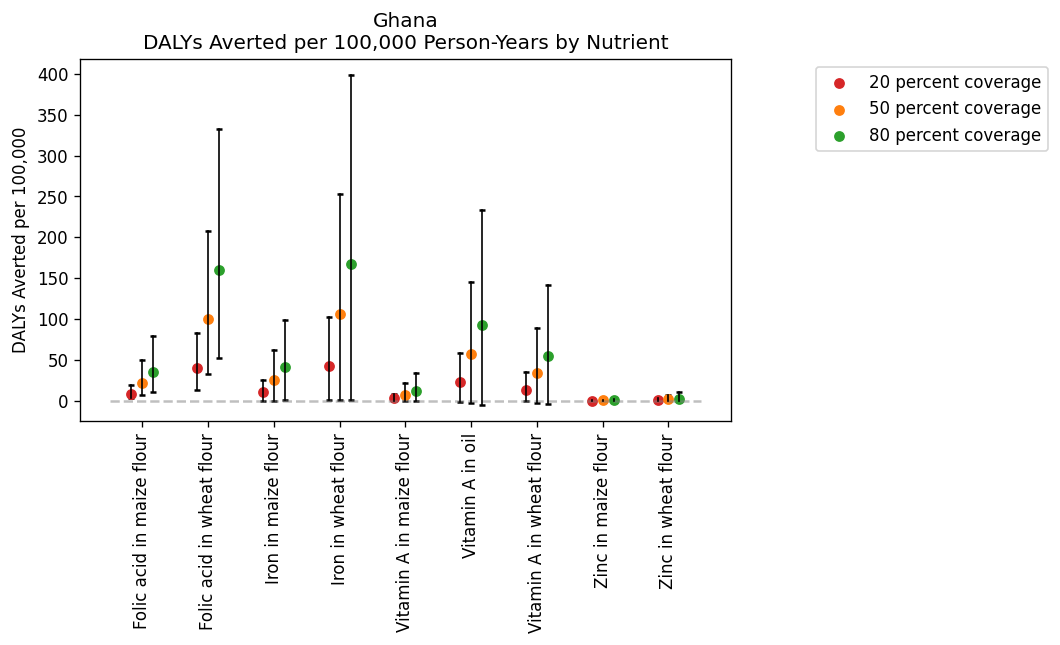

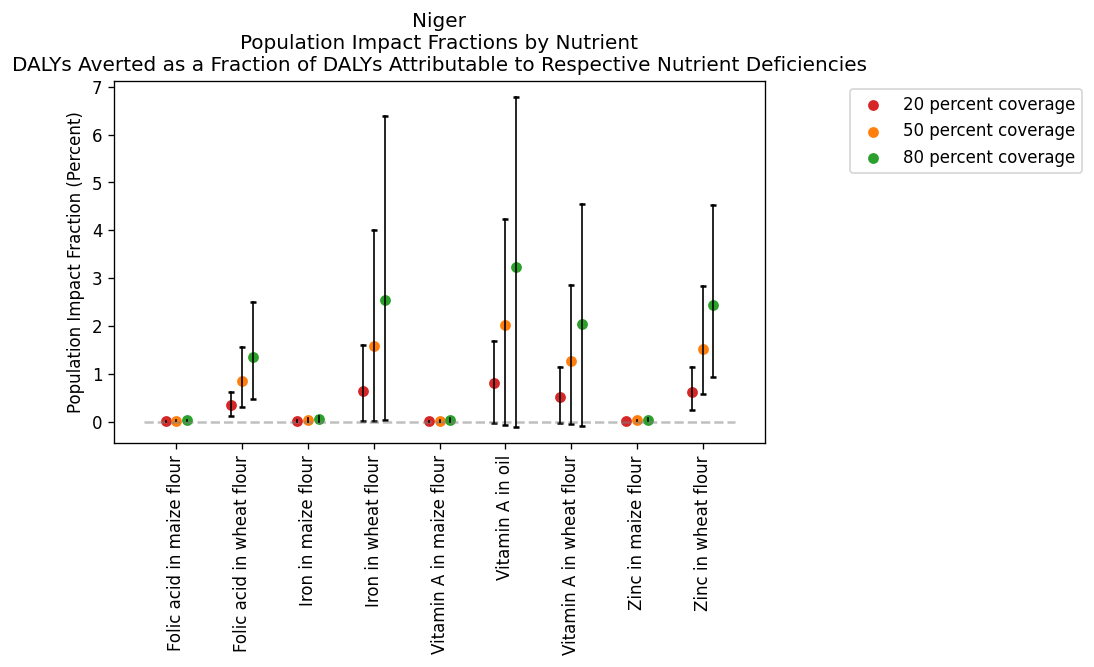

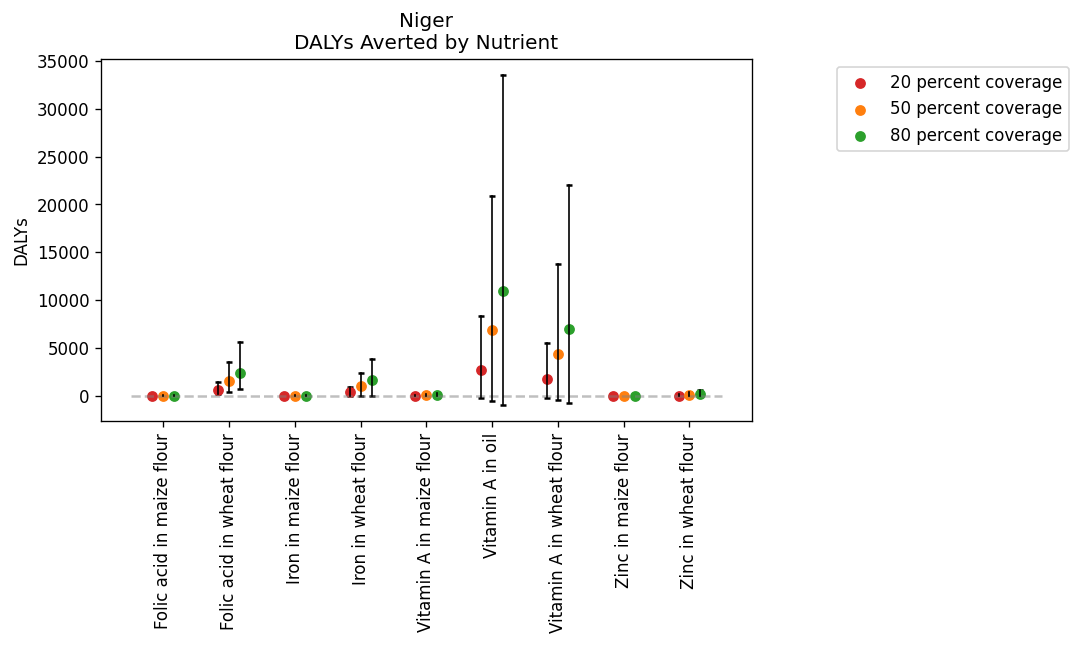

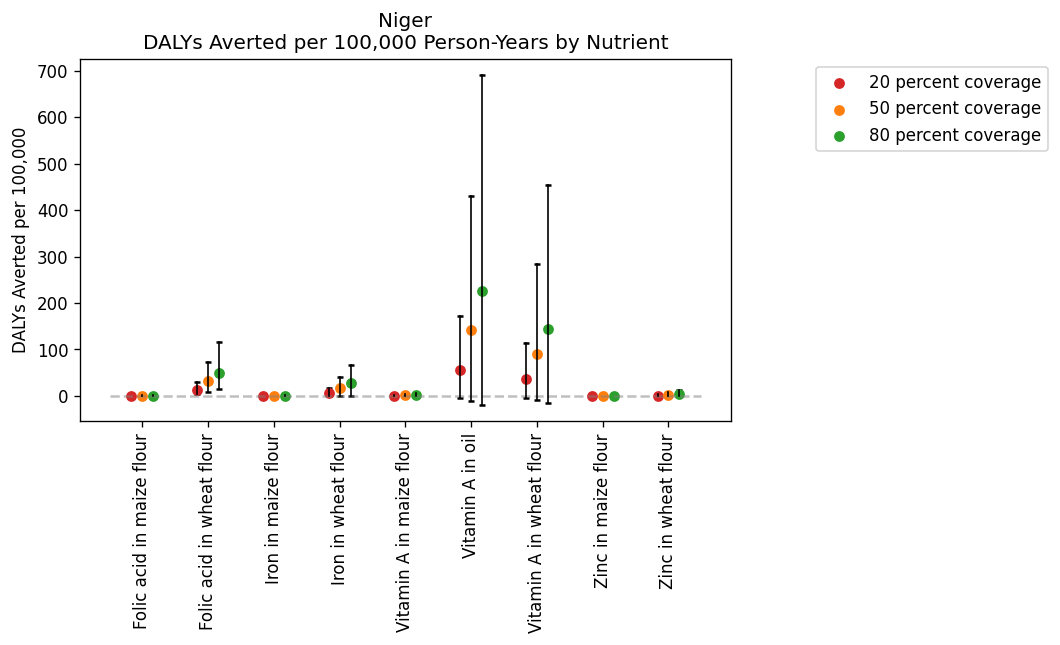

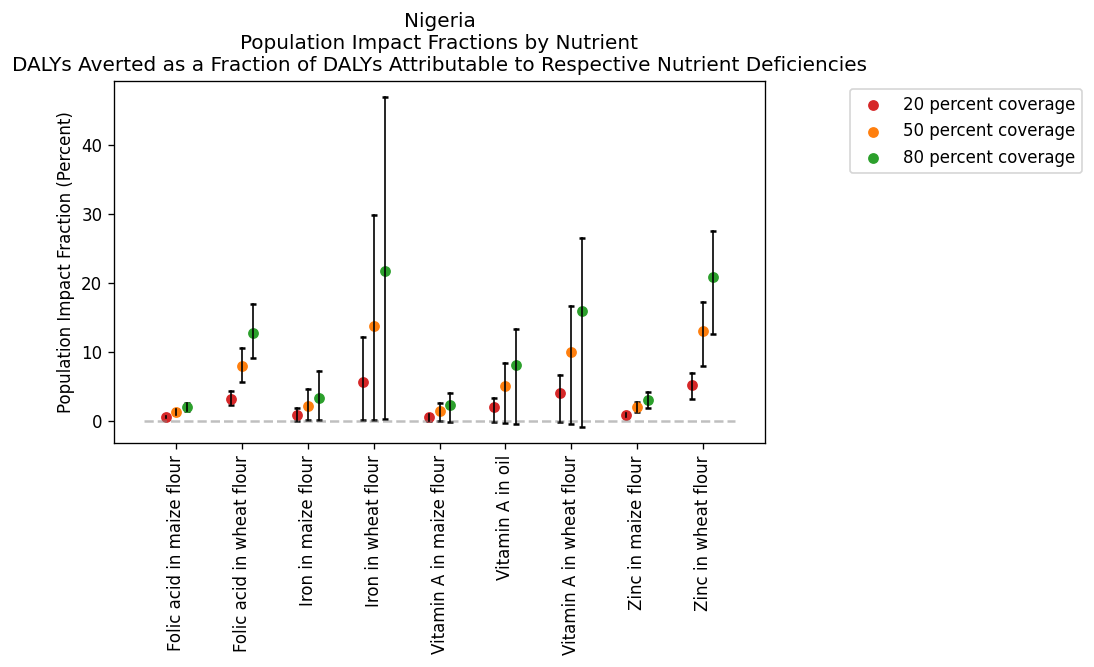

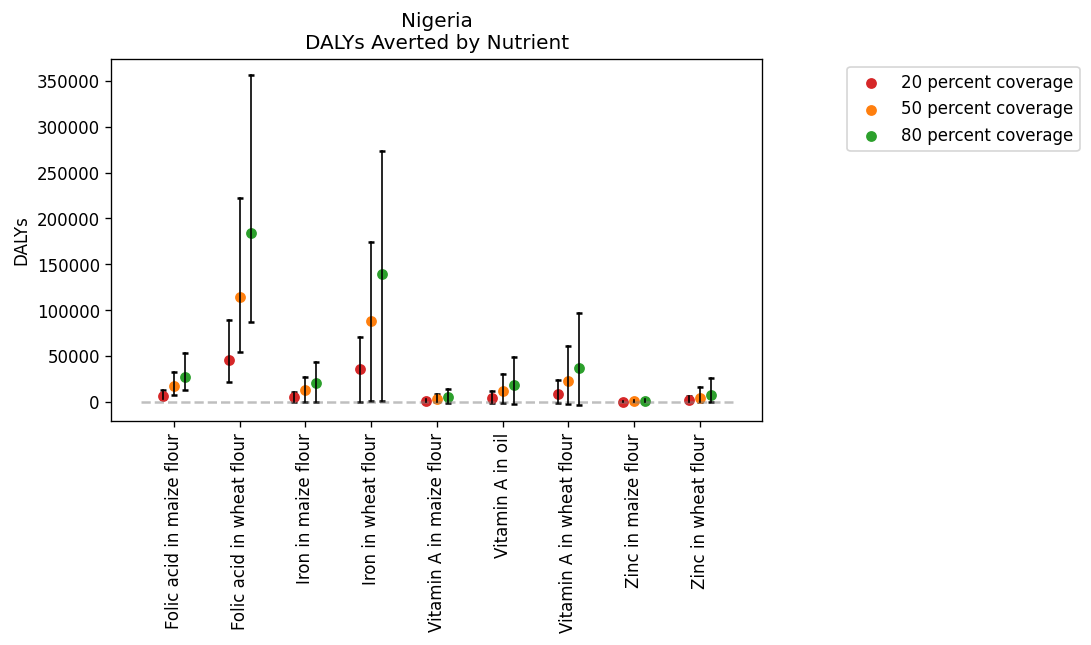

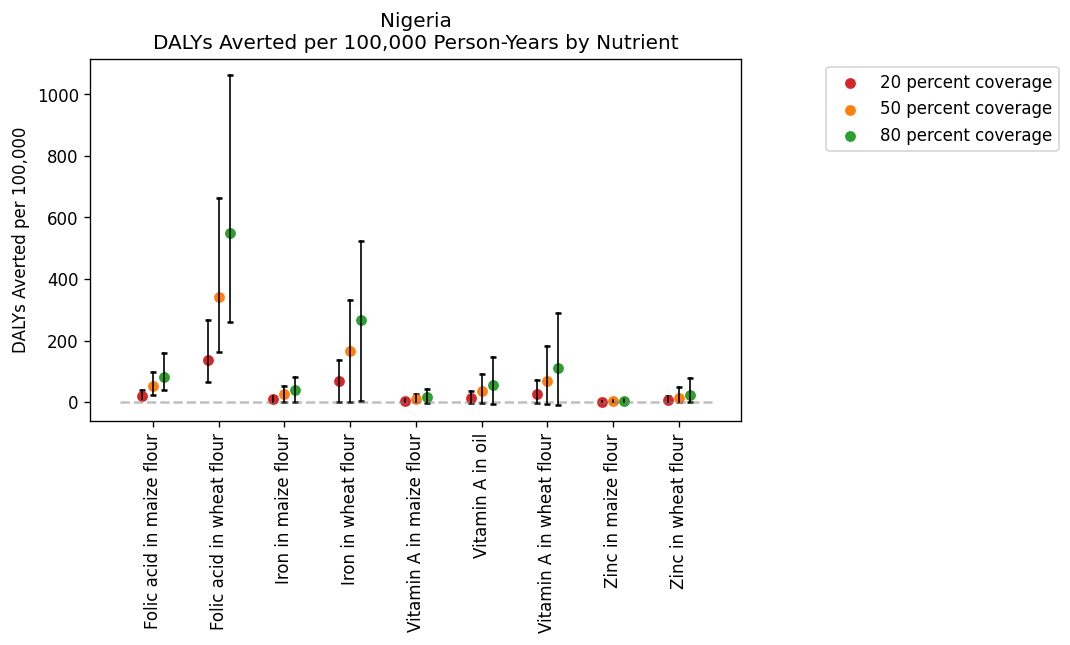

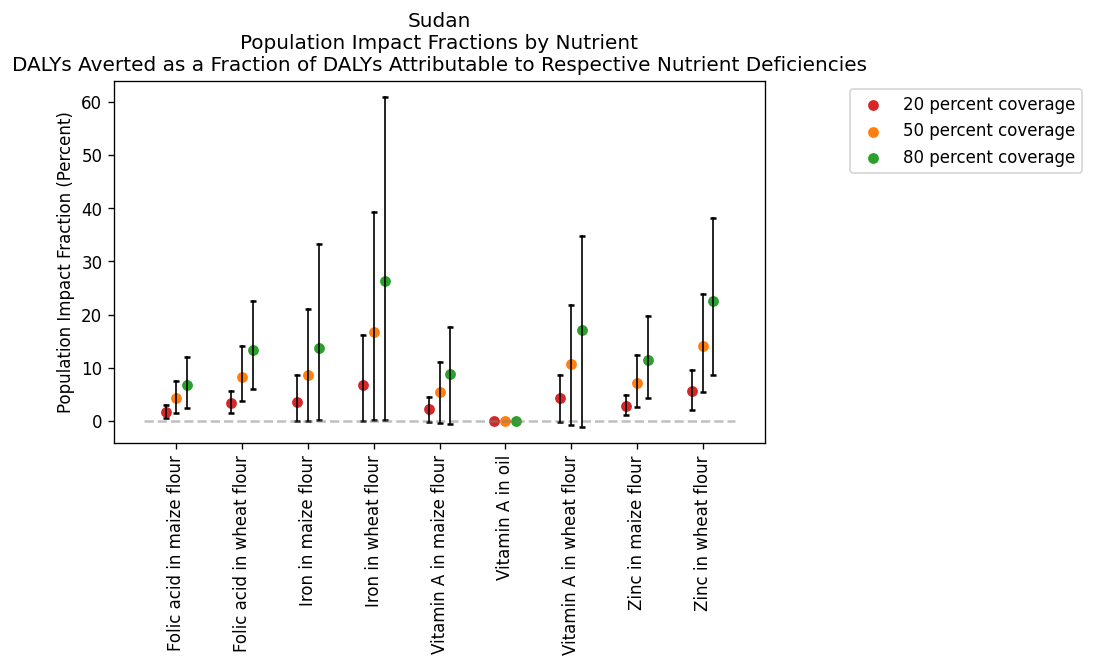

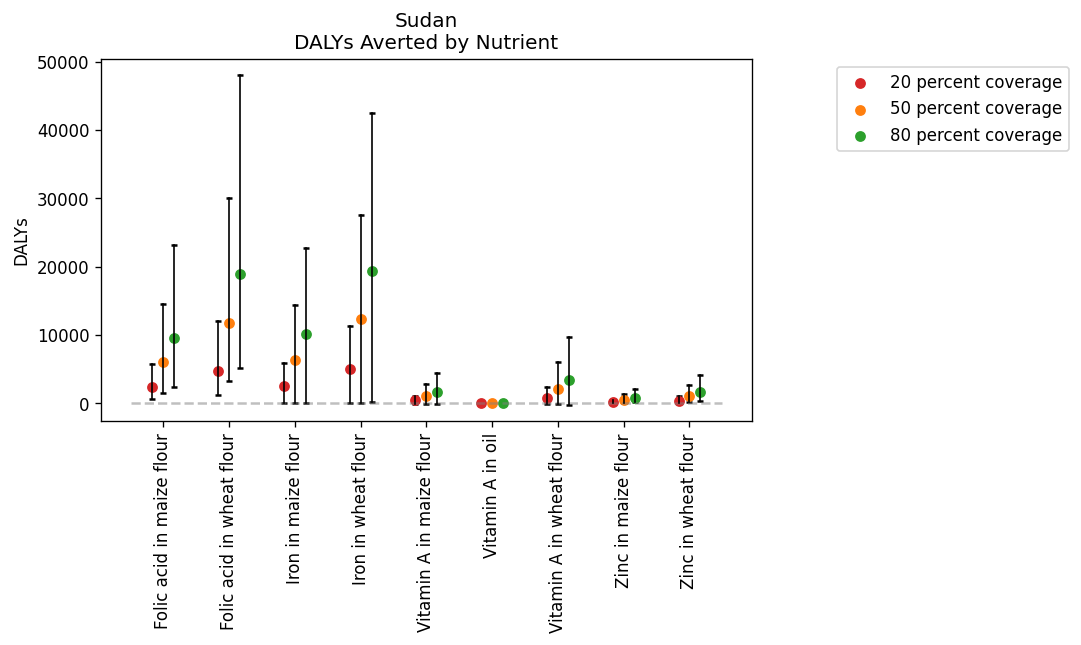

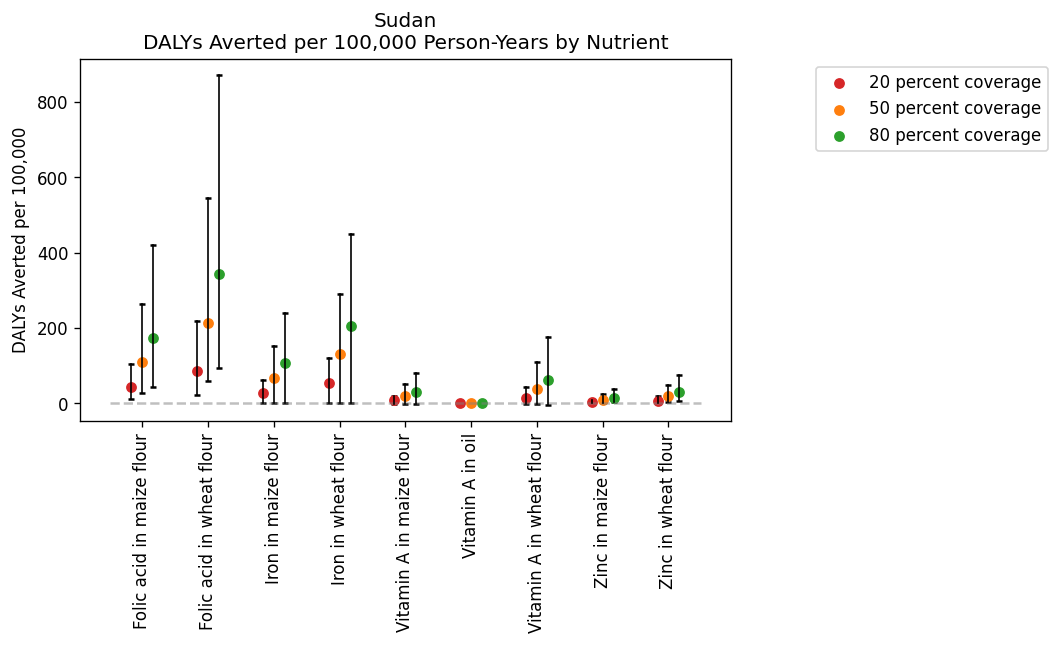

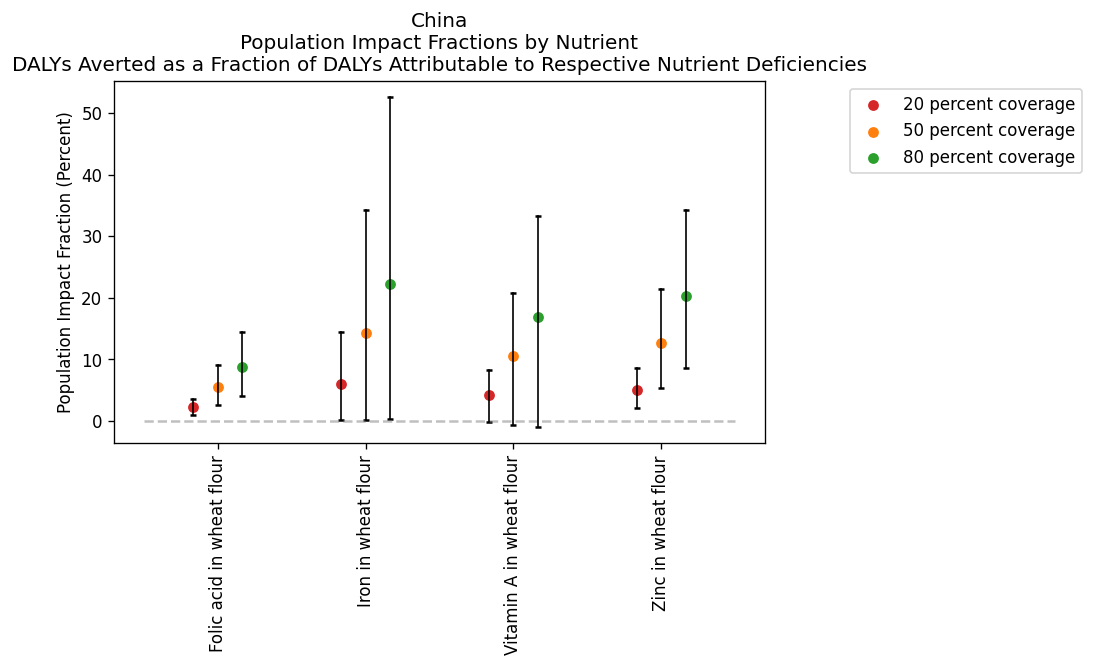

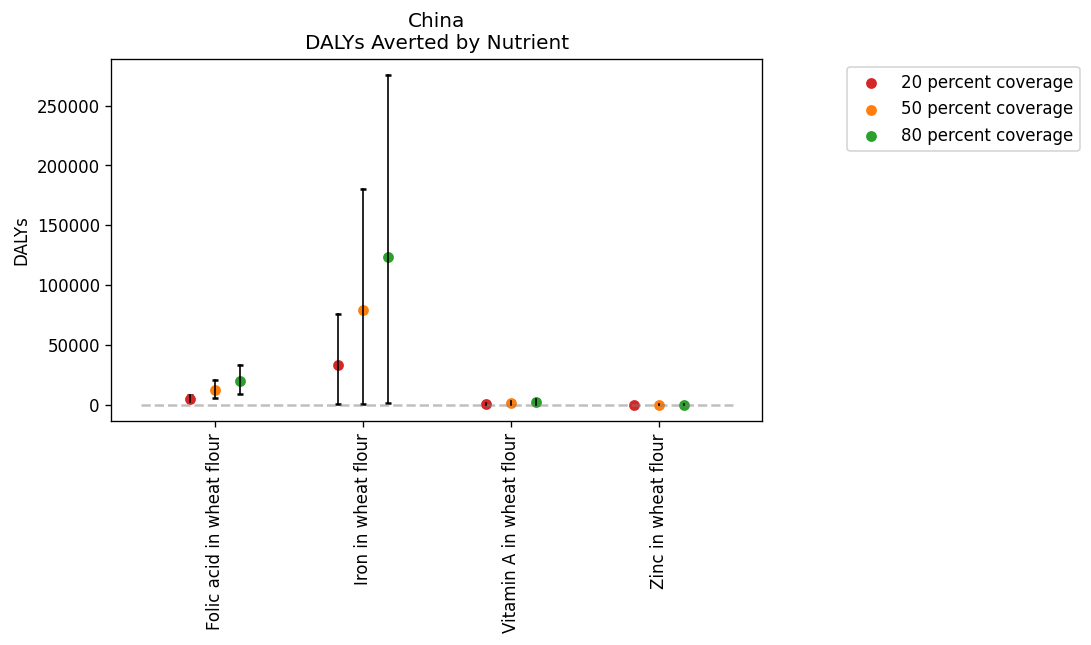

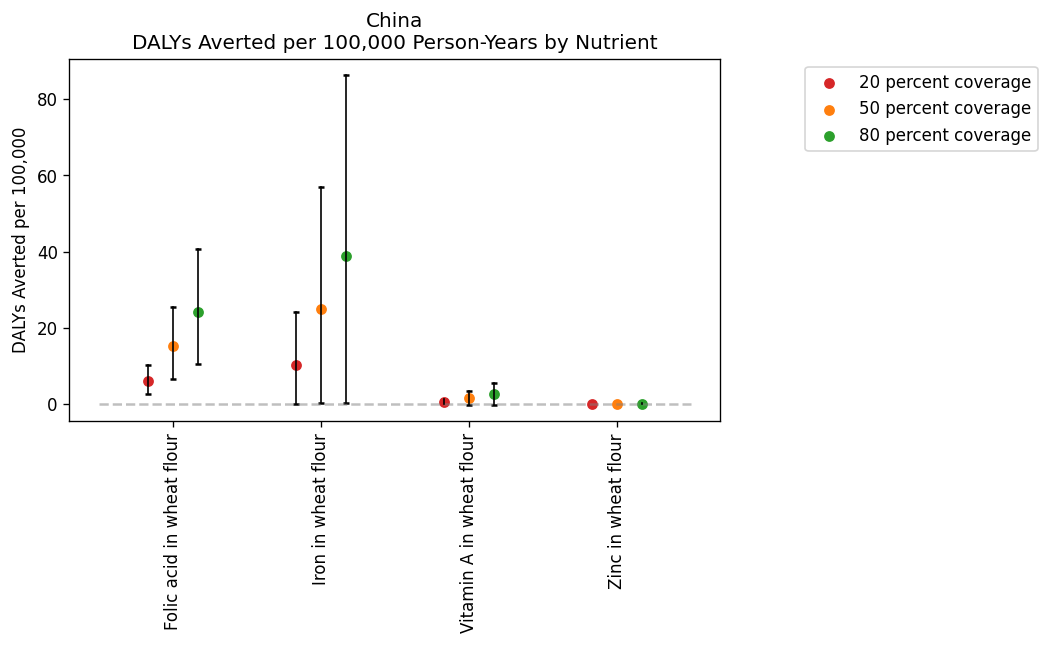

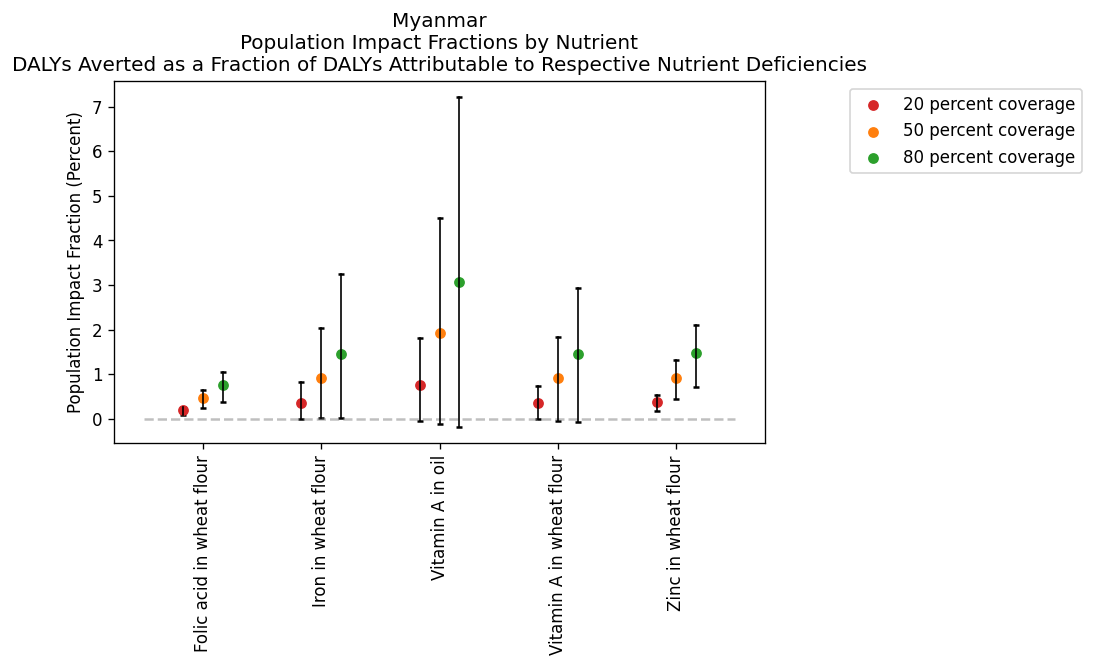

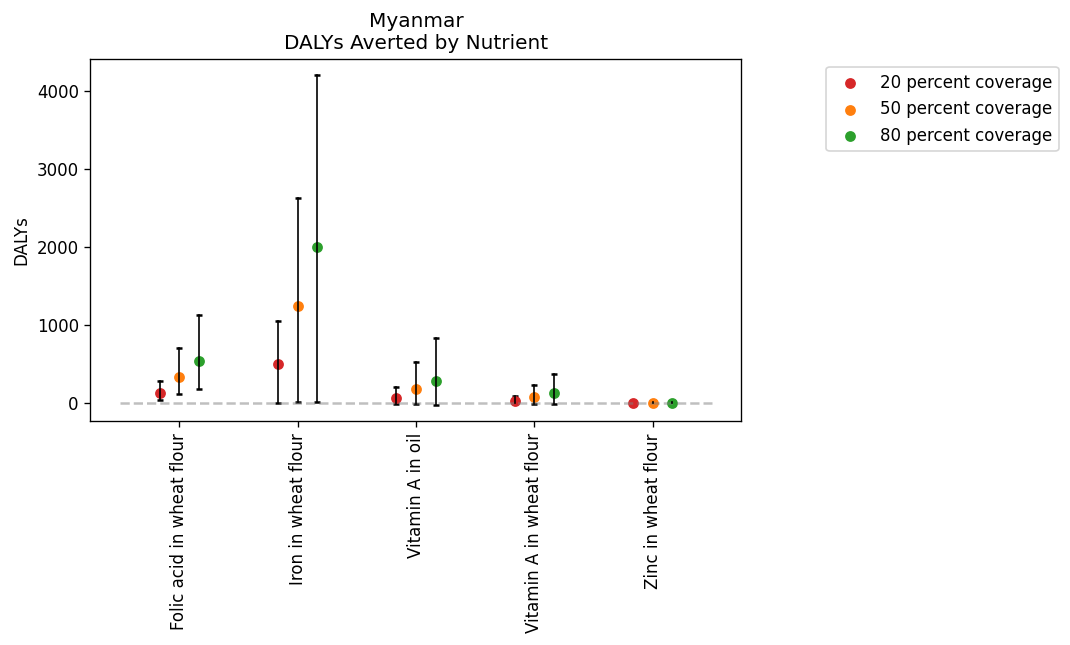

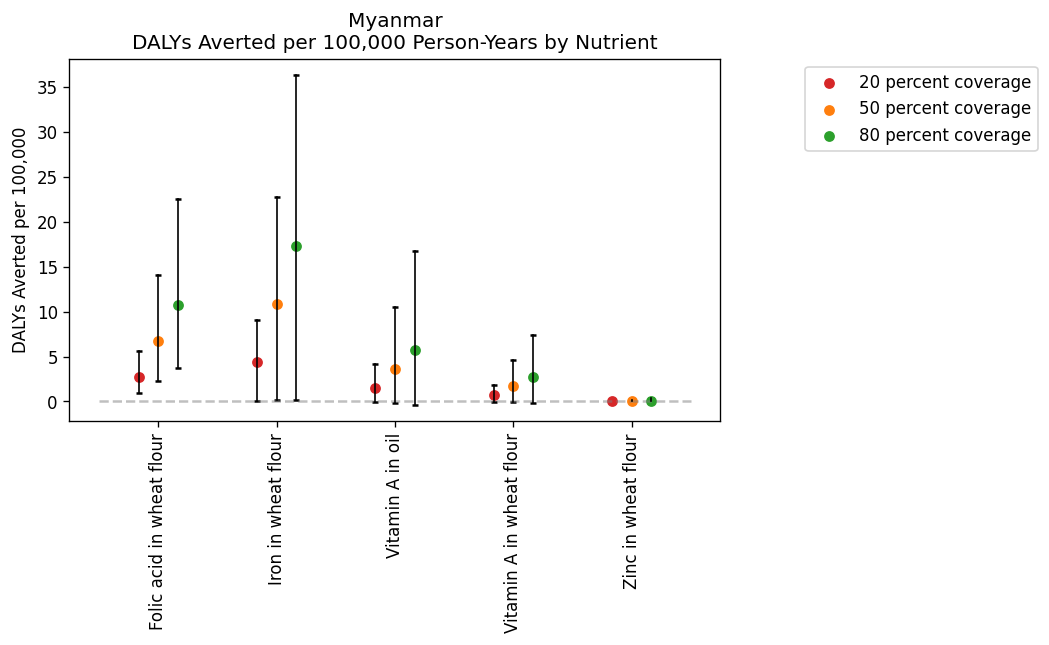

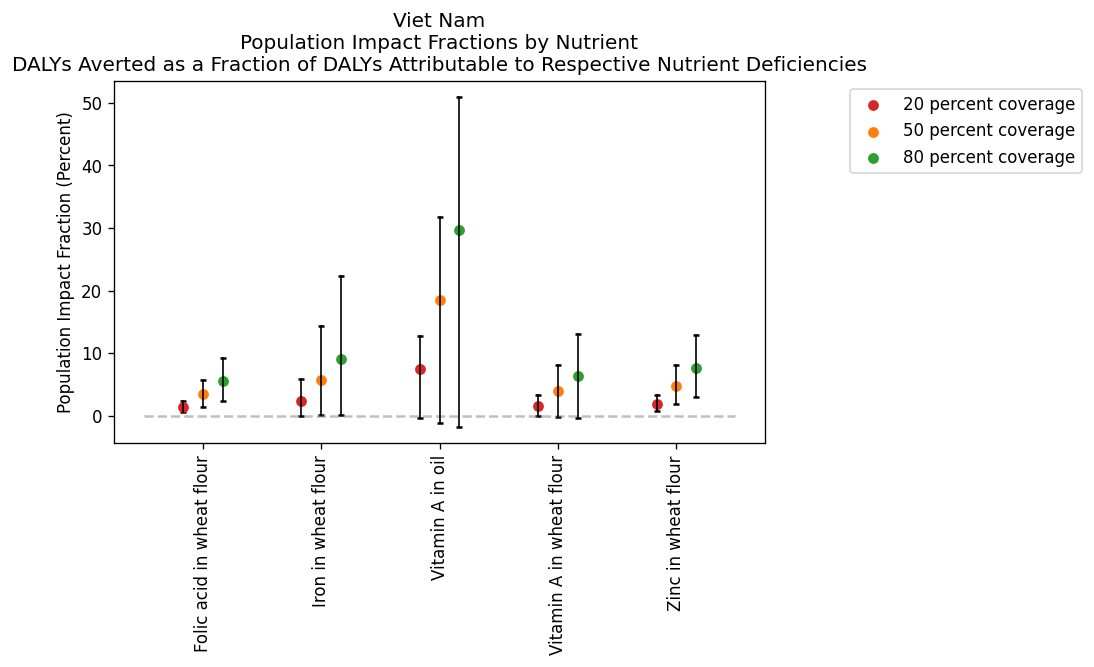

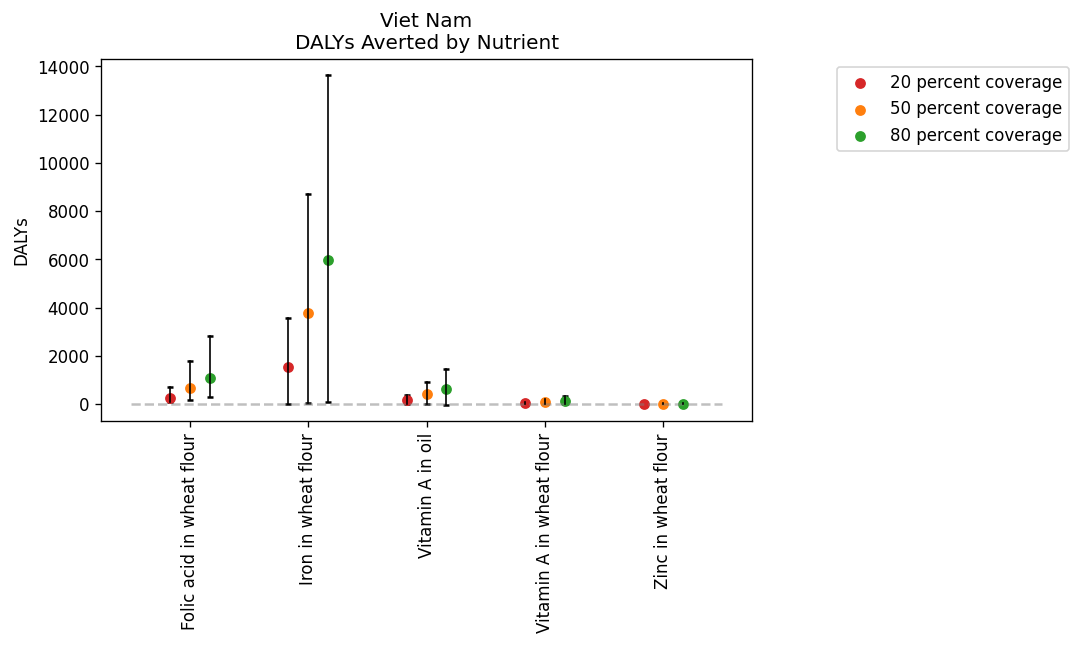

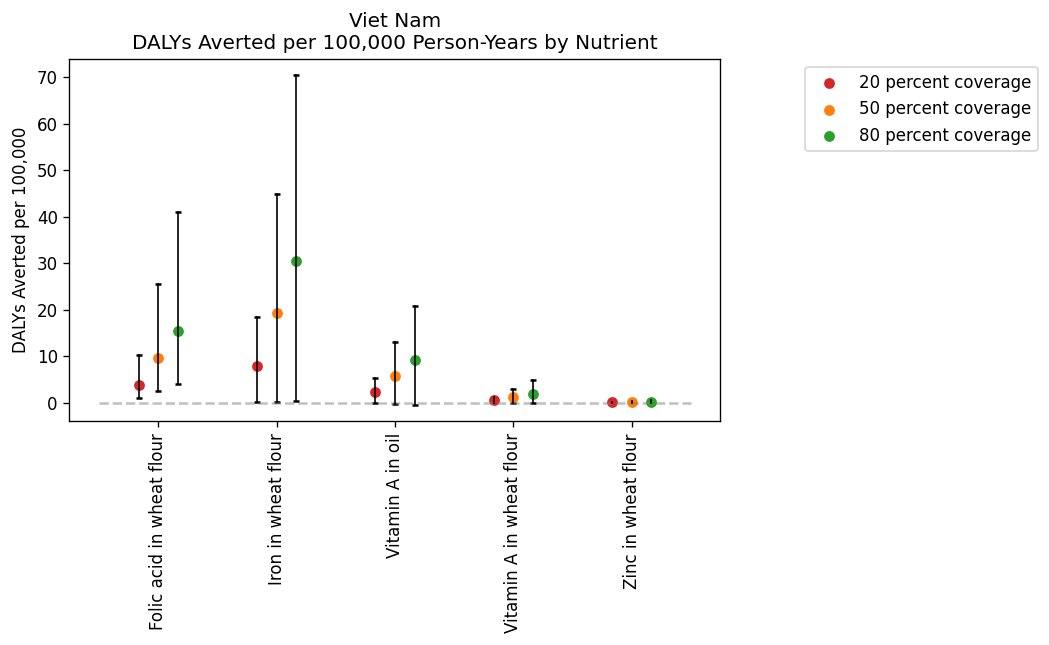

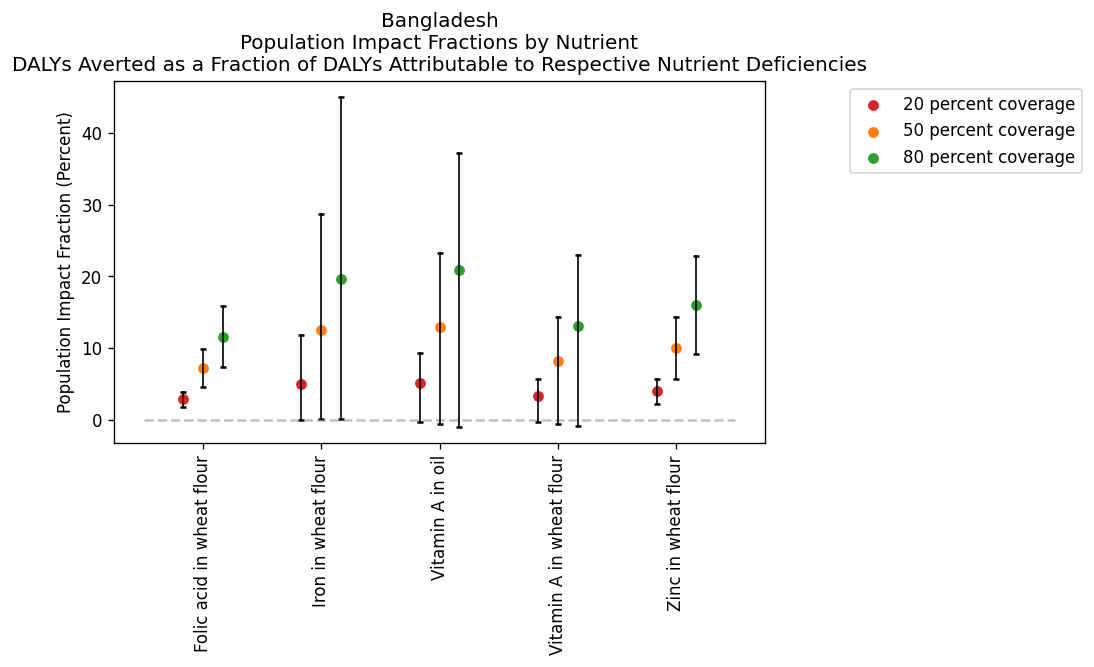

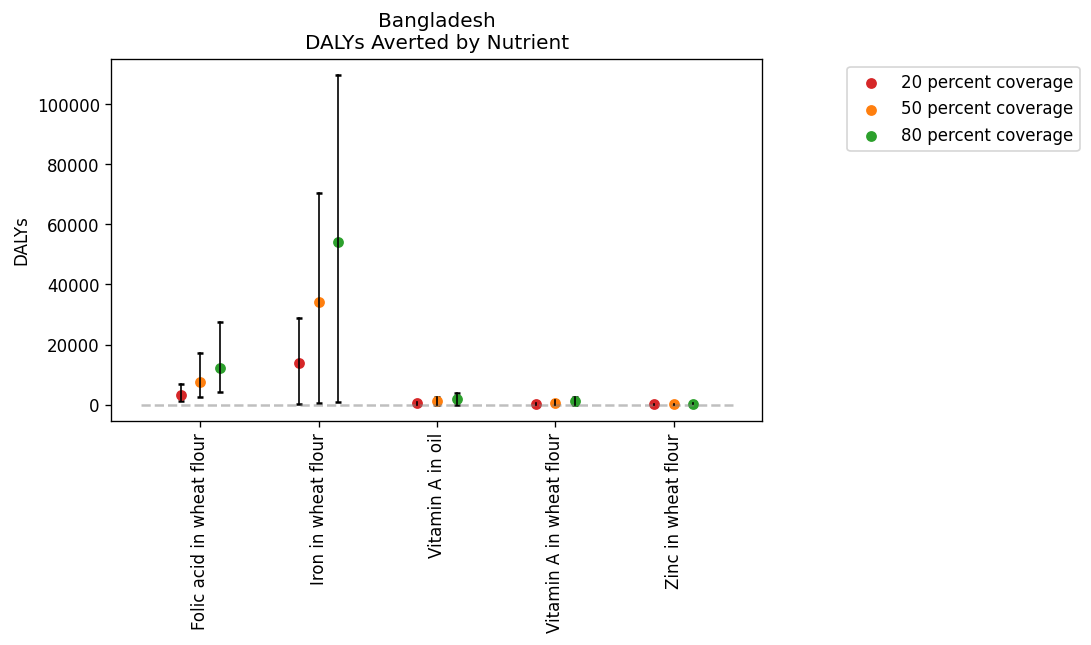

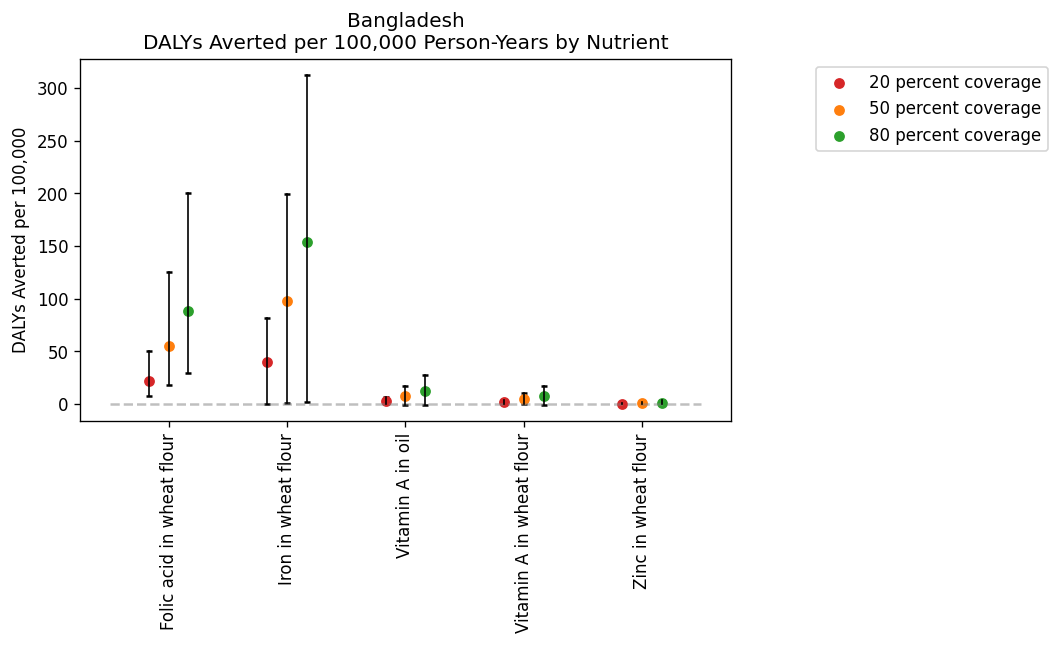

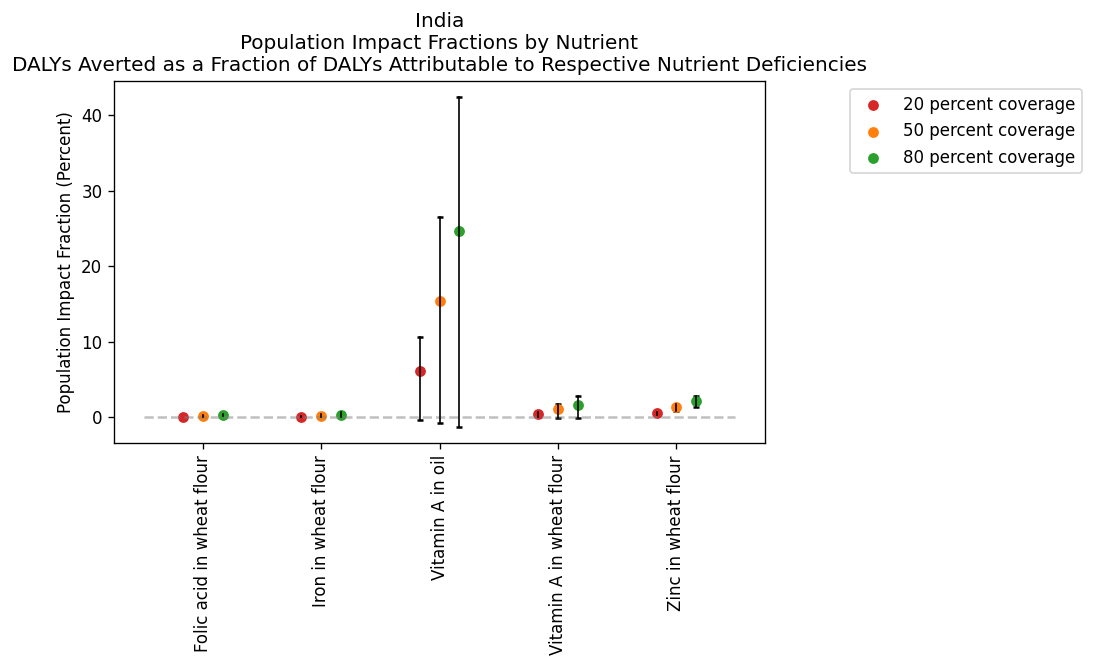

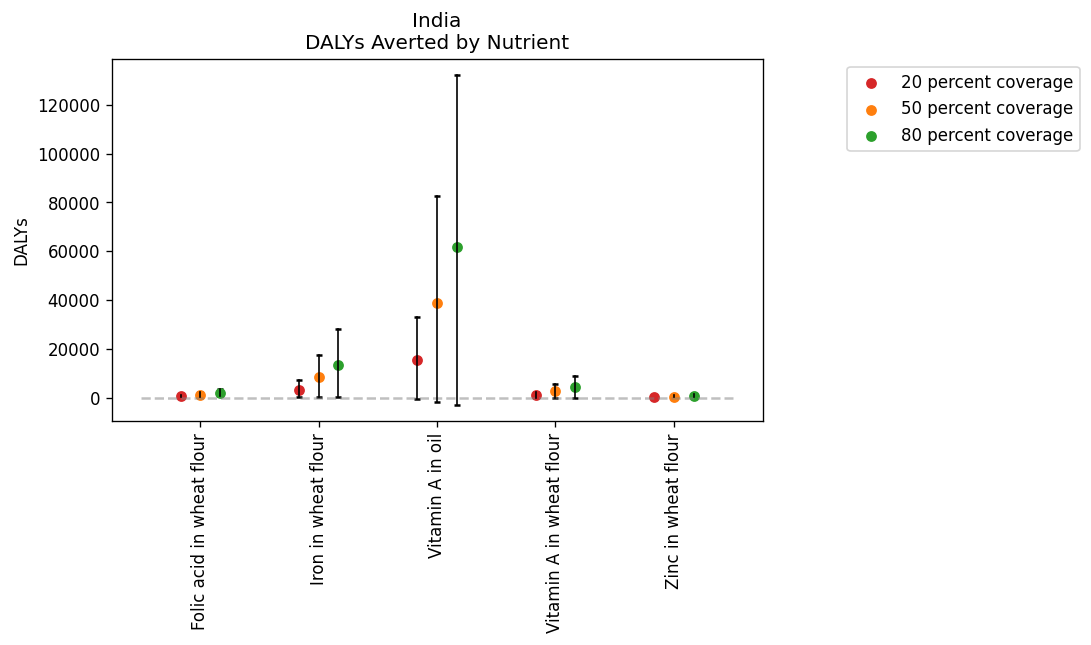

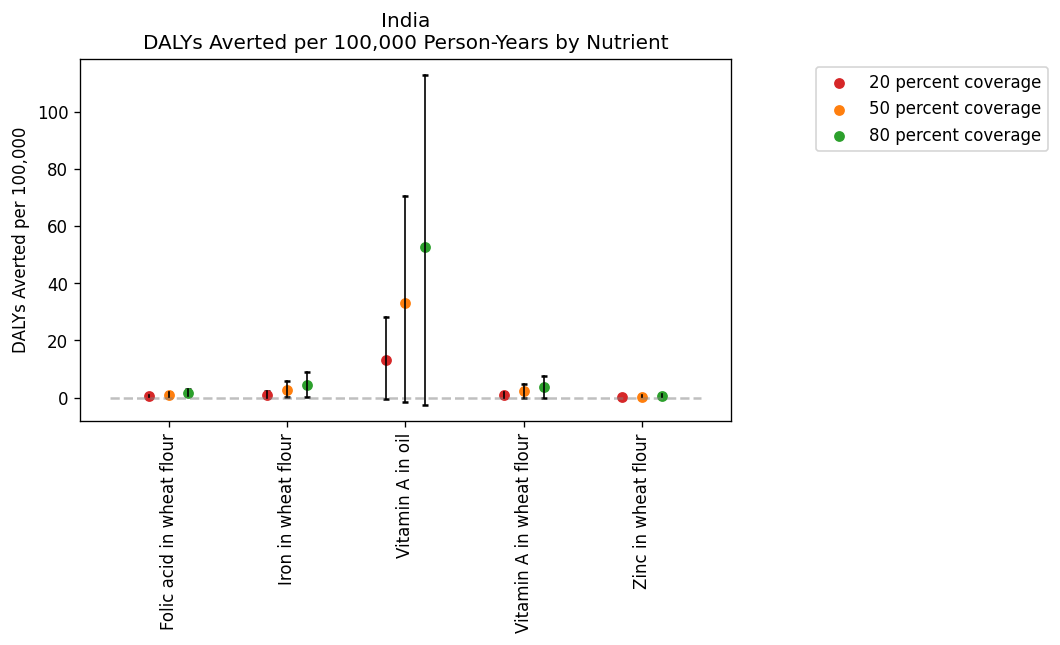

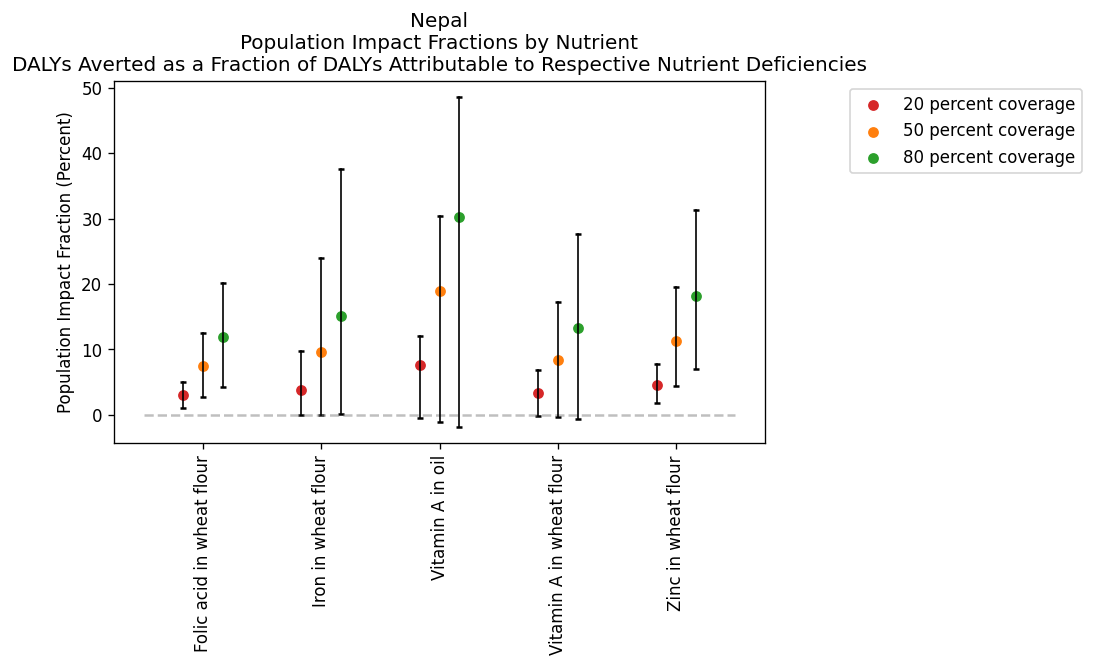

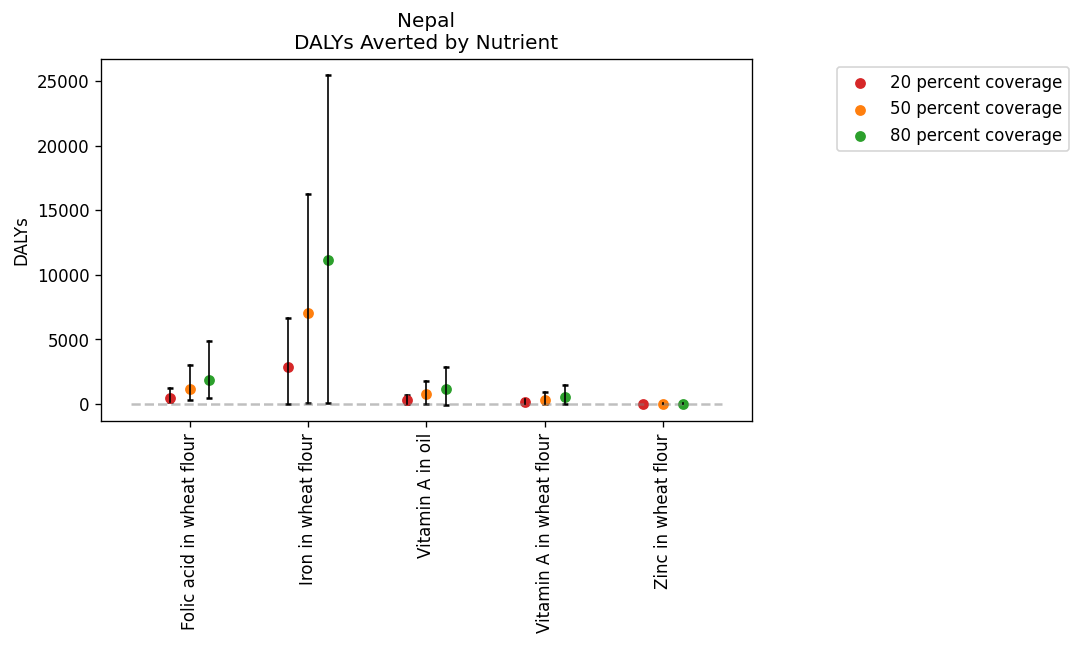

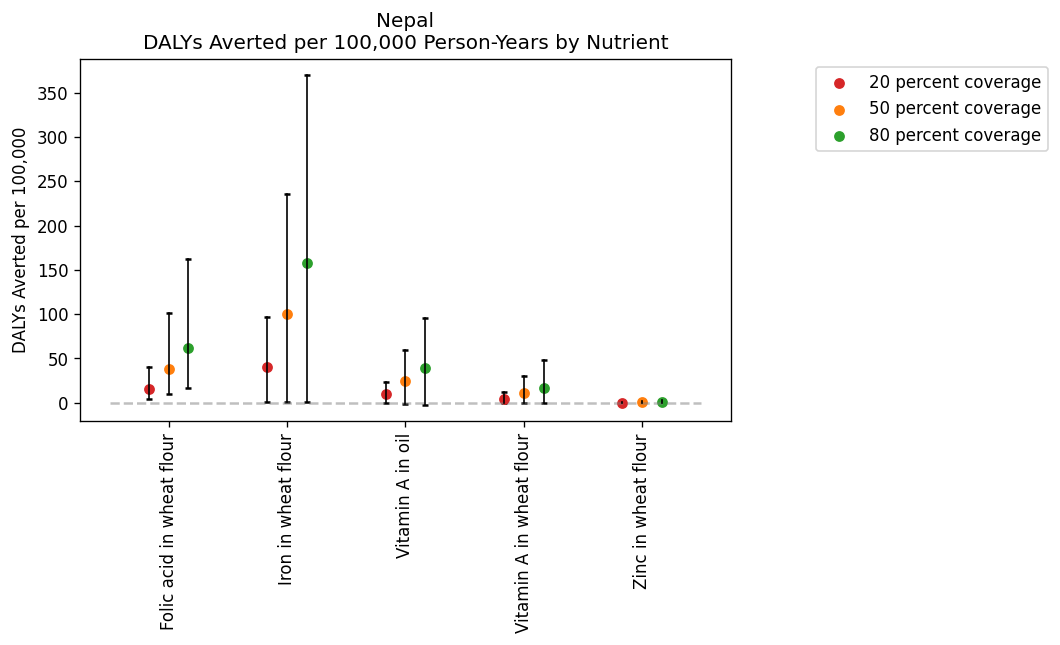

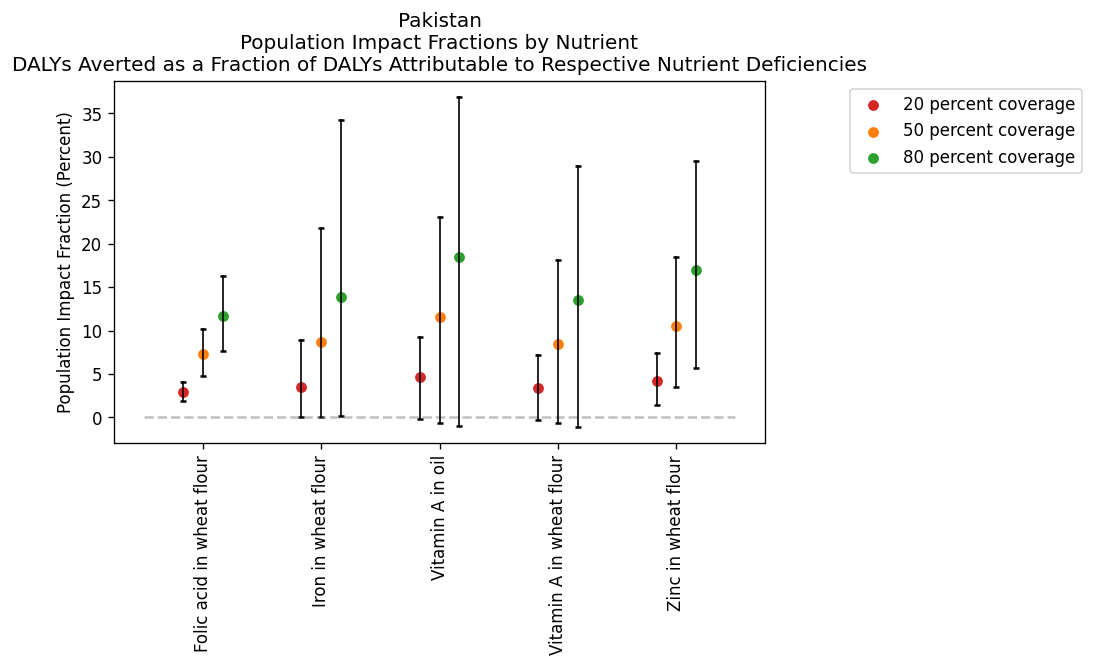

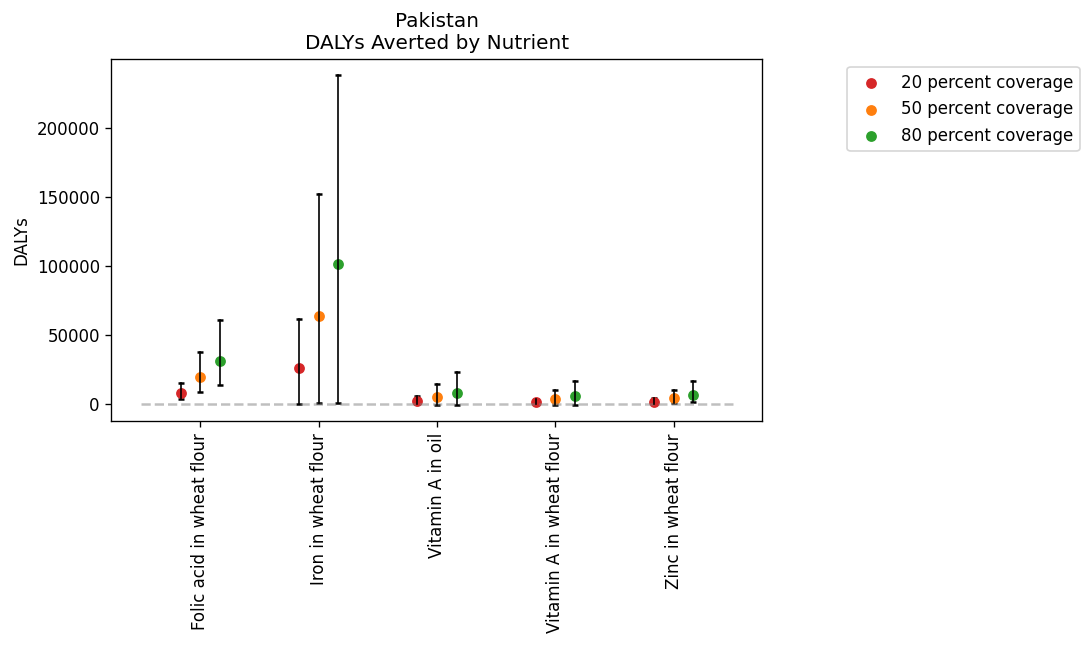

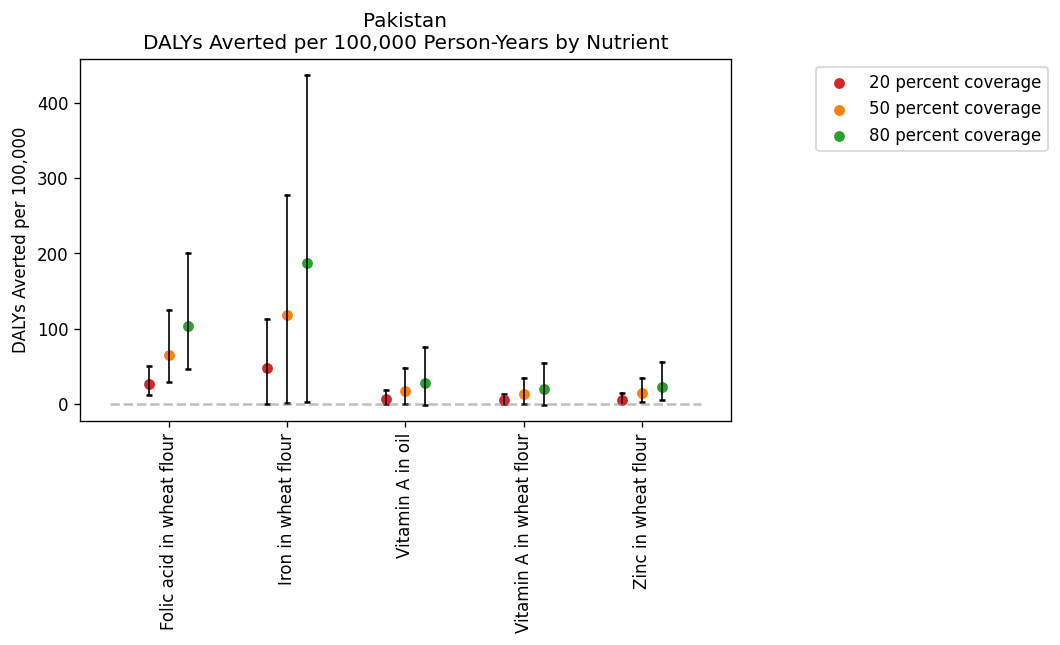

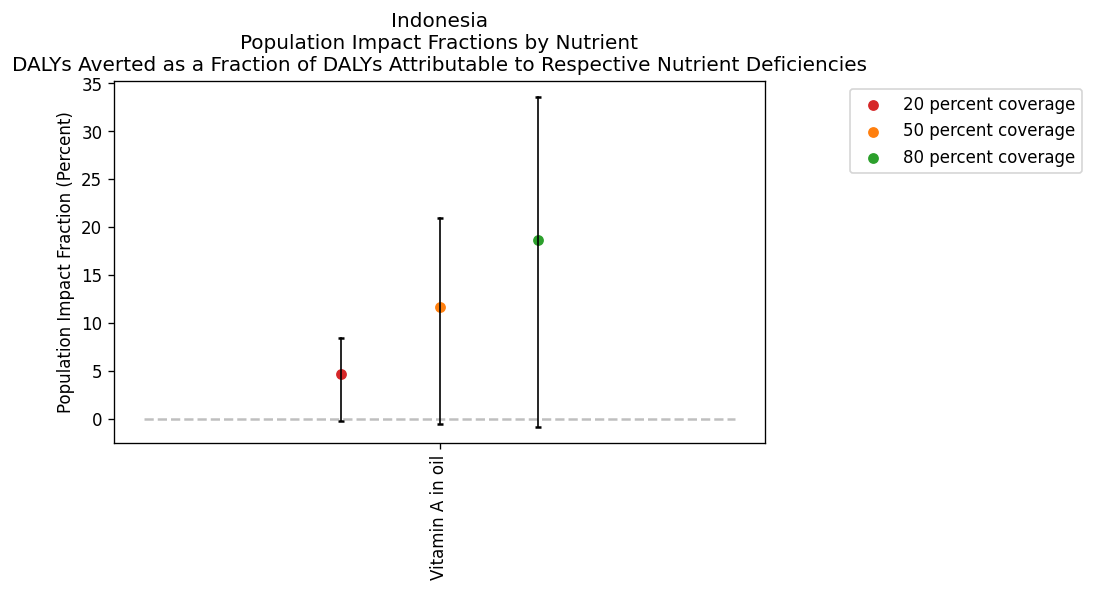

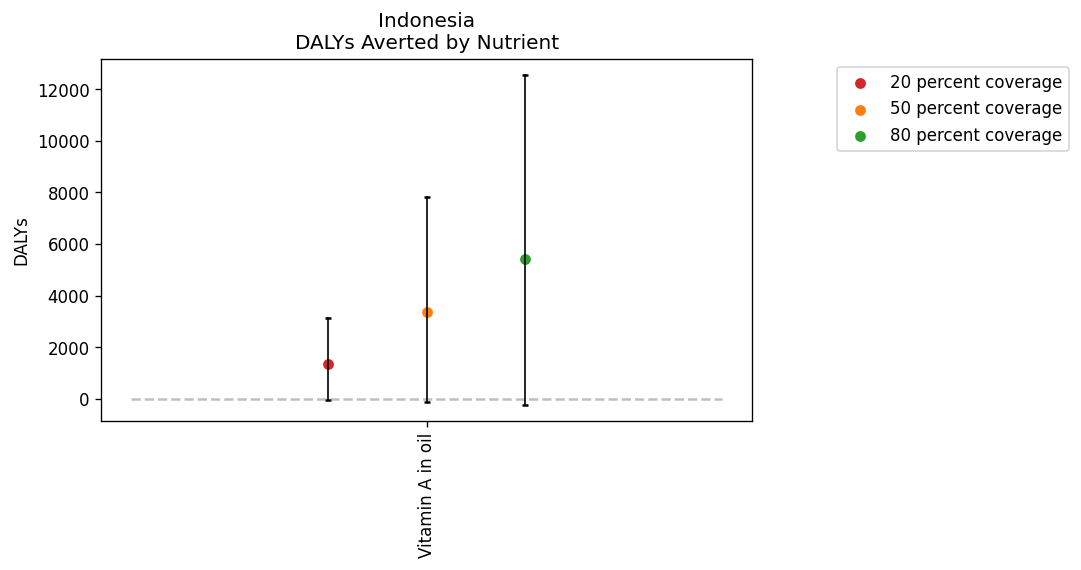

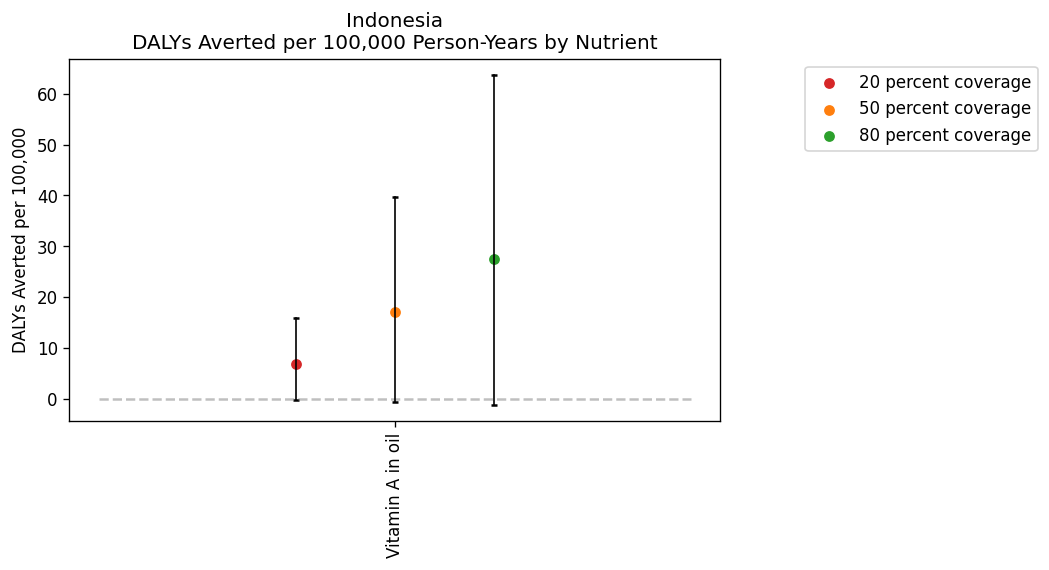

In [163]:
with PdfPages('results_plots/impact_by_location.pdf') as pdf:
    for location_id in results.location_id.unique():
        for measure in ['pif','counts_averted','rates_averted']:
            make_location_specific_plots(results, location_id, measure, coverage_levels)
            pdf.savefig(bbox_inches='tight')

In [53]:
model_results_for_table = results.drop(columns=['year','location_id'])
model_results_for_table = model_results_for_table.set_index([c for c in model_results_for_table.columns if 'draw' not in c])
model_results_for_table = (model_results_for_table.apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
                           .rename(columns={'2.5%':'lower','97.5%':'upper','mean':'mean_val'})
                           .filter(['mean_val','lower','upper'])
                           .reset_index())

for col in ['mean_val','lower','upper']:
    model_results_for_table[f'{col}'] = np.where(model_results_for_table.measure.isin(['pif','deficiency_exposure']),
                                           model_results_for_table[f'{col}'].map('{:.1f}'.format),
                                           model_results_for_table[f'{col}'].map('{:,.0f}'.format))

model_results_for_table['value'] = (model_results_for_table['mean_val'].astype(str)
                                            +'\r\n('
                                            +model_results_for_table['lower'].astype(str)
                                            +', '
                                            +model_results_for_table['upper'].astype(str)
                                            +')')

model_results_for_table['col_name'] = (model_results_for_table.label + 
                                       np.where(model_results_for_table.measure == 'pif', ' PIF (percent): ',
                                               np.where(model_results_for_table.measure == 'counts_averted', ' DALYs averted: ',
                                                       np.where(model_results_for_table.measure == 'rates_averted', ' DALYs averted per 100,000 person-years: ',
                                                              ' ' + model_results_for_table.nutrient + ' deficiency prevalence ')))
                                      + (model_results_for_table.coverage_level * 100).astype(int).astype(str)
                                       + '% scale-up')

model_results_for_table = model_results_for_table[['col_name','location_name','value']]
model_results_for_table = model_results_for_table.pivot_table(index='location_name',
                                     columns='col_name', 
                                     values='value',
                                     aggfunc=lambda x: ' '.join(x))   
model_results_for_table = model_results_for_table.replace(np.nan, 'Not modeled')
model_results_for_table.head()

col_name      Folic acid in maize flour DALYs averted per 100,000 person-years: 20% scale-up  \
location_name                                                                                  
Angola                                               4\r\n(1, 8)                               
Bangladesh                                           Not modeled                               
Burkina Faso                                         0\r\n(0, 0)                               
Cameroon                                           10\r\n(3, 23)                               
China                                                Not modeled                               

col_name      Folic acid in maize flour DALYs averted per 100,000 person-years: 50% scale-up  \
location_name                                                                                  
Angola                                             10\r\n(4, 20)                               
Bangladesh                                           Not modeled                               
Burkina Faso                                         0\r\n(0, 0)                               
Cameroon                                           25\r\n(8, 56)                               
China                                                Not modeled                               

col_name      Folic acid in maize flour DALYs averted per 100,000 person-years: 80% scale-up  \
location_name                                                                                  
Angola                                             16\r\n(6, 32)                               
Bangladesh                                           Not modeled                               
Burkina Faso                                         0\r\n(0, 0)                               
Cameroon                                          40\r\n(13, 90)                               
China                                                Not modeled                               

col_name      Folic acid in maize flour DALYs averted: 20% scale-up  \
location_name                                                         
Angola                                          207\r\n(77, 415)      
Bangladesh                                           Not modeled      
Burkina Faso                                         0\r\n(0, 0)      
Cameroon                                       421\r\n(132, 948)      
China                                                Not modeled      

col_name      Folic acid in maize flour DALYs averted: 50% scale-up  \
location_name                                                         
Angola                                       518\r\n(191, 1,038)      
Bangladesh                                           Not modeled      
Burkina Faso                                         0\r\n(0, 0)      
Cameroon                                   1,053\r\n(329, 2,370)      
China                                                Not modeled      

col_name      Folic acid in maize flour DALYs averted: 80% scale-up  \
location_name                                                         
Angola                                       828\r\n(306, 1,661)      
Bangladesh                                           Not modeled      
Burkina Faso                                         0\r\n(0, 0)      
Cameroon                                   1,685\r\n(527, 3,792)      
China                                                Not modeled      

col_name      Folic acid in maize flour PIF (percent): 20% scale-up  \
location_name                                                         
Angola                                         0.2\r\n(0.1, 0.3)      
Bangladesh                                           Not modeled      
Burkina Faso                                   0.0\r\n(0.0, 0.0)      
Cameroon                                       0.4\r\n(0.2, 0.7)      
China                                                Not mode

In [54]:
anemia_u5 = pd.read_pickle('results_raw/iron_deficiency_difference_u5.pkl')
anemia_u5['subgroup'] = 'children under five'
anemia_wra = pd.read_pickle('results_raw/iron_deficiency_difference_wra.pkl')
anemia_wra['subgroup'] = 'women of reproductive age'
anemia = pd.concat([anemia_u5, anemia_wra], ignore_index=True, sort=True)
anemia = anemia.loc[anemia.year==2025]
anemia = (anemia.set_index([c for c in anemia.columns if 'draw' not in c])
          .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
          .filter(['mean','2.5%','97.5%'])
          .reset_index())
for col in ['mean','2.5%','97.5%']:
    anemia[f'{col}'] = anemia[f'{col}'].map('{:.1f}'.format)
anemia['value'] = (anemia['mean'].astype(str)
                    +'\r\n('
                    +anemia['2.5%'].astype(str)
                    +', '
                    +anemia['97.5%'].astype(str)
                    +')')
anemia['description'] = ('Iron in '
                         + anemia.vehicle
                         + np.where(anemia.measure=='anemia', ' anemia prevalence', ' iron deficiency anemia prevalence')
                         + ' among '
                         + anemia.subgroup
                         + ': '
                         + (anemia.coverage_level.astype(float) * 100).astype(int).astype(str)
                         + '% scale-up')
anemia = anemia[['location_id','value','description']]
anemia = anemia.pivot_table(index='location_id',
                                     columns='description', 
                                     values='value',
                                     aggfunc=lambda x: ' '.join(x))   
anemia = anemia.replace(np.nan, 'Not modeled')
anemia.head()

description Iron in maize flour anemia prevalence among children under five: 20% scale-up  \
location_id                                                                                 
6                                                  Not modeled                              
15                                                 Not modeled                              
20                                                 Not modeled                              
141                                       27.7\r\n(22.0, 34.1)                              
161                                                Not modeled                              

description Iron in maize flour anemia prevalence among children under five: 50% scale-up  \
location_id                                                                                 
6                                                  Not modeled                              
15                                                 Not modeled                              
20                                                 Not modeled                              
141                                       27.2\r\n(21.3, 33.6)                              
161                                                Not modeled                              

description Iron in maize flour anemia prevalence among children under five: 80% scale-up  \
location_id                                                                                 
6                                                  Not modeled                              
15                                                 Not modeled                              
20                                                 Not modeled                              
141                                       26.6\r\n(20.7, 33.1)                              
161                                                Not modeled                              

description Iron in maize flour anemia prevalence among women of reproductive age: 20% scale-up  \
location_id                                                                                       
6                                                  Not modeled                                    
15                                                 Not modeled                                    
20                                                 Not modeled                                    
141                                       22.8\r\n(19.0, 26.8)                                    
161                                                Not modeled                                    

description Iron in maize flour anemia prevalence among women of reproductive age: 50% scale-up  \
location_id                                                                                       
6                                                  Not modeled                                    
15                                                 Not modeled                                    
20                                                 Not modeled                                    
141                                       22.1\r\n(18.1, 26.3)                                    
161                                                Not modeled                                    

description Iron in maize flour anemia prevalence among women of reproductive age: 80% scale-up  \
location_id                                                                                       
6                                                  Not modeled                                    
15                                                 Not modeled                                    
20                                                 Not modeled                                    
141                                       21.5\r\n(17.3, 26.0)                                    
161                                                Not modeled

In [72]:
ntds_maize = pd.read_pickle('results_raw/ntd_birth_prevalence_maize.pkl')
ntds_maize['vehicle'] = 'maize flour'
ntds_wheat = pd.read_pickle('results_raw/ntd_birth_prevalence_wheat.pkl')
ntds_wheat['vehicle'] = 'wheat flour'
ntds = pd.concat([ntds_maize, ntds_wheat]).reset_index()
ntds = (ntds.set_index([c for c in ntds.columns if 'draw' not in c])
          .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
          .filter(['mean','2.5%','97.5%'])
          .reset_index())
for col in ['mean','2.5%','97.5%']:
    ntds[f'{col}'] = ntds[f'{col}'] / 100
    ntds[f'{col}'] = ntds[f'{col}'].map('{:.1f}'.format) 
ntds['value'] = (ntds['mean'].astype(str)
                    +'\r\n('
                    +ntds['2.5%'].astype(str)
                    +', '
                    +ntds['97.5%'].astype(str)
                    +')')
ntds['description'] = ('Folic acid in '
                         + ntds.vehicle
                         + ' neural tube defects birth prevalence per 1,000: '
                         + (ntds.coverage_level.astype(float) * 100).astype(int).astype(str)
                         + '% scale-up')
ntds = ntds[['location_id','value','description']]
ntds = ntds.pivot_table(index='location_id',
                                     columns='description', 
                                     values='value',
                                     aggfunc=lambda x: ' '.join(x))   
ntds = ntds.replace(np.nan, 'Not modeled')
ntds.head()

description Folic acid in maize flour neural tube defects birth prevalence per 1,000: 20% scale-up  \
location_id                                                                                          
6                                                  Not modeled                                       
15                                                 Not modeled                                       
20                                                 Not modeled                                       
141                                          0.8\r\n(0.7, 1.0)                                       
161                                                Not modeled                                       

description Folic acid in maize flour neural tube defects birth prevalence per 1,000: 50% scale-up  \
location_id                                                                                          
6                                                  Not modeled                                       
15                                                 Not modeled                                       
20                                                 Not modeled                                       
141                                          0.8\r\n(0.6, 1.0)                                       
161                                                Not modeled                                       

description Folic acid in maize flour neural tube defects birth prevalence per 1,000: 80% scale-up  \
location_id                                                                                          
6                                                  Not modeled                                       
15                                                 Not modeled                                       
20                                                 Not modeled                                       
141                                          0.8\r\n(0.6, 1.0)                                       
161                                                Not modeled                                       

description Folic acid in wheat flour neural tube defects birth prevalence per 1,000: 20% scale-up  \
location_id                                                                                          
6                                            0.3\r\n(0.2, 0.3)                                       
15                                           1.0\r\n(0.8, 1.3)                                       
20                                           0.4\r\n(0.3, 0.4)                                       
141                                          0.8\r\n(0.7, 1.0)                                       
161                                          0.8\r\n(0.6, 1.0)                                       

description Folic acid in wheat flour neural tube defects birth prevalence per 1,000: 50% scale-up  \
location_id                                                                                          
6                                            0.2\r\n(0.2, 0.3)                                       
15                                           1.0\r\n(0.8, 1.3)                                       
20                                           0.4\r\n(0.3, 0.4)                                       
141                                          0.8\r\n(0.6, 1.0)                                       
161                                          0.8\r\n(0.6, 0.9)                                       

description Folic acid in wheat flour neural tube defects birth prevalence per 1,000: 80% scale-up  
location_id                                                                                         
6                                            0.2\r\n(0.2, 0.3)                                      
15                                           1.0\r\n(0.8, 1.3)                                      
20                   

# Baseline burden

In [34]:
gbd_data_dir = '/ihme/homes/alibow/notebooks/vivarium_research_lsff/gbd_data_summary/output_data/'

In [35]:
zinc_gbd = pd.read_csv(gbd_data_dir + 'zinc_data_formatted.csv')
vitamin_a_gbd = pd.read_csv(gbd_data_dir + 'vitamin_a_data_formatted.csv')
neural_tube_defects_gbd = pd.read_csv(gbd_data_dir + 'neural_tube_defects_data_formatted.csv')

iron_gbd = pd.read_csv(gbd_data_dir + 'iron_data_formatted.csv').set_index(['location_name','location_id'])
iron_gbd_wra = iron_gbd.loc[iron_gbd.population=='WRA'].drop(columns='population')
for col in iron_gbd_wra.columns:
    iron_gbd_wra = iron_gbd_wra.rename(columns={f'{col}':f'Baseline {col} among WRA'})
iron_gbd_u5 = iron_gbd.loc[iron_gbd.population=='Children U5'].drop(columns='population')
for col in iron_gbd_u5.columns:
    iron_gbd_u5 = iron_gbd_u5.rename(columns={f'{col}':f'Baseline {col} among Children U5'})
iron_gbd = iron_gbd_wra.reset_index().merge(iron_gbd_u5.reset_index(), on=['location_name','location_id'])

gbd_data = (zinc_gbd.merge(vitamin_a_gbd, on=['location_id','location_name'])
            .merge(neural_tube_defects_gbd, on=['location_id','location_name'])
            .set_index(['location_id','location_name']))
for col in gbd_data.columns:
    gbd_data = gbd_data.rename(columns={f'{col}':f'Baseline {col}'})
gbd_data = gbd_data.reset_index().merge(iron_gbd, on=['location_id','location_name'])

gbd_data.head()

location_id location_name  \
0          168        Angola   
1          161    Bangladesh   
2          201  Burkina Faso   
3          202      Cameroon   
4            6         China   

  Baseline Prevalence of Zinc deficiency in age group 1 to 4 (per 100)  \
0                                14.1\r\n(2.5, 28.7)                     
1                                 9.7\r\n(1.1, 23.1)                     
2                                  3.1\r\n(0.0, 9.8)                     
3                                 4.8\r\n(0.0, 13.8)                     
4                                  1.1\r\n(0.0, 3.4)                     

  Baseline Number in age group 1 to 4 with Zinc deficiency (1000s)  \
0                                577\r\n(103, 1,173)                 
1                              1,077\r\n(120, 2,568)                 
2                                     98\r\n(0, 310)                 
3                                    159\r\n(0, 460)                 
4                                  758\r\n(0, 2,247)                 

  Baseline DALYs attributable to Zinc deficiency in age group 1 to 4  \
0                             5,150\r\n(768, 13,767)                   
1                                 957\r\n(90, 2,850)                   
2                                1,694\r\n(0, 6,200)                   
3                               3,796\r\n(0, 13,324)                   
4                                    222\r\n(0, 743)                   

  Baseline DALYs attributable to Zinc deficiency per 100,000 person-years in age group 1 to 4  \
0                                   126\r\n(19, 337)                                            
1                                       9\r\n(1, 26)                                            
2                                     54\r\n(0, 196)                                            
3                                    114\r\n(0, 399)                                            
4                                        0\r\n(0, 1)                                            

  Baseline Prevalence of Vitamin A deficiency in age group Under 5 (per 100)  \
0                               26.4\r\n(18.4, 36.9)                           
1                                 8.4\r\n(5.3, 12.8)                           
2                               35.4\r\n(26.0, 45.7)                           
3                               27.9\r\n(19.0, 38.5)                           
4                                  3.9\r\n(2.4, 6.1)                           

  Baseline Number in age group Under 5 with Vitamin A deficiency (1000s)  \
0                              1,358\r\n(947, 1,899)                       
1                              1,156\r\n(727, 1,765)                       
2                            1,433\r\n(1,053, 1,848)                       
3                              1,174\r\n(798, 1,619)                       
4                            3,141\r\n(1,924, 4,995)                       

  Baseline DALYs attributable to Vitamin A deficiency in age group Under 5 (1000s)  \
0                                35.8\r\n(9.0, 68.7)                                 
1                                 8.2\r\n(4.5, 13.3)                                 
2                              67.6\r\n(17.2, 144.7)                                 
3                              63.6\r\n(11.7, 137.4)                                 
4                                12.5\r\n(7.5, 18.8)                                 

  Baseline DALYs attributable to Vitamin A deficiency per 100,000 person-years in age group Under 5  \
0                                695\r\n(174, 1,335)                                                  
1                                     59\r\n(32, 97)                                                  
2                              1,671\r\n(424, 3,576)                                                  
3                              1,511\r\n(279, 3,265)         

In [70]:
gbd_data.columns

Index(['location_id', 'location_name',
       'Baseline Prevalence of Zinc deficiency in age group 1 to 4 (per 100)',
       'Baseline Number in age group 1 to 4 with Zinc deficiency (1000s)',
       'Baseline DALYs attributable to Zinc deficiency in age group 1 to 4',
       'Baseline DALYs attributable to Zinc deficiency per 100,000 person-years in age group 1 to 4',
       'Baseline Prevalence of Vitamin A deficiency in age group Under 5 (per 100)',
       'Baseline Number in age group Under 5 with Vitamin A deficiency (1000s)',
       'Baseline DALYs attributable to Vitamin A deficiency in age group Under 5 (1000s)',
       'Baseline DALYs attributable to Vitamin A deficiency per 100,000 person-years in age group Under 5',
       'Baseline Prevalence of Neural tube defects in age group Birth (per 1000)',
       'Baseline Number in age group Birth with Neural tube defects',
       'Baseline DALYs attributable to Neural tube defects in age group Under 5 (1000s)',
       'Baseline DAL

# Coverage

In [36]:
coverage = pd.read_pickle('results_raw/coverage_u5.pkl')
coverage = coverage.loc[coverage.year==2025]

coverage['value'] = ((coverage['mean'] * 100).round(1).astype(str)
                        +'\r\n('
                        +(coverage['2.5%'] * 100).round(1).astype(str)
                        +', '
                        +(coverage['97.5%'] * 100).round(1).astype(str)
                        +')')

coverage['parameter_description'] = np.where(coverage.coverage_level == 'baseline', 'Percent of population eating ' + coverage.nutrient + ' fortified ' + coverage.vehicle +' at baseline',
                                            np.where(coverage.coverage_level == 'maximum', f'Percent of population eating fortifiable ' + coverage.vehicle, 
                                            'Percent of population eating ' + coverage.nutrient + ' fortified ' + coverage.vehicle + ': ' + (coverage.coverage_level * 100).astype(str) + '0% scale-up'))

coverage['parameter_description'] = coverage['parameter_description'].str.replace('.00%','%')
coverage = coverage[['location_id','value','parameter_description']]
coverage = coverage.pivot_table(index='location_id',
                                     columns='parameter_description', 
                                     values='value',
                                     aggfunc=lambda x: ' '.join(x))   
coverage = coverage.replace(np.nan, 'Not modeled').reset_index()

coverage

parameter_description  location_id  \
0                                6   
1                               11   
2                               15   
3                               20   
4                              141   
5                              161   
6                              163   
7                              164   
8                              165   
9                              168   
10                             171   
11                             179   
12                             180   
13                             181   
14                             184   
15                             189   
16                             190   
17                             196   
18                             201   
19                             202   
20                             205   
21                             207   
22                             213   
23                             214   
24                             522   

parameter_description Percent of population eating folic acid fortified maize flour at baseline  \
0                                                            Not modeled                          
1                                                            Not modeled                          
2                                                            Not modeled                          
3                                                            Not modeled                          
4                                                      0.0\r\n(0.0, 0.0)                          
5                                                            Not modeled                          
6                                                            Not modeled                          
7                                                            Not modeled                          
8                                                            Not modeled                          
9                                                     7.7\r\n(1.1, 15.1)                          
10                                                     0.0\r\n(0.0, 0.0)                          
11                                                     0.0\r\n(0.0, 0.0)                          
12                                                     0.0\r\n(0.0, 0.0)                          
13                                                     4.1\r\n(1.8, 6.2)                          
14                                                  16.7\r\n(12.8, 20.4)                          
15                                                     2.5\r\n(1.3, 3.7)                          
16                                                     6.5\r\n(3.4, 9.7)                          
17                                                  58.1\r\n(47.7, 68.6)                          
18                                                     0.0\r\n(0.0, 0.0)                          
19                                                     5.2\r\n(2.2, 8.2)                          
20                                                    6.7\r\n(2.7, 10.7)                          
21                                                     4.0\r\n(1.6, 6.4)                          
22                                                     3.9\r\n(1.7, 6.2)                          
23                                                     1.2\r\n(0.6, 1.9)                          
24                                                     5.7\r\n(2.4, 8.8)                          

parameter_description Percent of population eating folic acid fortified maize flour: 20% scale-up  \
0                                                            Not modeled                            
1                                                            Not modeled                            
2                                                            Not modeled                            
3                               

In [48]:
username = !whoami
coverage_confidence_data_dir = f'/ihme/homes/{username[0]}/notebooks/vivarium_research_lsff/data_prep/outputs/data_richness_score.csv'
conf = pd.read_csv(coverage_confidence_data_dir).drop_duplicates().dropna()
conf = conf.loc[conf.nutrient!='na']
conf['col_name'] = conf.nutrient.str.capitalize() + ' in ' + conf.vehicle + ' coverage data confidence score'
conf['score'] = (conf['score']+1).map('{:,.0f}'.format)
conf = conf[['location_name','score','col_name']]
conf = conf.pivot_table(index='location_name',
                                     columns='col_name', 
                                     values='score',
                                     aggfunc=lambda x: ' '.join(x)) 
conf = conf.replace(np.nan, 'Not modeled')
conf

col_name                         Folic acid in maize flour coverage data confidence score  \
location_name                                                                               
Angola                                                                            1         
Bangladesh                                                              Not modeled         
Burkina Faso                                                                      3         
Cameroon                                                                          1         
China                                                                   Not modeled         
Côte d'Ivoire                                                                     1         
Democratic Republic of the Congo                                                  3         
Egypt                                                                             1         
Ethiopia                                                                          1         
Ghana                                                                             1         
India                                                                   Not modeled         
Indonesia                                                               Not modeled         
Kenya                                                                             4         
Madagascar                                                                        1         
Mozambique                                                                        3         
Myanmar                                                                 Not modeled         
Nepal                                                                   Not modeled         
Niger                                                                             1         
Nigeria                                                                           5         
Pakistan                                                                Not modeled         
South Africa                                                                      5         
Sudan                                                                             1         
Uganda                                                                            5         
United Republic of Tanzania                                                       5         
Viet Nam                                                                Not modeled         

col_name                         Folic acid in wheat flour coverage data confidence score  \
location_name                                                                               
Angola                                                                            1         
Bangladesh                                                                        3         
Burkina Faso                                                                      3         
Cameroon                                                                          3         
China                                                                             1         
Côte d'Ivoire                                                                     3         
Democratic Republic of the Congo                                                  3         
Egypt                                                                             1         
Ethiopia                                                                          2         
Ghana                                                                             1         
India                                                                             5         
Indonesia                                                                         3         
Kenya                                                                             1         
Madagascar                                                                        1         


# Costs

In [38]:
# read in cost data
costs = pd.read_csv('raw_costs.csv')
costs.head()

location_name vehicle  five_year_cost  ten_year_cost
0                            Angola     oil           18.87          39.32
1                        Bangladesh     oil          131.12         277.66
2  Bolivia (Plurinational State of)     oil            4.93           9.57
3                      Burkina Faso     oil           16.98          34.66
4                           Burundi     oil            2.92           5.50

In [39]:
# merge location_ids
l = get_ids('location')
l = l.loc[l.location_type == 'admin0'].loc[l.location_id != 522]
cdi_name = l[l['location_id'] ==  205]['location_name'].values[0]
costs = costs.replace("Cote d'Ivoire", cdi_name)
costs_with_location_ids = costs.merge(l[['location_id','location_name']], on='location_name')

assert len(costs) == len(costs_with_location_ids), "Error: different number of rows after merging with location IDs"

costs_with_location_ids.head()

location_name      vehicle  five_year_cost  ten_year_cost  location_id
0        Angola          oil           18.87          39.32          168
1        Angola  maize flour           24.00          43.80          168
2        Angola  wheat flour            1.00           1.40          168
3    Bangladesh          oil          131.12         277.66          161
4    Bangladesh  wheat flour            5.20           9.90          161

In [40]:
measure = 'counts_averted'

results_icers = results.loc[results.measure == measure].loc[results.coverage_level == 0.8]
results_icers = (results_icers.merge(costs_with_location_ids, on=['location_id','vehicle','location_name'])).drop(columns='five_year_cost')
results_icers['ten_year_cost'] = results_icers['ten_year_cost'] / 10 


for i in list(range(0,1000)):
    results_icers[f'draw_{i}'] = (results_icers['ten_year_cost']) * 1_000_000 / results_icers[f'draw_{i}']
    
results_icers = results_icers.set_index([c for c in results_icers.columns if 'draw' not in c])
results_icers = results_icers.apply(pd.DataFrame.describe, percentiles=[0.25,0.75], axis=1).reset_index()
results_icers.head()

coverage_level  location_id         measure    nutrient      vehicle  \
0             0.8          168  counts_averted  folic acid  maize flour   
1             0.8          168  counts_averted        zinc  maize flour   
2             0.8          168  counts_averted   vitamin A  maize flour   
3             0.8          168  counts_averted        iron  maize flour   
4             0.8          168  counts_averted  folic acid  wheat flour   

     year nutrient_name location_name                      label  \
0  2025.0    Folic acid        Angola  Folic acid in maize flour   
1  2025.0          Zinc        Angola        Zinc in maize flour   
2  2025.0     Vitamin A        Angola   Vitamin A in maize flour   
3  2025.0          Iron        Angola        Iron in maize flour   
4  2025.0    Folic acid        Angola  Folic acid in wheat flour   

   ten_year_cost   count         mean           std           min  \
0           4.38  1000.0  6530.496330  6.850089e+03  1.979353e+03   
1           4.38  1000.0          inf           NaN  1.322857e+04   
2           4.38  1000.0 -4339.714459  1.006139e+06 -3.143309e+07   
3           4.38  1000.0  3607.256692  1.046847e+05 -2.896091e+06   
4           0.14  1000.0    61.658737  3.119718e+01  1.369221e+01   

            25%           50%            75%           max  
0   4358.099174   5634.867141    7307.416989  1.902315e+05  
1  51248.177330  83462.719030  143820.005206           inf  
2   8754.149114  12851.270702   21426.140036  3.361643e+06  
3   3212.221055   4488.890433    6727.755890  7.500406e+05  
4     40.171237     54.714607      75.696034  3.115952e+02

In [41]:
icers = results_icers.copy()
for col in ['50%','25%','75%']:
    icers[f'{col}'] = icers[f'{col}'].map('{:,.0f}'.format)

icers['value'] =  (icers['50%'].astype(str).str.split('.', expand=True)[0]
                                            +'\r\n('
                                            +icers['25%'].astype(str).str.split('.', expand=True)[0]
                                            +', '
                                            +icers['75%'].astype(str).str.split('.', expand=True)[0]
                                            +')')
icers['descrip'] = icers.nutrient_name + ' fortified ' + icers.vehicle + ' cost per DALY averted (US dollars), median and IQR'
icers = icers.filter(['value','descrip','location_id','location_name'])
icers = icers.pivot_table(index=['location_id','location_name'],
                                     columns='descrip', 
                                     values='value',
                                     aggfunc=lambda x: ' '.join(x))   
icers = icers.replace(np.nan, 'Not modeled').reset_index()
icers

descrip  location_id                     location_name  \
0                  6                             China   
1                 11                         Indonesia   
2                 15                           Myanmar   
3                 20                          Viet Nam   
4                161                        Bangladesh   
5                163                             India   
6                164                             Nepal   
7                165                          Pakistan   
8                168                            Angola   
9                171  Democratic Republic of the Congo   
10               179                          Ethiopia   
11               180                             Kenya   
12               181                        Madagascar   
13               184                        Mozambique   
14               189       United Republic of Tanzania   
15               190                            Uganda   
16               196                      South Africa   
17               201                      Burkina Faso   
18               202                          Cameroon   
19               205                     Côte d'Ivoire   
20               207                             Ghana   
21               213                             Niger   
22               214                           Nigeria   

descrip Folic acid fortified maize flour cost per DALY averted (US dollars), median and IQR  \
0                                              Not modeled                                    
1                                              Not modeled                                    
2                                              Not modeled                                    
3                                              Not modeled                                    
4                                              Not modeled                                    
5                                              Not modeled                                    
6                                              Not modeled                                    
7                                              Not modeled                                    
8                                  5,635\r\n(4,358, 7,307)                                    
9                                              Not modeled                                    
10                                             Not modeled                                    
11                                 3,062\r\n(2,395, 3,996)                                    
12                                             Not modeled                                    
13                                             Not modeled                                    
14                                       427\r\n(331, 554)                                    
15                                       283\r\n(218, 367)                                    
16                              30,808\r\n(26,306, 37,411)                                    
17                                             Not modeled                                    
18                                             Not modeled                                    
19                                 5,806\r\n(4,229, 8,172)                                    
20                                 4,524\r\n(3,285, 6,284)                                    
21                                             Not modeled                                    
22                                             Not modeled                                    

descrip Folic acid fortified wheat flour cost per DALY averted (US dollars), median and IQR  \
0                                  2,631\r\n(2,155, 3,355)                                    
1                                              Not modeled                                    
2                                        

In [42]:
cost = costs_with_location_ids.copy()
cost['descrip'] = 'Annual ' + cost.vehicle + ' fortification cost (millions of US dollars)'
cost['cost'] = (cost['ten_year_cost'] / 10).round(2)
cost = cost.pivot_table(index=['location_id','location_name'],
                                     columns='descrip', 
                                     values='cost')   
cost = cost.replace(np.nan, 'Not estimated').reset_index()
cost.head()

descrip  location_id location_name  \
0                  6         China   
1                 10      Cambodia   
2                 11     Indonesia   
3                 15       Myanmar   
4                 16   Philippines   

descrip Annual maize flour fortification cost (millions of US dollars)  \
0                                            Not estimated               
1                                            Not estimated               
2                                            Not estimated               
3                                            Not estimated               
4                                            Not estimated               

descrip Annual oil fortification cost (millions of US dollars)  \
0                                            Not estimated       
1                                            Not estimated       
2                                                    24.11       
3                                                     9.81       
4                                                    11.14       

descrip Annual wheat flour fortification cost (millions of US dollars)  
0                                                    51.37              
1                                                     0.12              
2                                                     0.19              
3                                                     0.12              
4                                                     0.26

In [43]:
vehicles = ['oil','maize flour','wheat flour']

# print location ids that were excluded due to lack of cost data for each vehicle
print('Location IDs excluded due to lack of cost data for each vehicle')
for vehicle in vehicles:
    exclusions = ([c for c in list(results.loc[results.vehicle == vehicle].location_id.unique())
                     if c not in list(results_icers.loc[results_icers.vehicle == vehicle].location_id.unique())])
    print(f'{vehicle}: {exclusions}')

Location IDs excluded due to lack of cost data for each vehicle
oil: [522]
maize flour: [141, 171, 179, 181, 184, 201, 202, 213, 214, 522]
wheat flour: [141, 190, 522]


In [44]:
l = get_ids('location')
l[l['location_id'].isin([522])].sort_values(by='location_name').location_name.values

array(['Sudan'], dtype=object)

In [29]:
def make_cost_per_daly_plots(data, vehicle, nutrient, value_cap, confidence_data, uncertainty=True):
    df = (data
                .loc[data.vehicle == vehicle]
                .loc[data.nutrient == nutrient]
                .loc[data['50%'] <= value_cap]
                .sort_values(by='50%'))
    
    f, ax = plt.subplots(figsize=(7, 4), dpi=120)
    colors = ['tab:red', 'tab:orange', 'tab:green']

    location_spacer = 0.15
    x_vals = []
    for i in list(range(0, len(df))):
        if uncertainty: 
            plt.plot([location_spacer * i, location_spacer * i],
                     [df['25%'].values[i], df['75%'].values[i]], c='black')
            plt.scatter([location_spacer * i], df['25%'].values[i], s=50, marker='_',
                        c='black')
            plt.scatter([location_spacer * i], df['75%'].values[i], s=50, marker='_',
                        c='black')

        x_vals.append(location_spacer * i)
    
    plt.scatter(x_vals, df['50%'], s=50)

    plt.hlines(0, 0,
               location_spacer * (len(df)),
               linestyle='dashed', color='grey', alpha=0.5)
    
    plt.plot()
    
    plt.title(f'Cost per DALY Averted by Location\n{nutrient.capitalize()} in {vehicle.capitalize()}\nMedian values and interquartile ranges')
    plt.ylabel('Dollars per DALY Averted')
    
    df = df.merge(confidence_data.replace('vitamin a','vitamin A'), on=['location_name','nutrient','vehicle'])
    df['label'] = (np.where(df.score == 5, '***** ',
                      np.where(df.score == 4, '**** ',
                               np.where(df.score == 3, '*** ',
                                        np.where(df.score == 2, '** ',
                                                 np.where(df.score == 1, '* ', '')))))
                   + df.location_name)

    x_ticks = []
    for x in list(range(0, len(df))):
        x_ticks.append(location_spacer * x)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(df.label.values)
    plt.semilogy()
    plt.yticks(ticks=[1,10,100,1_000,10_000,100_000,1_000_000], labels=['1','10','100','1,000','10,000','100,000','1,000,000'])
    plt.xticks(rotation=90)

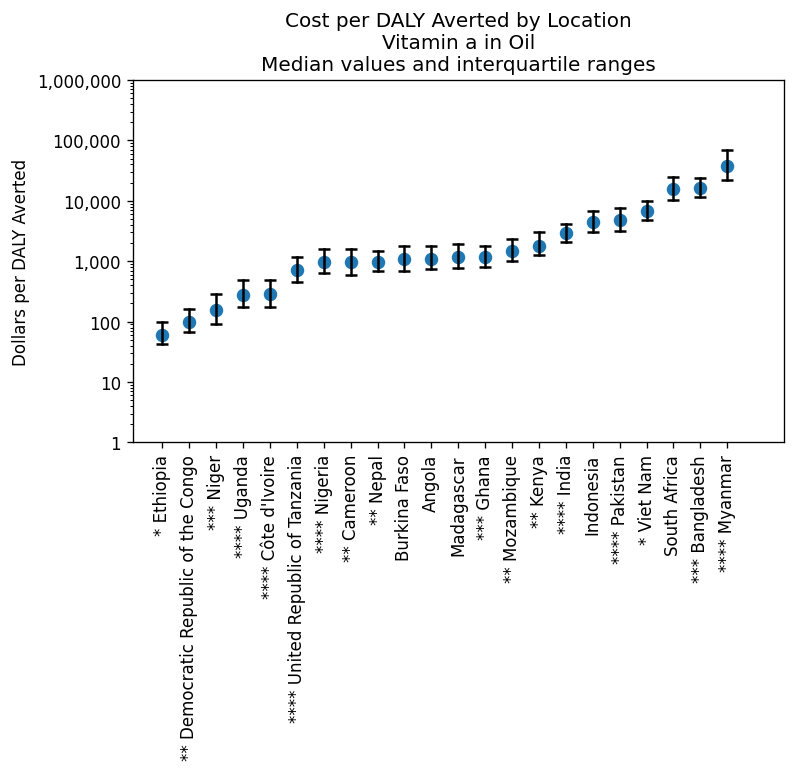

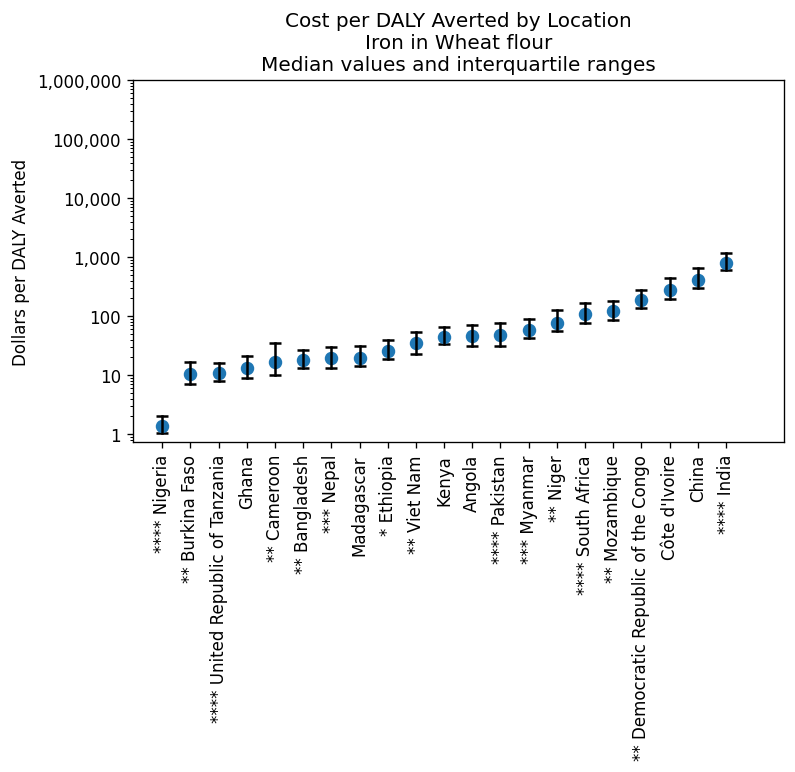

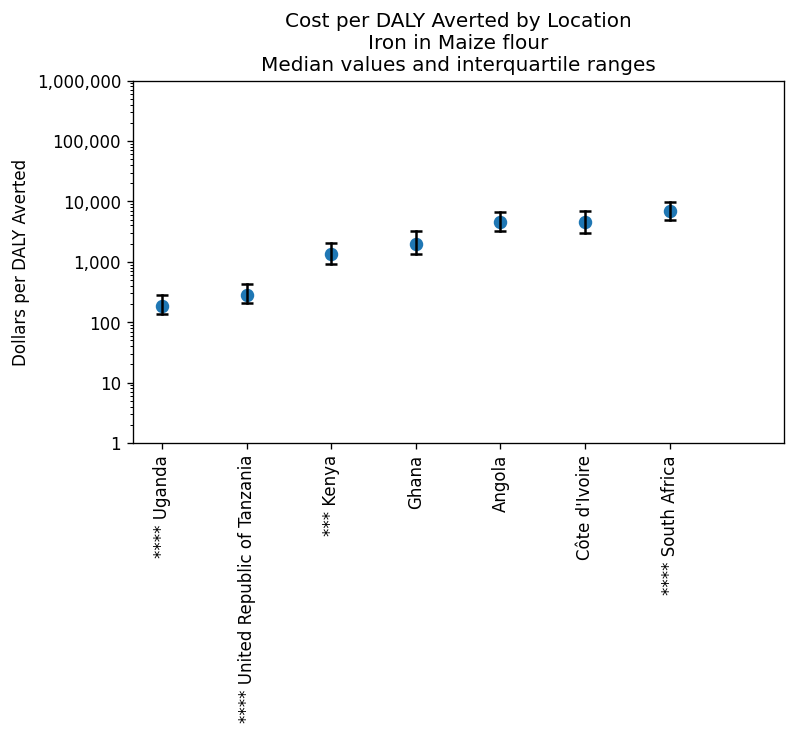

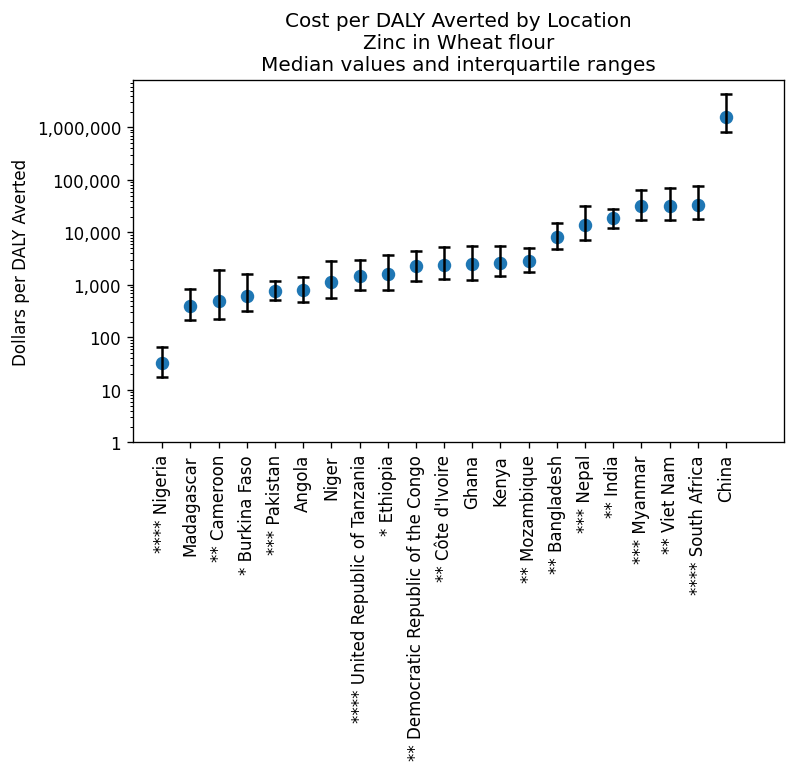

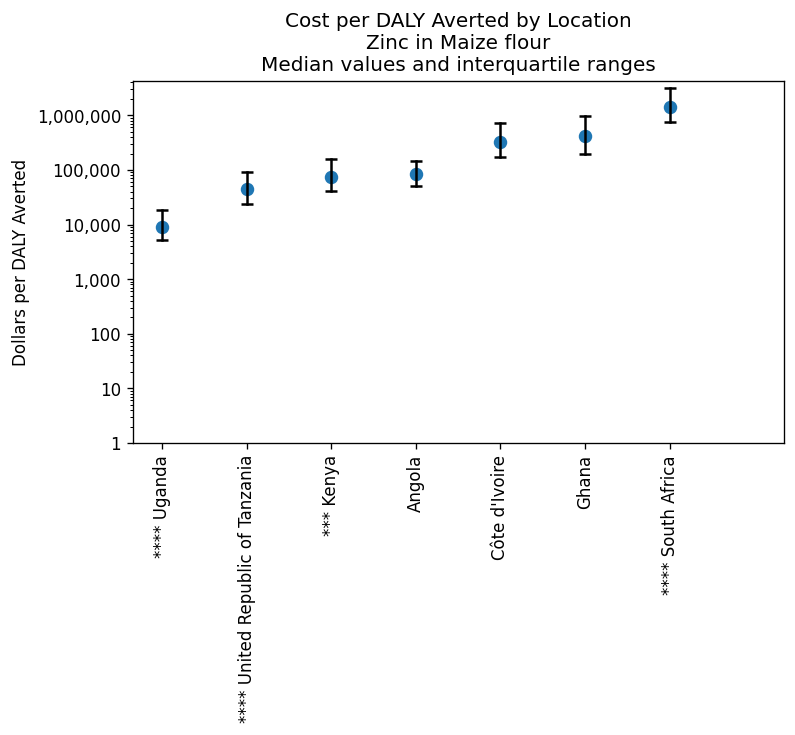

In [85]:
with PdfPages('results_plots/costs_per_daly_by_nutrient_vehicle_pair.pdf') as pdf:

    nutrients = ['vitamin A','iron','zinc']
    for nutrient in nutrients:
        if nutrient == 'vitamin A':
            vehicles = ['oil']
            value_cap = np.inf
        else:
            vehicles = ['wheat flour','maize flour']
        if nutrient == 'iron':
            value_cap = np.inf
        if nutrient == 'zinc':
            value_cap == np.inf
        for vehicle in vehicles:
            make_cost_per_daly_plots(results_icers, vehicle, nutrient, value_cap, confidence, True)
            pdf.savefig(bbox_inches='tight')

# Final CSV

In [50]:
anemia.shape

(24, 24)

In [76]:
final_data_all_nutrients = (gbd_data.loc[gbd_data.location_id!=1]
                                .merge(coverage, on=[c for c in coverage.columns if c in ['location_name','location_id']])
                                .merge(model_results_for_table.reset_index(), on=[c for c in model_results_for_table.reset_index().columns if c in ['location_name','location_id']])
                                .merge(anemia.reset_index(), on='location_id', how='left')
                                .merge(ntds.reset_index(), on='location_id', how='left')
                                .merge(cost, on=[c for c in cost.columns if c in ['location_name','location_id']], how='left')
                                .merge(icers, on=[c for c in icers.columns if c in ['location_name','location_id']], how='left')
                                .rename(columns={'location_name':'Location name'})
                                .set_index(['Location name'])
                                .replace(np.nan, 'Not modeled')
                                .drop(columns='location_id'))

assert len(final_data_all_nutrients) == 25, 'Error: different than expected number of locations'

final_data_zinc = final_data_all_nutrients[[c for c in final_data_all_nutrients.columns if 'Zinc' in c 
                                    or 'zinc' in c
                                    or 'fortifiable wheat flour' in c
                                    or 'fortifiable maize flour' in c
                                    or 'flour fortification cost' in c]].reset_index()
final_data_vitamin_a = final_data_all_nutrients[[c for c in final_data_all_nutrients.columns if 'itamin' in c 
                                    or 'oil' in c
                                    or 'Oil' in c
                                    or 'million' in c]].reset_index()
final_data_iron = final_data_all_nutrients[[c for c in final_data_all_nutrients.columns if 'Iron' in c 
                                    or 'iron' in c
                                    or 'nemia' in c
                                    or 'fortifiable wheat flour' in c
                                    or 'fortifiable maize flour' in c
                                    or 'flour fortification cost' in c]].reset_index()
final_data_folic_acid = final_data_all_nutrients[[c for c in final_data_all_nutrients.columns if 'olic acid' in c 
                                    or 'fortifiable wheat flour' in c
                                    or 'eural' in c       
                                    or 'fortifiable maize flour' in c
                                    or 'flour fortification cost' in c]].reset_index()

final_data_all_nutrients.to_csv('results_plots/final_data_all_nutrients.csv')
final_data_zinc.to_csv('results_plots/final_data_zinc.csv')
final_data_vitamin_a.to_csv('results_plots/final_data_vitamin_a.csv')
final_data_iron.to_csv('results_plots/final_data_iron.csv')
final_data_folic_acid.to_csv('results_plots/final_data_folic_acid.csv')

final_data_vitamin_a.columns

Index(['Location name',
       'Baseline Prevalence of Vitamin A deficiency in age group Under 5 (per 100)',
       'Baseline Number in age group Under 5 with Vitamin A deficiency (1000s)',
       'Baseline DALYs attributable to Vitamin A deficiency in age group Under 5 (1000s)',
       'Baseline DALYs attributable to Vitamin A deficiency per 100,000 person-years in age group Under 5',
       'Percent of population eating vitamin a fortified maize flour at baseline',
       'Percent of population eating vitamin a fortified maize flour: 20% scale-up',
       'Percent of population eating vitamin a fortified maize flour: 50% scale-up',
       'Percent of population eating vitamin a fortified maize flour: 80% scale-up',
       'Percent of population eating vitamin a fortified oil at baseline',
       'Percent of population eating vitamin a fortified oil: 20% scale-up',
       'Percent of population eating vitamin a fortified oil: 50% scale-up',
       'Percent of population eating vitamin